In [16]:
import os
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
import seaborn as sns

In [11]:
device = 'cpu'
gen_dir = 'generated_data/'
models_dir = 'models/' 
plots = 'plots/qualitative/'

In [3]:
def acf_batch(batch, square=False, abs=False):
    series = []
    for i in range(batch.shape[0]):
        s = batch[i, :]
        if square:
            s = np.square(s)
        if abs:
            s = np.abs(s)
        acfs = acf(s)[1:25]
        series.append(pd.Series(acfs) )
    df = pd.concat(series, axis=1).T
    df.columns = list(range(1,25))
    return df 

def plot_cumulativesum(batch, index, title):
    for i in index: 
        plt.plot(np.cumsum(batch[i]))
    plt.title(title)
    plt.show()

In [4]:
# Load data
data = np.load('master_data/data.npy')
train_batches = data.shape[0] # N hereafter. Number of training images in database.
length = data.shape[1] 
stocks = data.shape[2]
print('Number of training batches: ', train_batches)
print('Length of each batch: ', length)
print('Number of stocks: ', stocks)

Number of training batches:  79
Length of each batch:  256
Number of stocks:  434


In [5]:
vaeconv1 = np.load(gen_dir + 'vaeconv1.npy')
print(vaeconv1.shape)
vaeconv3 = np.load(gen_dir + 'vaeconv3.npy')
print(vaeconv3.shape)
vaefd1 = np.load(gen_dir + 'vaefd1.npy')
print(vaefd1.shape)
vaefd2 = np.load(gen_dir + 'vaefd2.npy')
print(vaefd2.shape)
vqvaeconv2 = np.load(gen_dir + 'vqvaeconv2.npy')
print(vqvaeconv2.shape)
vqvaefd1 = np.load(gen_dir + 'vqvaefd1.npy')
print(vqvaefd1.shape)
timevaebase = np.load(gen_dir + 'timevaebase.npy')
print(timevaebase.shape)
timegan = np.load(gen_dir + 'timegan.npy')
print(timegan.shape)

(434, 256)
(434, 256)
(434, 256)
(434, 256)
(434, 256)
(434, 256)
(434, 256)
(434, 256)


In [23]:
generated = {
   'TIME VAE BASE':timevaebase,
   'VAE Convolutional 1':vaeconv1,
   'VAE Convolutional 2':vaeconv3,
   'VAE Dense Layers 1':vaefd1,
   'VAE Dense Layers 2':vaefd2,
   'VQ-VAE Convolutional':vqvaeconv2,
   'VQ-VAE Dense Layers':vqvaefd1,

   # 'TIME GAN':timegan
             }

In [25]:
# make folders 
for k, v in generated.items():
    model = k.replace(' ', '_')
    model = model.replace('-', '_')
    model = model.lower() + '/'
    if not os.path.exists(plots + model):
        os.mkdir(plots + model)


In [26]:
# Radom batches
index = np.random.randint(0, train_batches, 4)
index = [38, 25, 56, 24]

In [27]:
data_eval = np.zeros((len(index), data.shape[2], data.shape[1]))
# print(data_eval.shape)
for i in range(len(index)):
    # print(i)
    batch = data[index[i], :, :].copy()
    batch = np.transpose(batch)
    data_eval[i] = batch
data_eval.shape

(4, 434, 256)

# Central Moments 

In [28]:
moments_data = {}
for i in range(data_eval.shape[0]):
    # print(i)
    # break
    moments_data['Mean_'+str(i)] = np.mean(data_eval[i], axis=1)
    moments_data['Variance_'+str(i)] = np.std(data_eval[i], axis=1)
    moments_data['Skewness_'+str(i)] = stats.skew(data_eval[i], axis=1)
    moments_data['Kurtosis_'+str(i)] = stats.kurtosis(data_eval[i], axis=1)


In [29]:
moments_generated = {}
for k, v in generated.items():
    moments_generated["Mean_"+k]= np.mean(v, axis=1)
    moments_generated["Variance_"+k]= np.std(v, axis=1)
    moments_generated["Skewness_"+k]= stats.skew(v, axis=1)
    moments_generated["Kurtosis_"+k]= stats.kurtosis(v, axis=1)

Model:  TIME VAE BASE


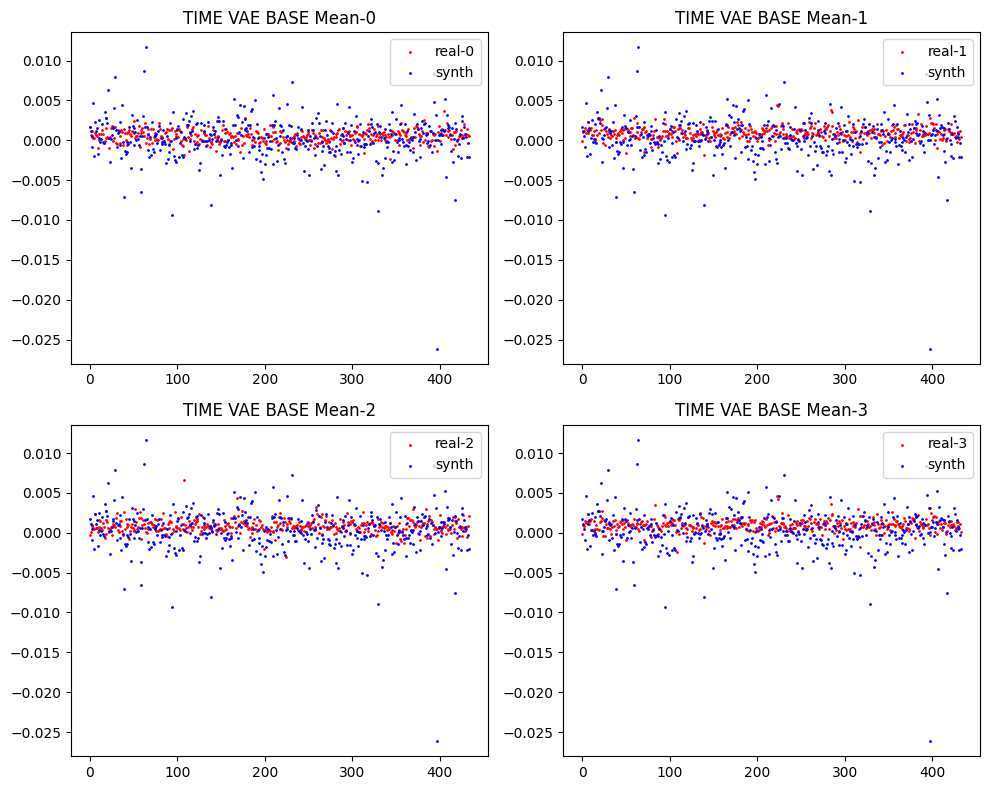

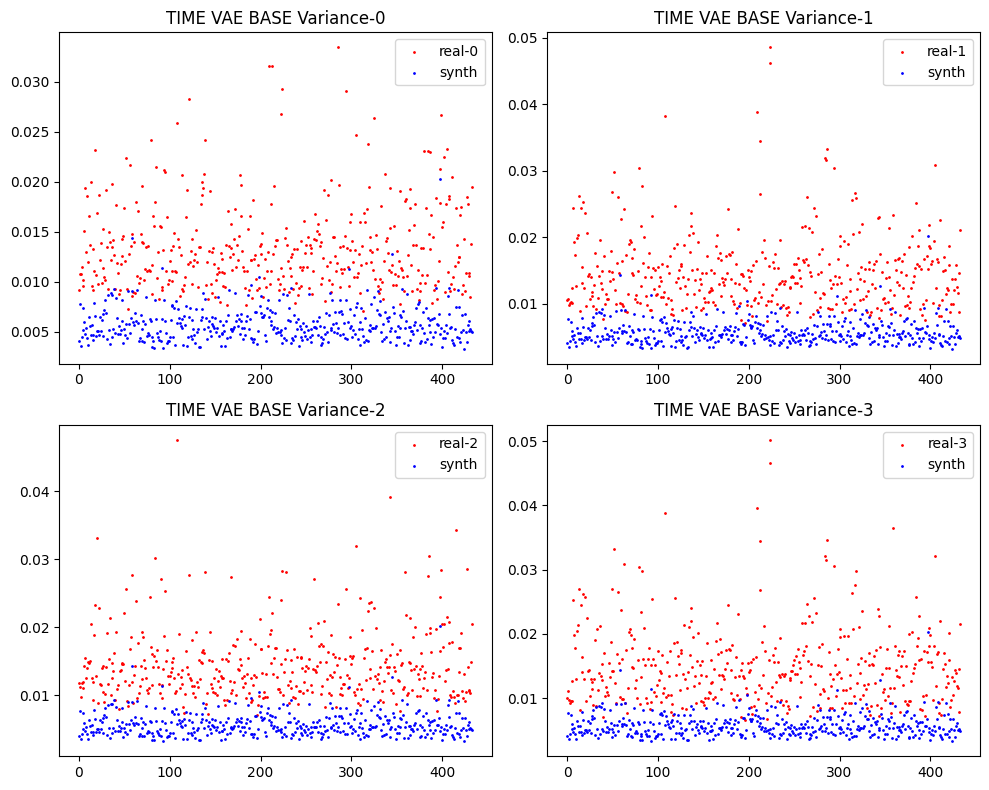

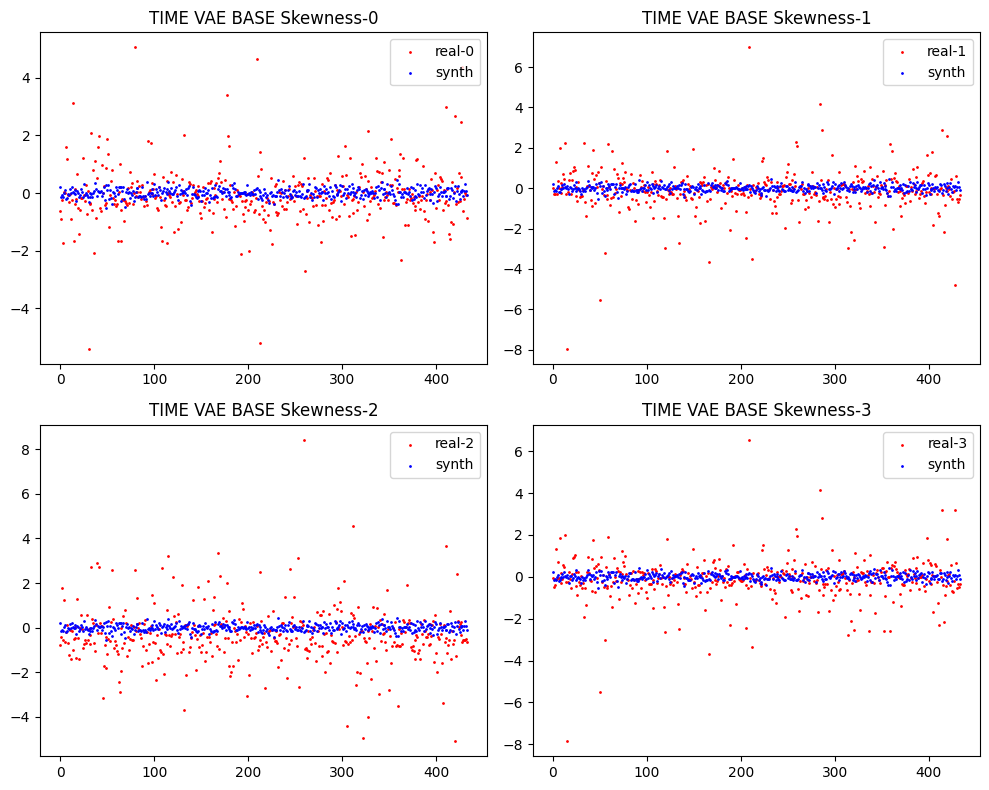

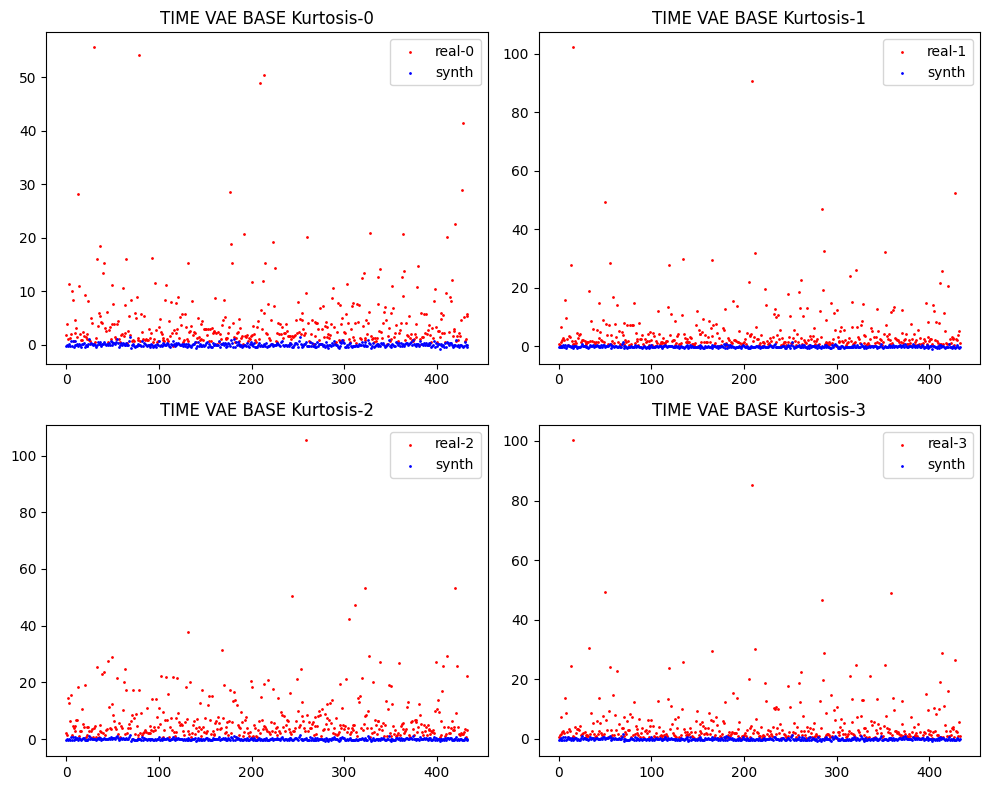

Model:  VAE Convolutional 1


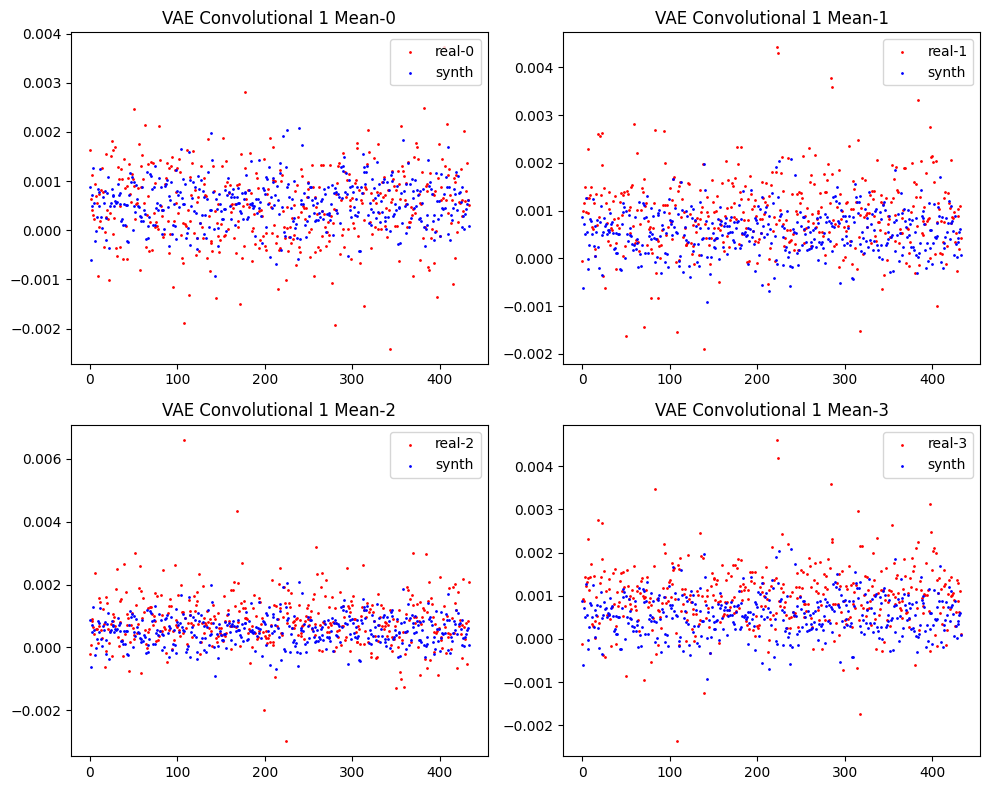

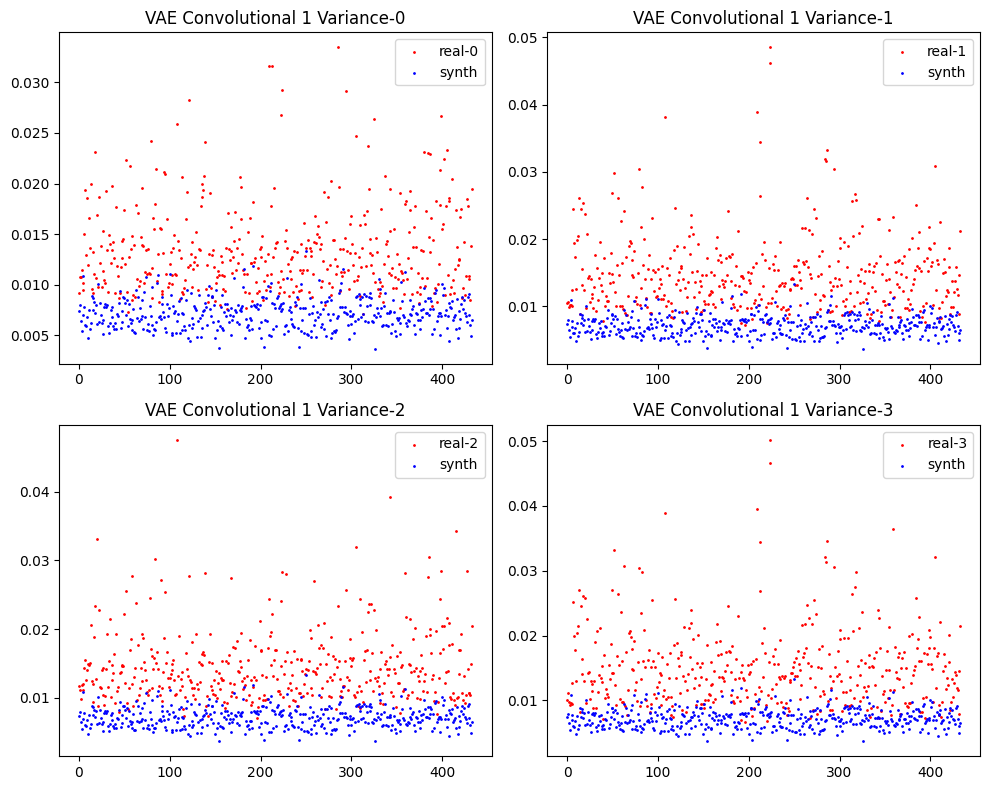

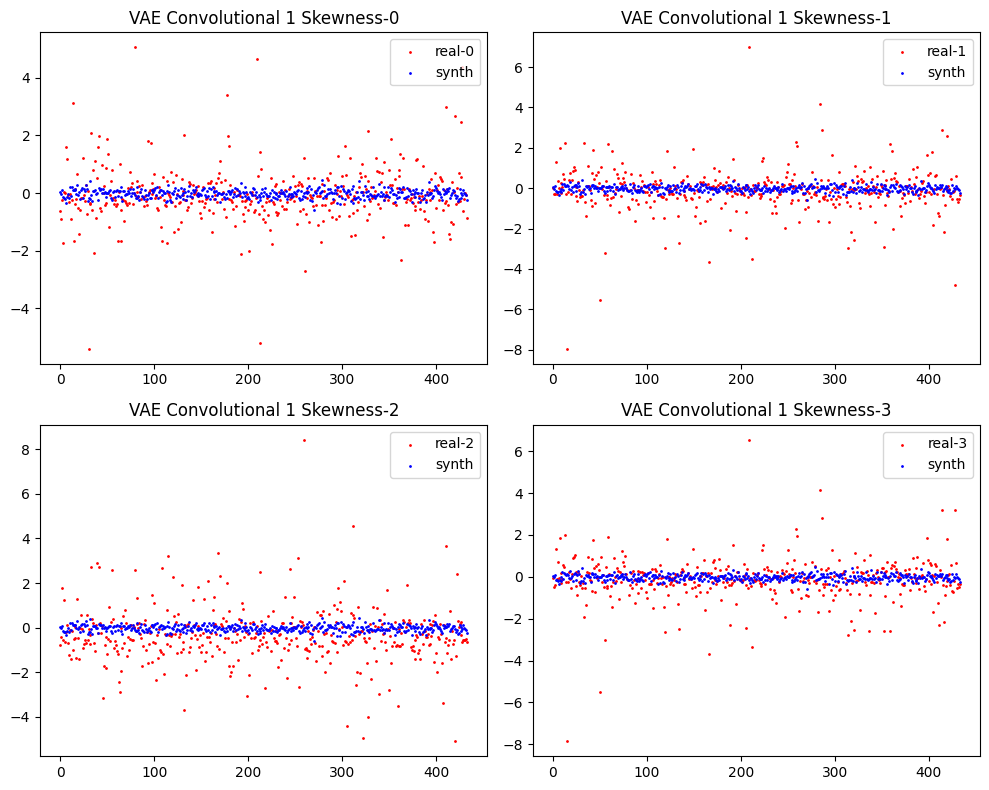

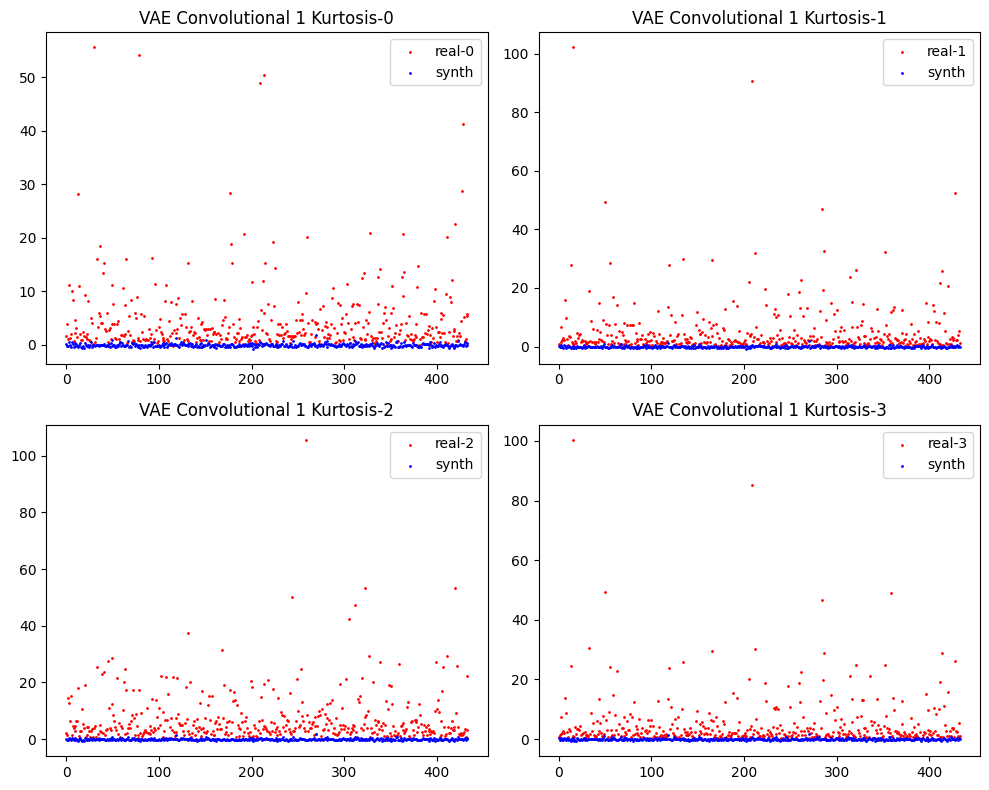

Model:  VAE Convolutional 2


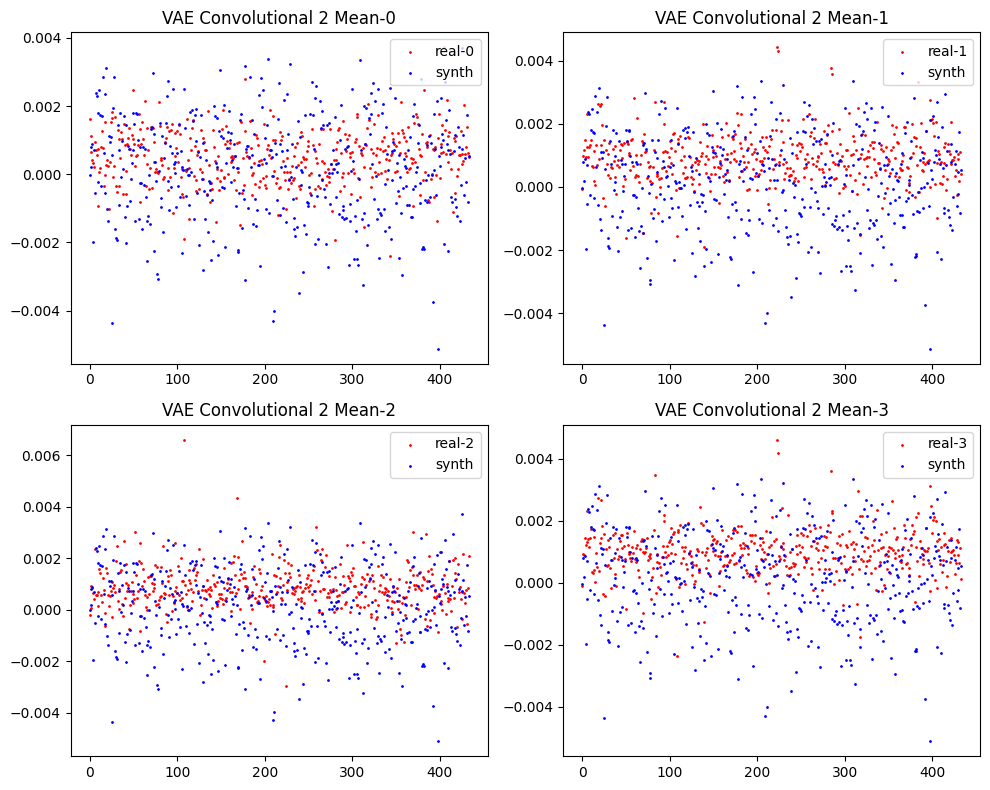

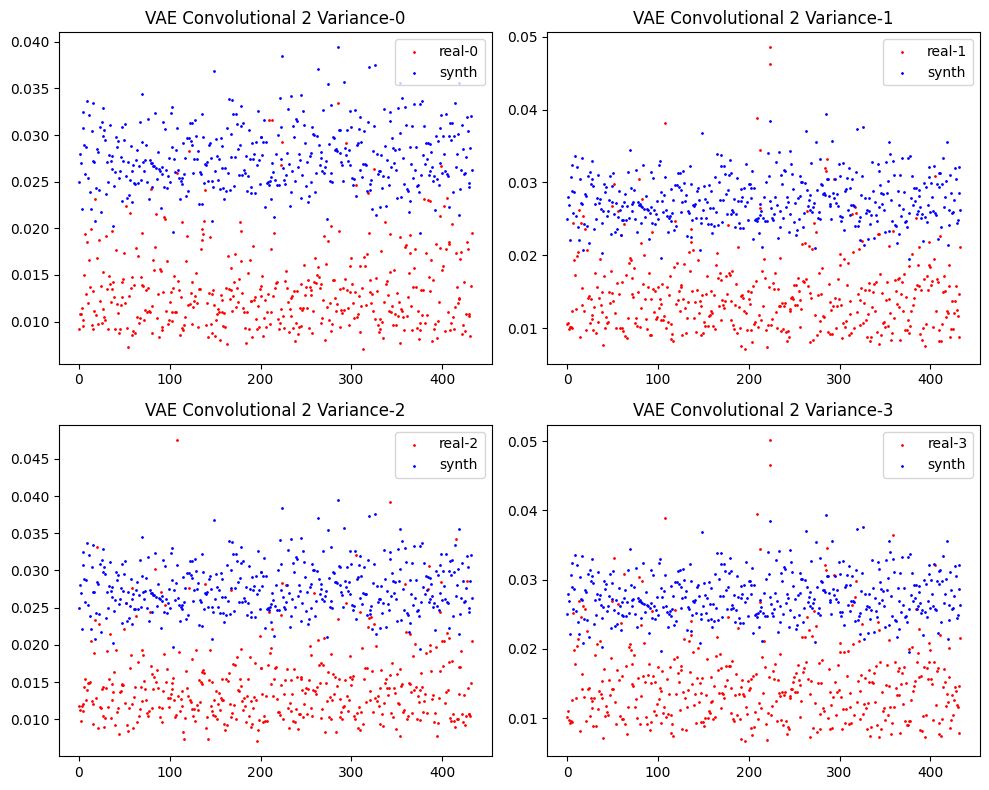

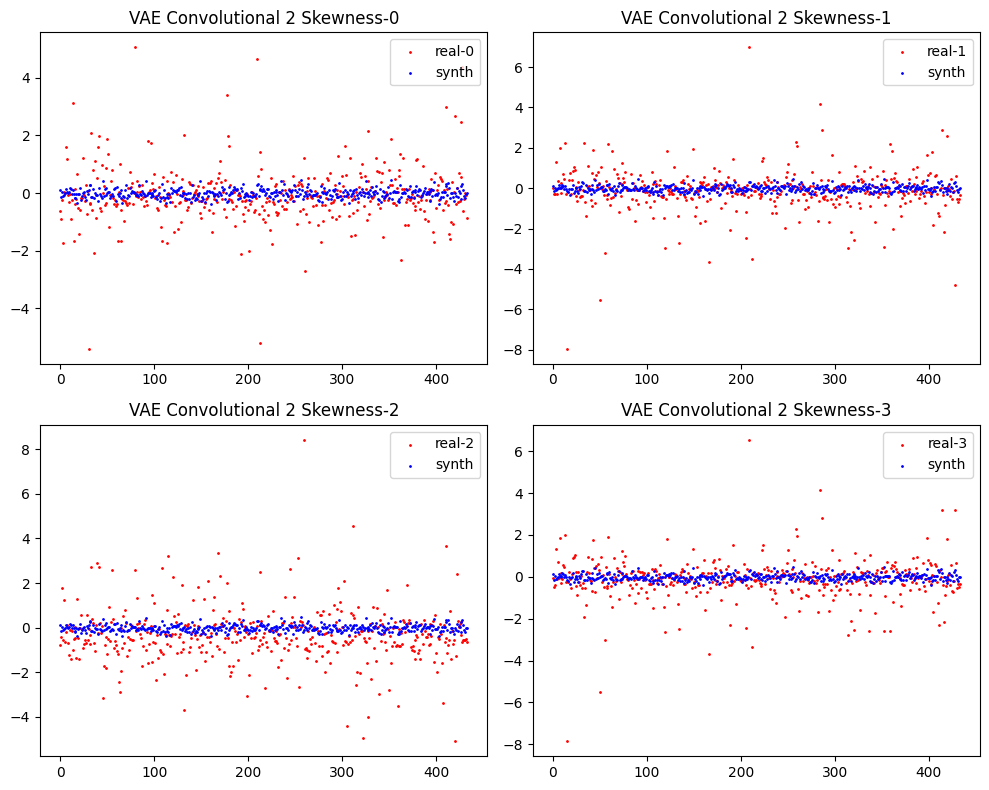

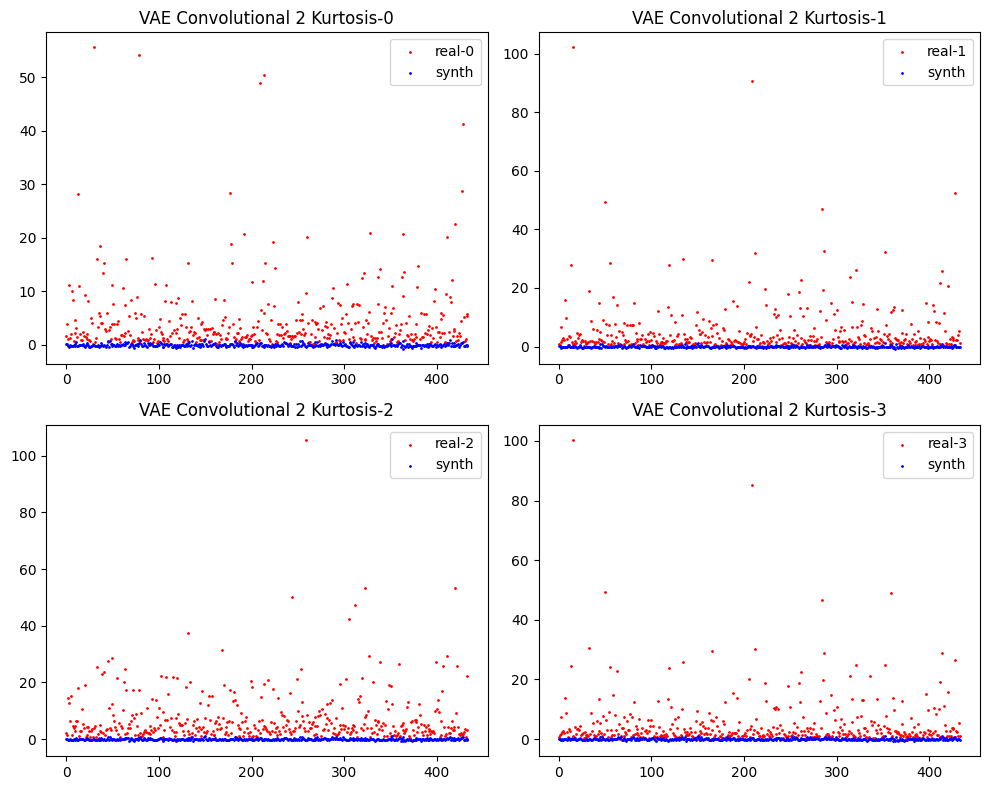

Model:  VAE Dense Layers 1


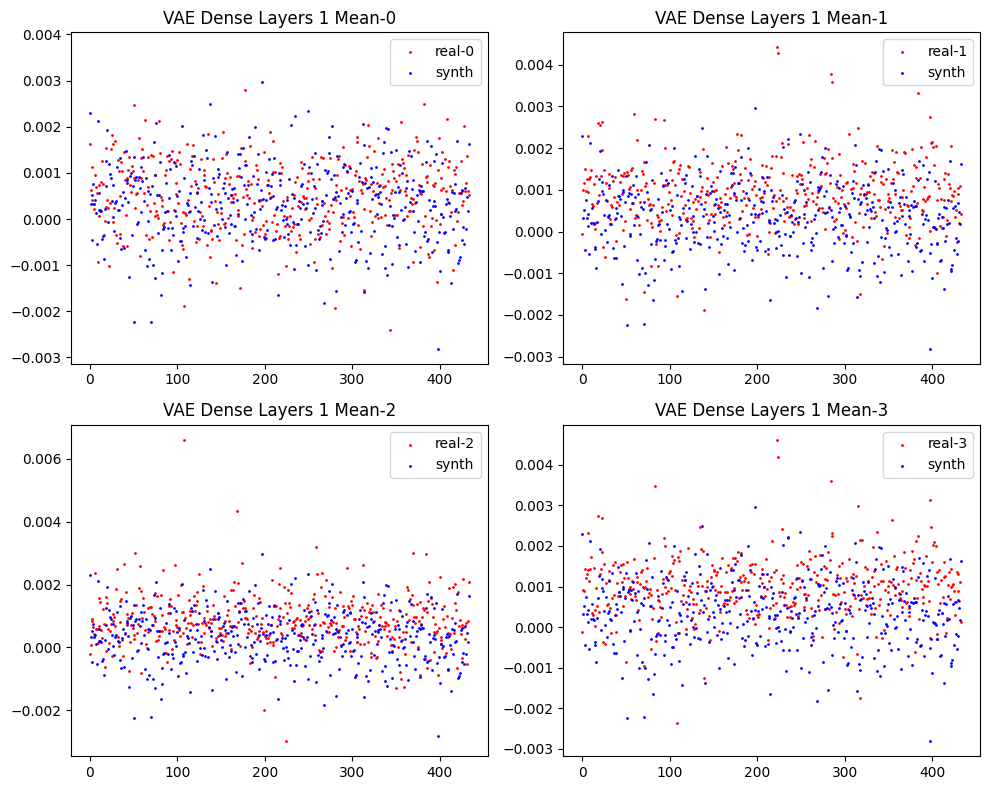

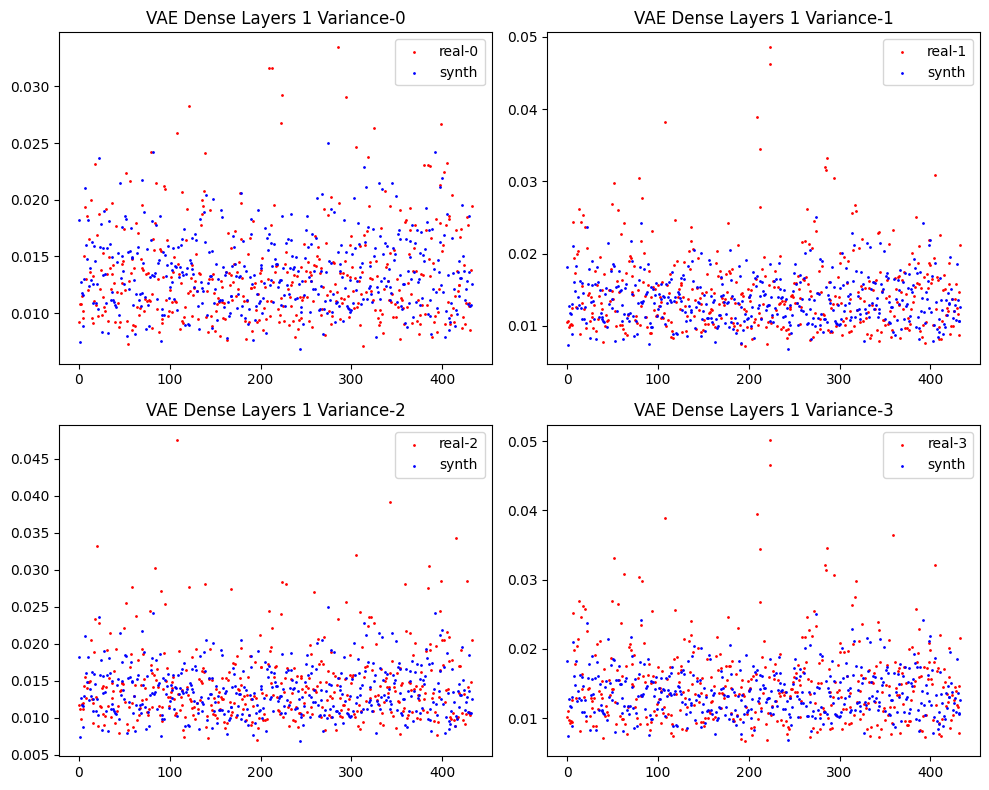

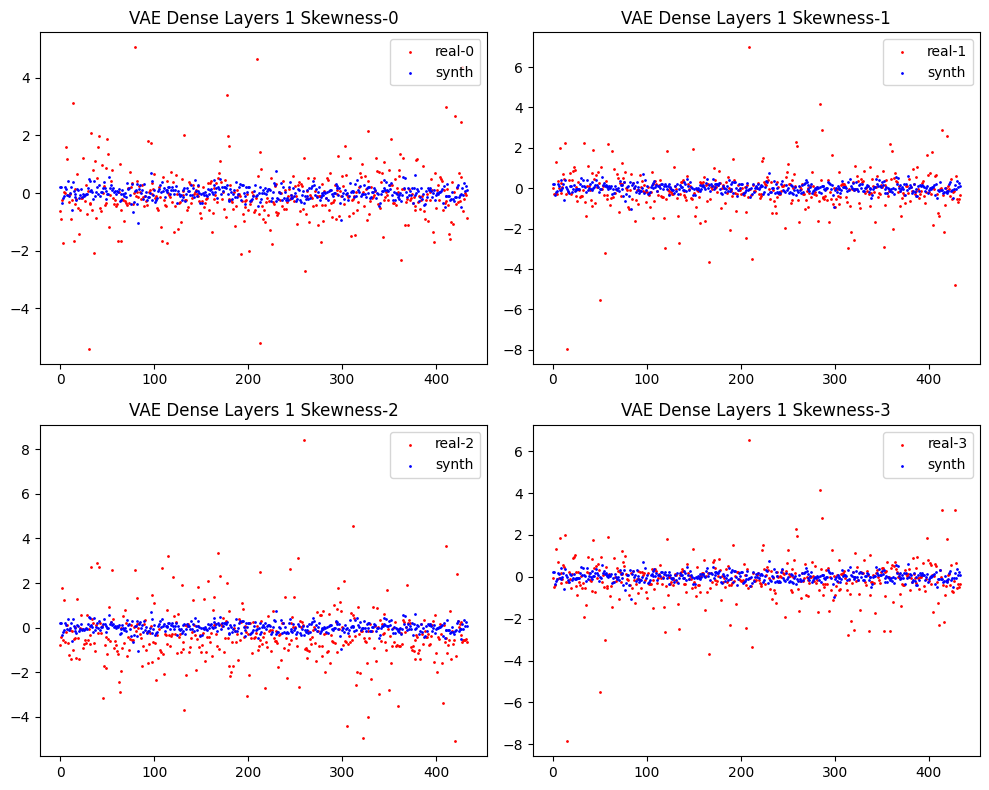

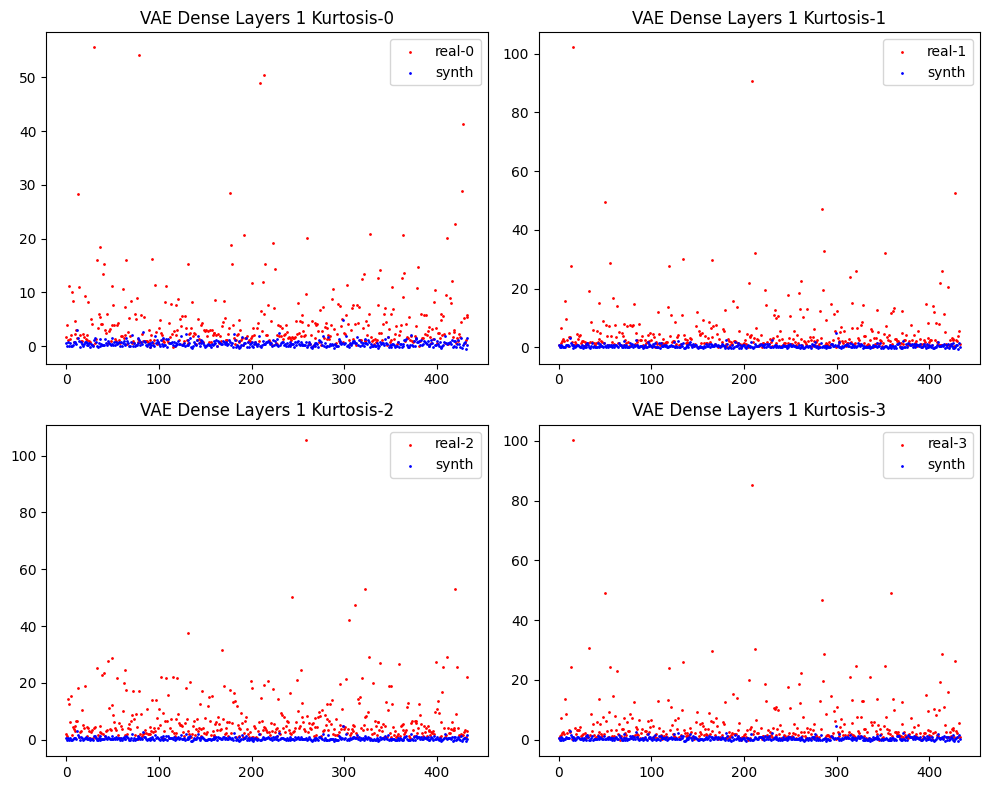

Model:  VAE Dense Layers 2


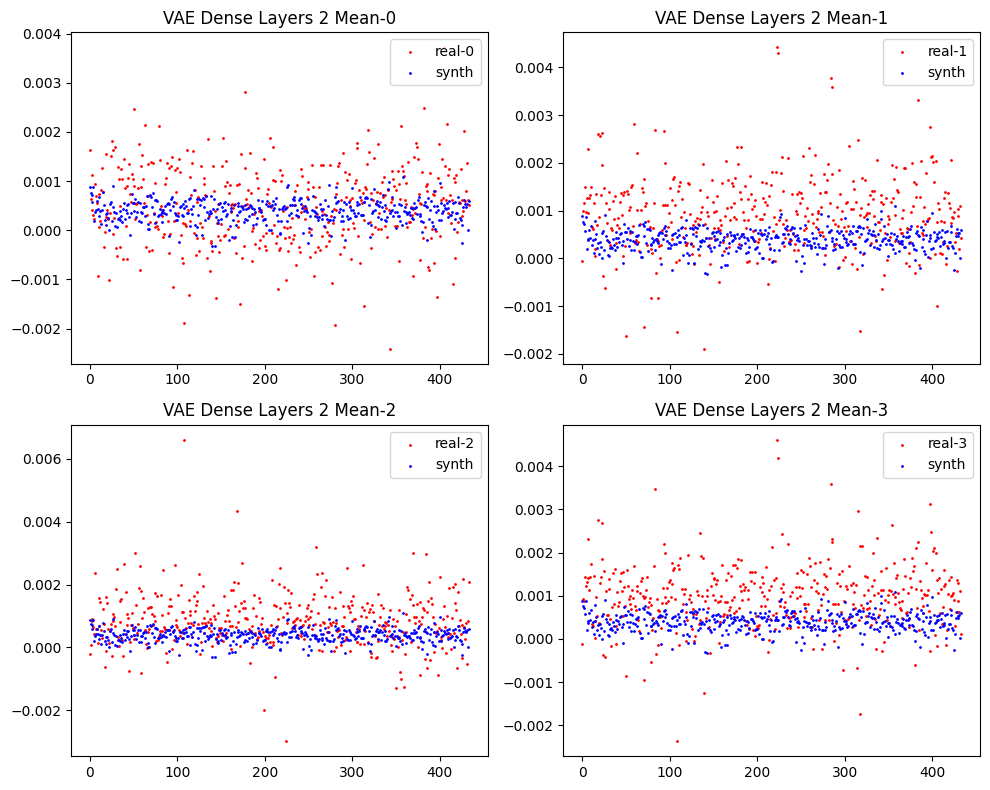

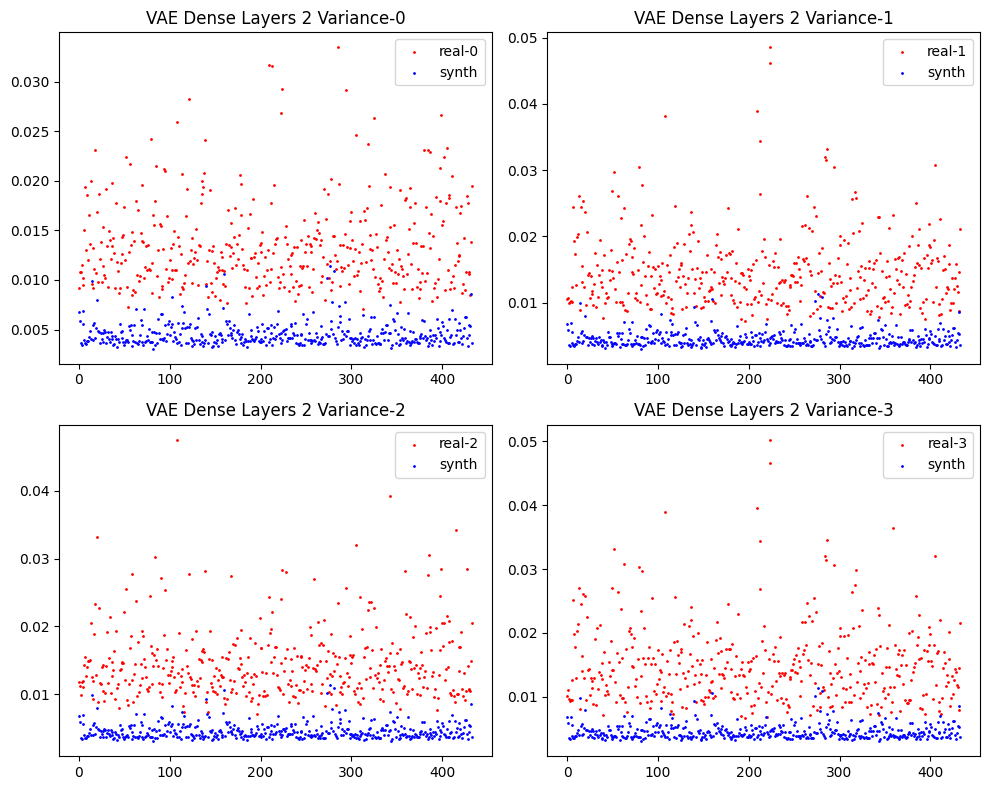

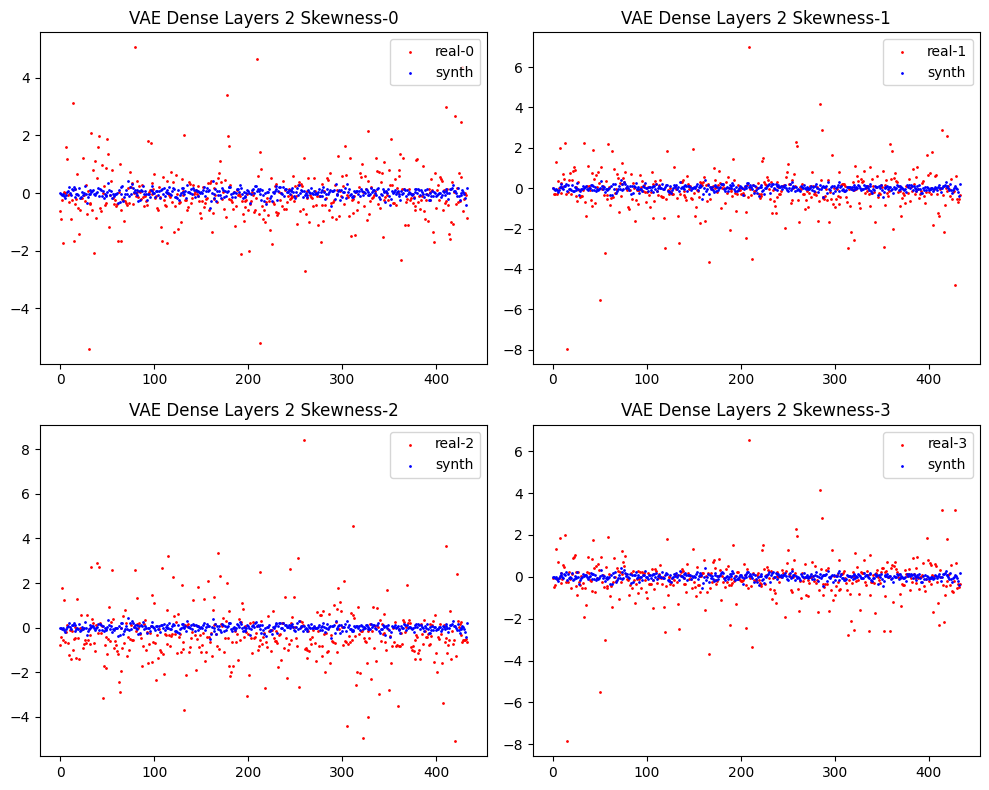

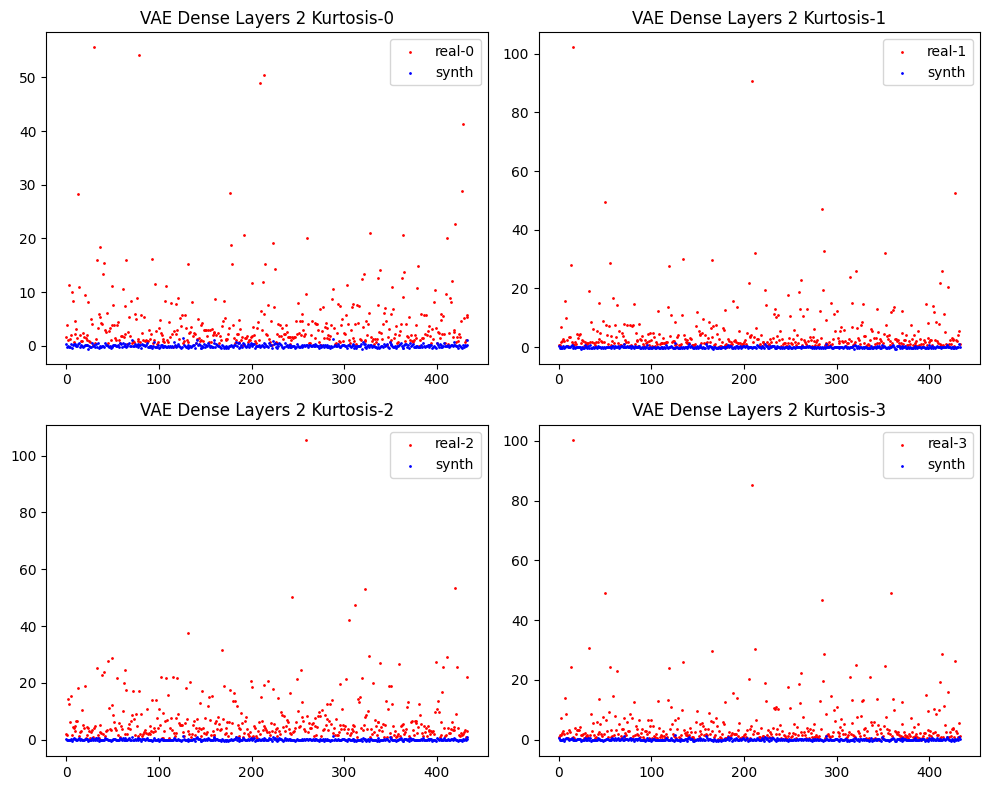

Model:  VQ-VAE Convolutional


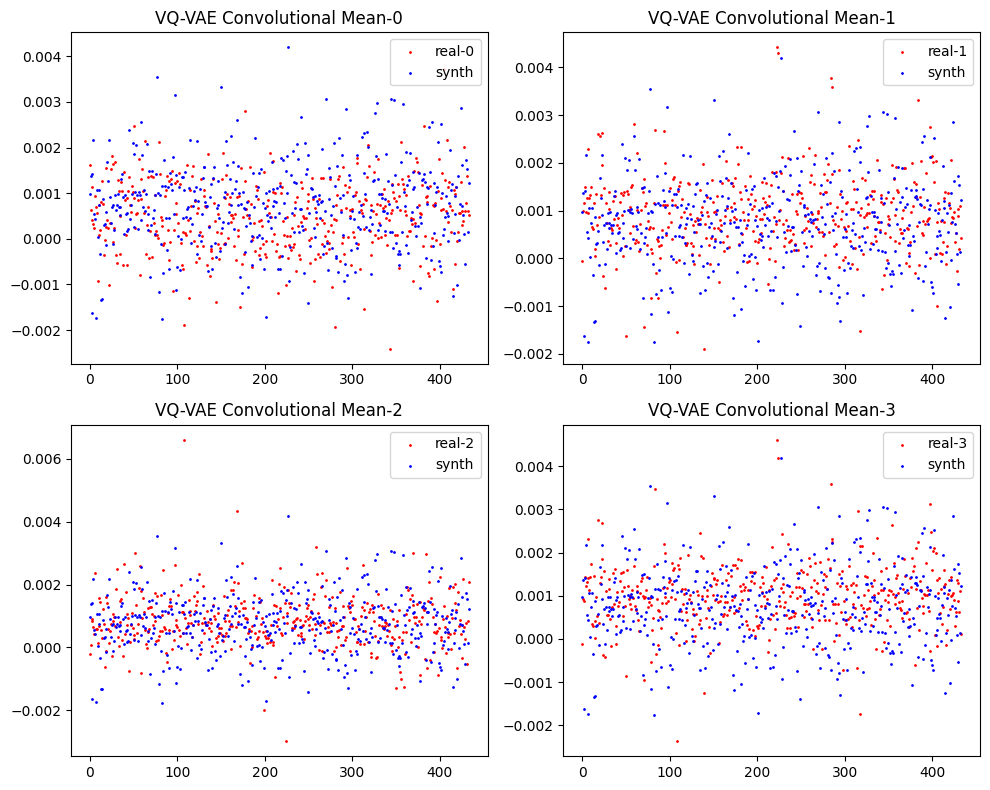

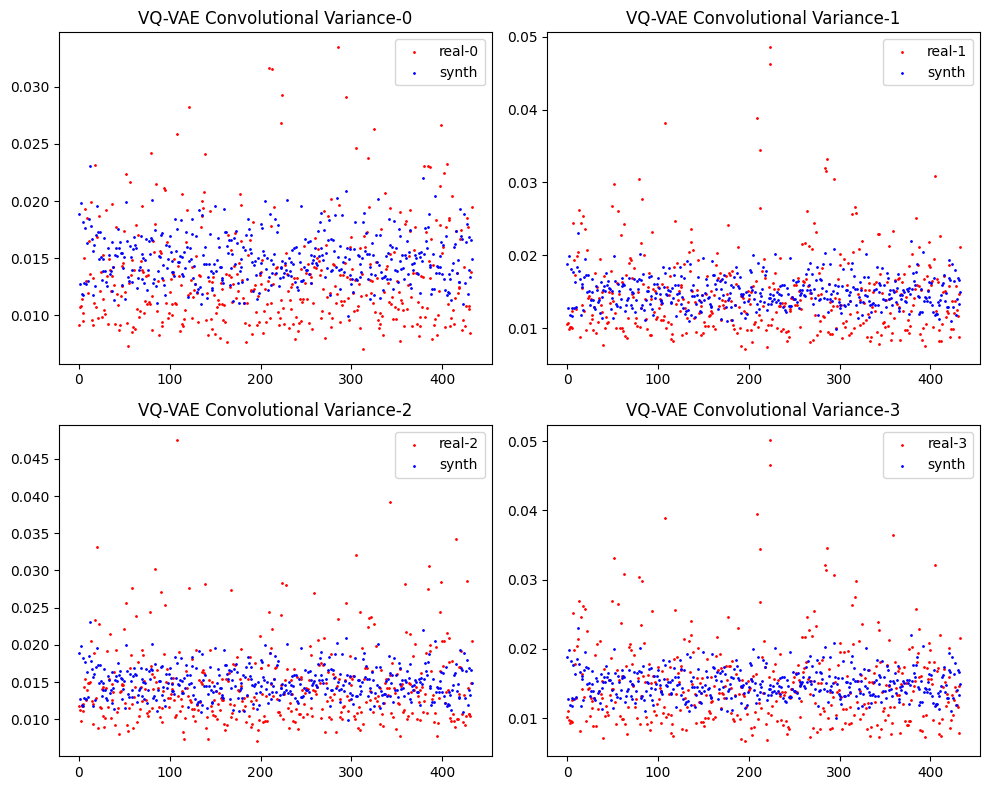

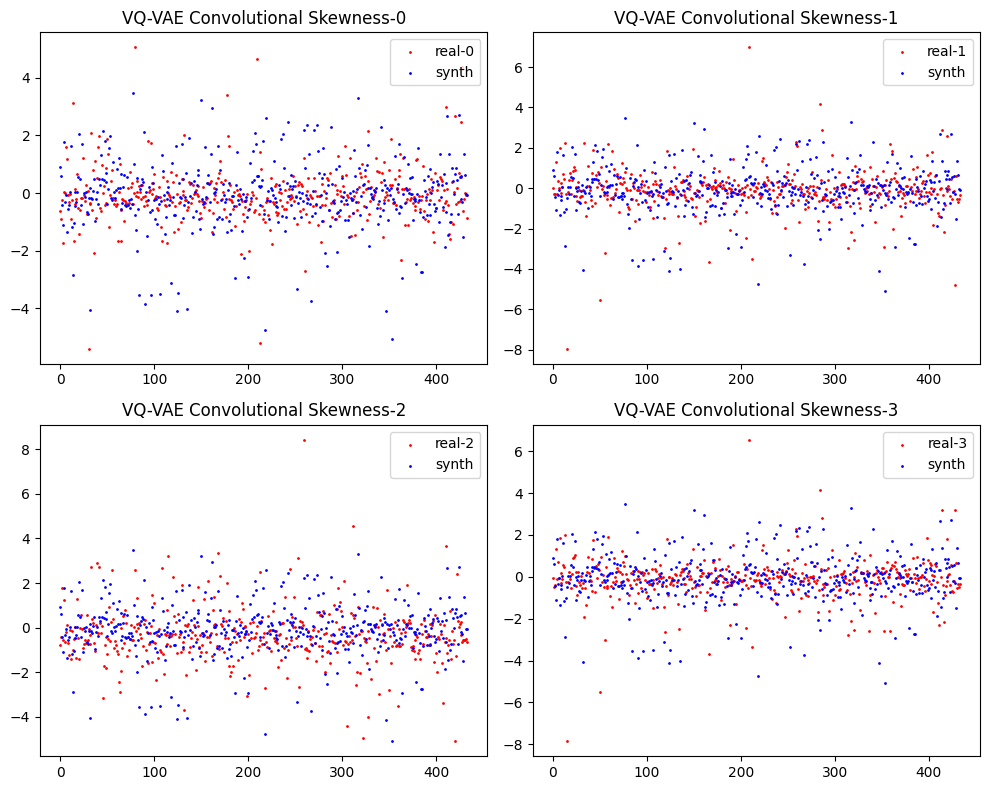

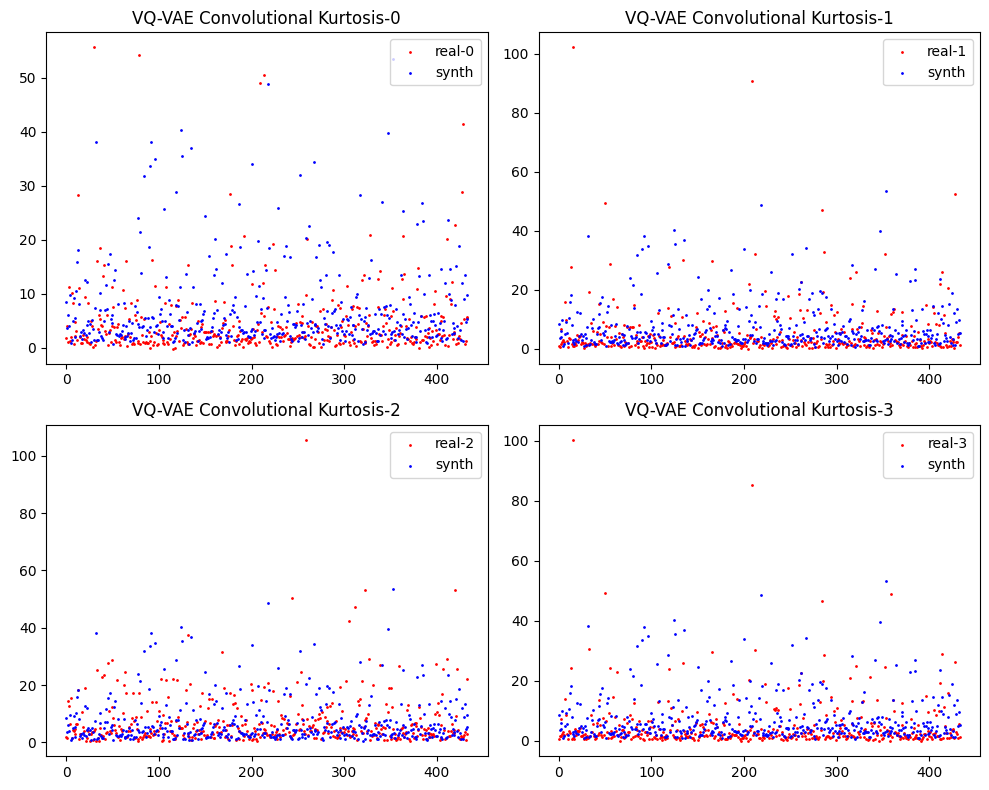

Model:  VQ-VAE Dense Layers


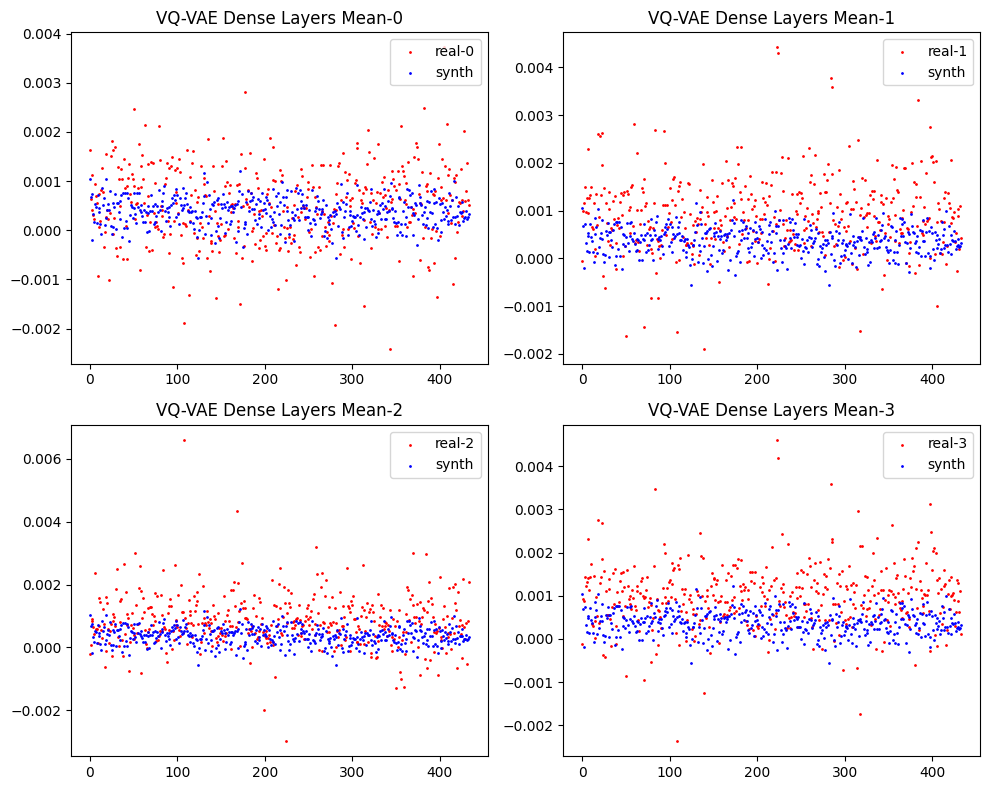

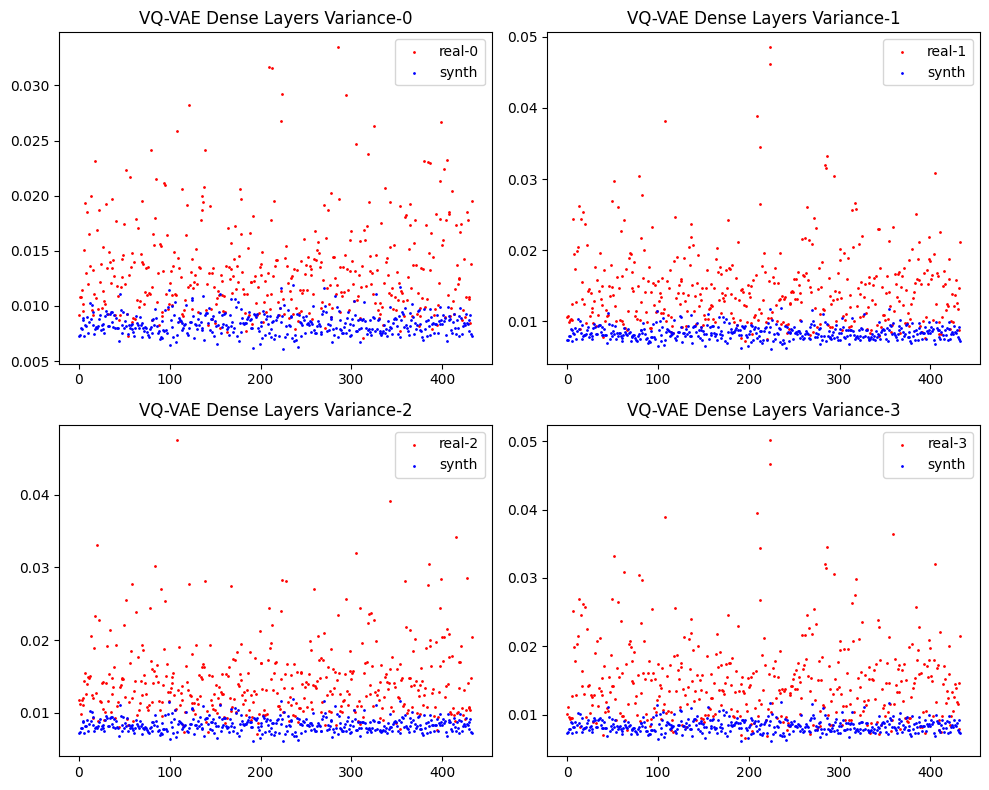

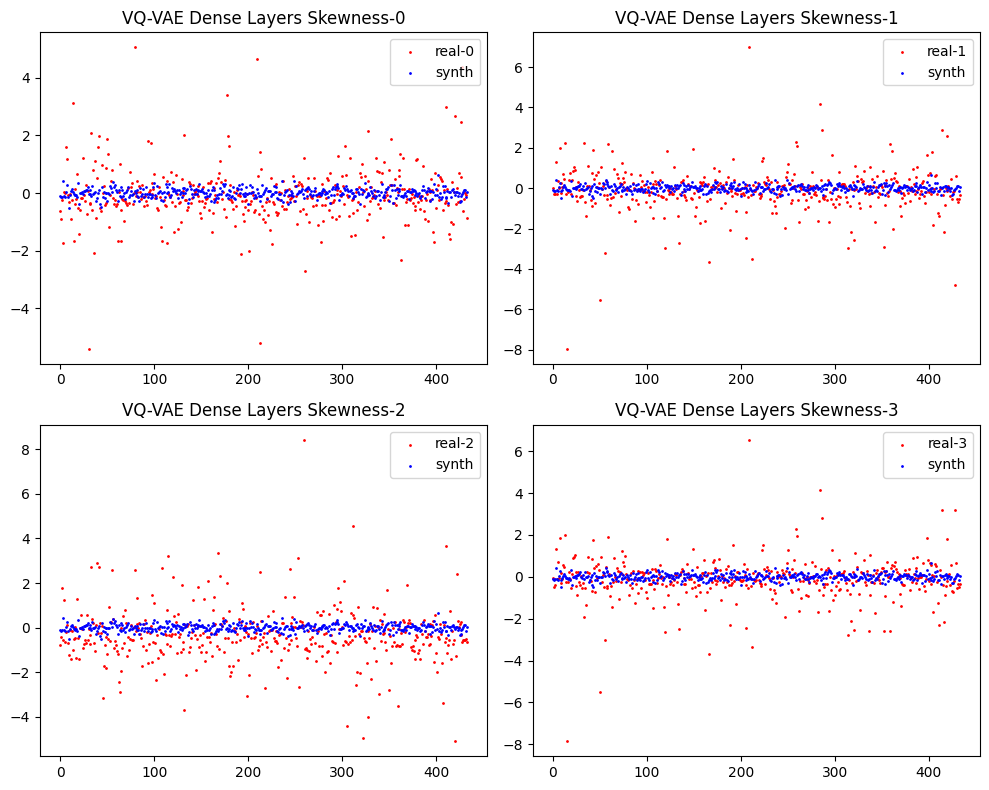

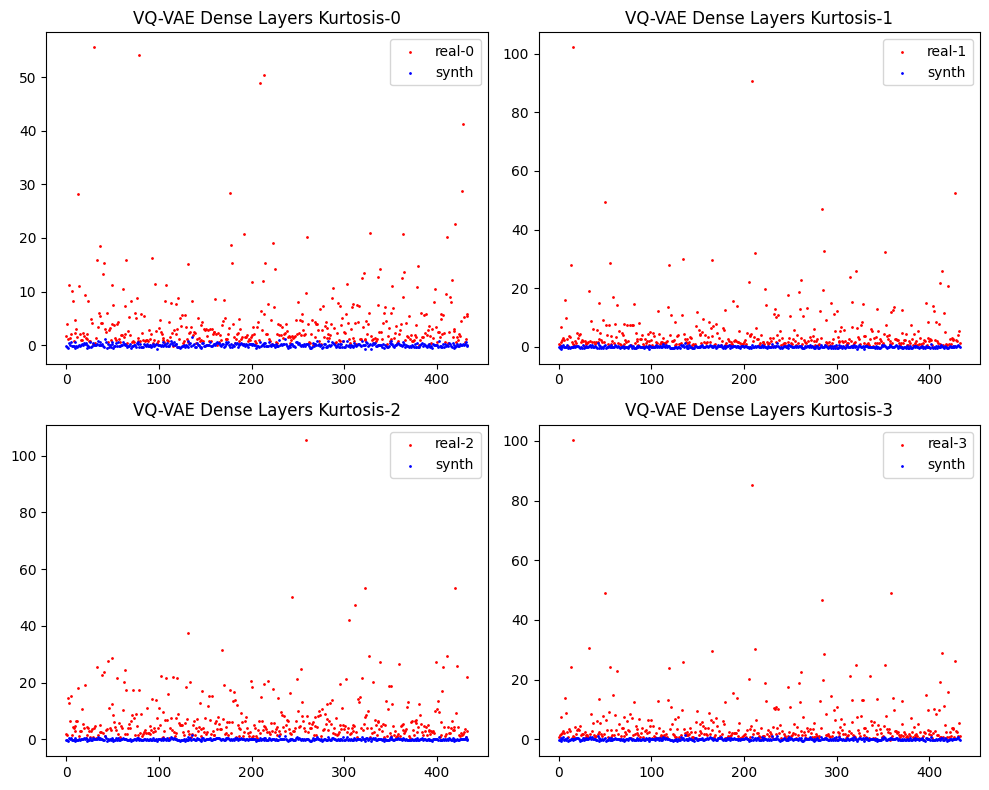

In [31]:
moments = ['Mean', 'Variance', 'Skewness', 'Kurtosis']
x = list(range(stocks))
for model in generated.keys():
    print('Model: ', model)
    for moment in moments:
        fig, axes = plt.subplots(2,2, figsize=(10, 8)) 
        for i in range(4):
            keyd = moment + '_' + str(i)
            y = moments_data[keyd]
            axes[i // 2, i % 2].scatter(x, y, c='red', s=1) 

            keyd = moment + '_' + model
            y = moments_generated[keyd]
            axes[i // 2, i % 2].scatter(x, y, c='blue', s=1)
            axes[i // 2, i % 2].legend(('real-' + str(i), 'synth'), loc='upper right')
            axes[i // 2, i % 2].set_title(model + ' ' + moment + '-' + str(i))
        
        plt.tight_layout()  # To prevent overlapping of subplots
        plt.show()
        file_name = plots + model+ '/'+model + '_' + moment + '.png'
        file_name = file_name.replace(' ', '_')
        file_name = file_name.replace('-', '_')
        file_name = file_name.lower()
        fig.savefig(file_name, dpi=fig.dpi)
        plt.close(fig)



Model:  TIME VAE BASE


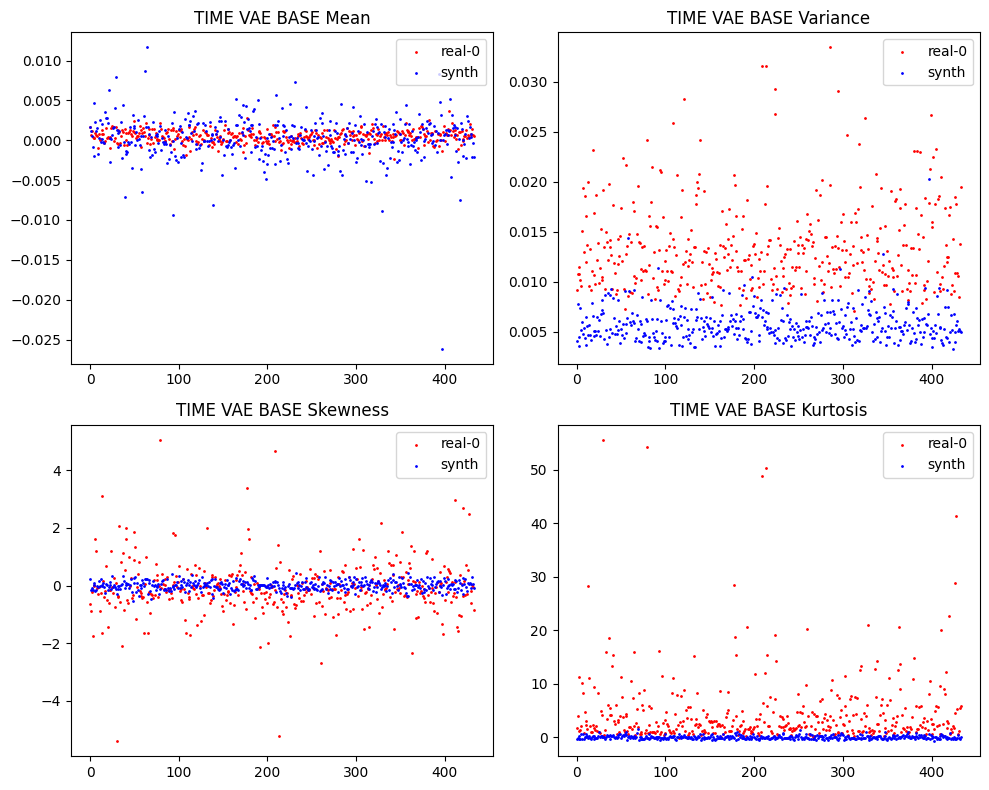

Model:  VAE Convolutional 1


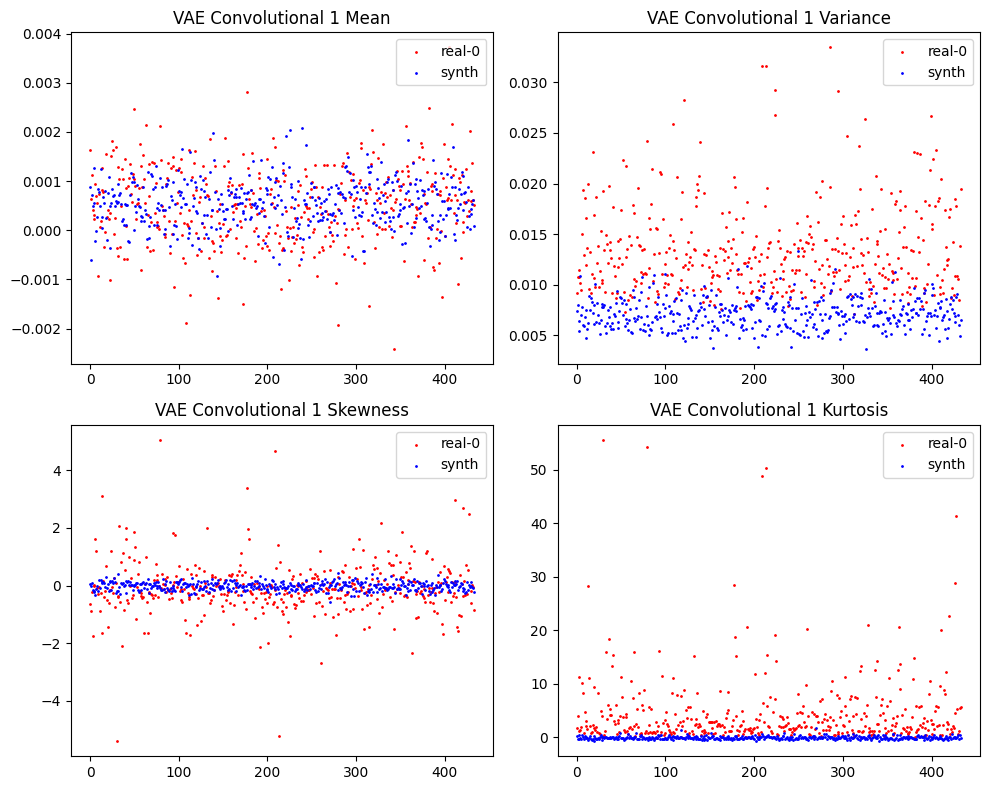

Model:  VAE Convolutional 2


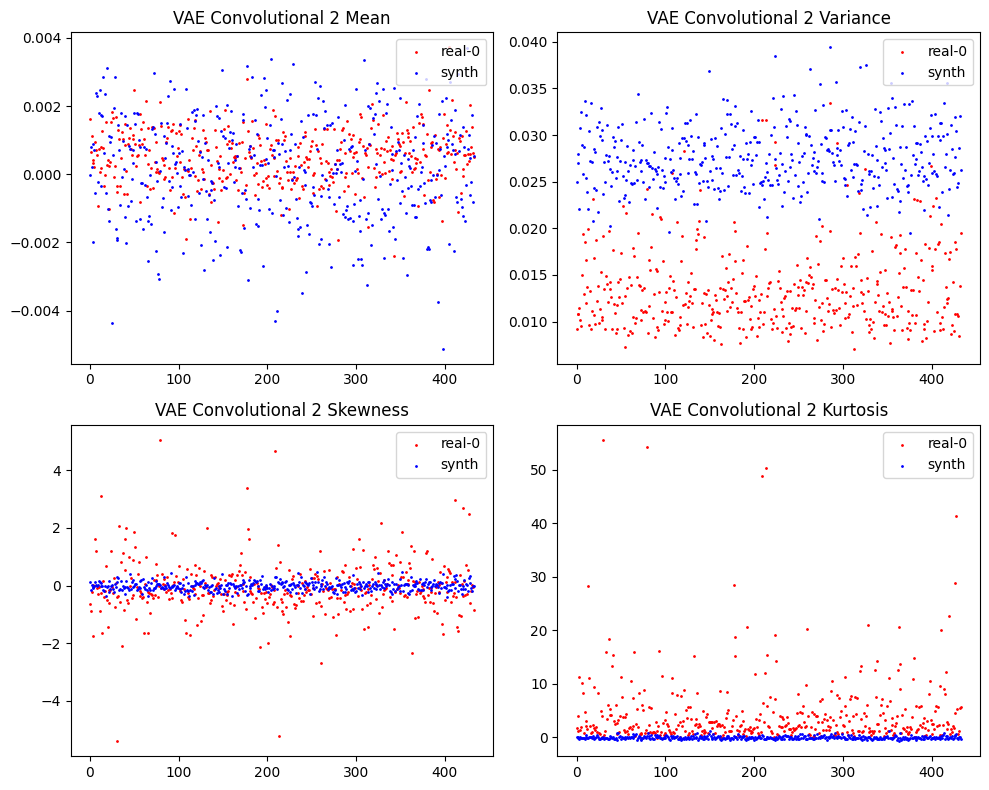

Model:  VAE Dense Layers 1


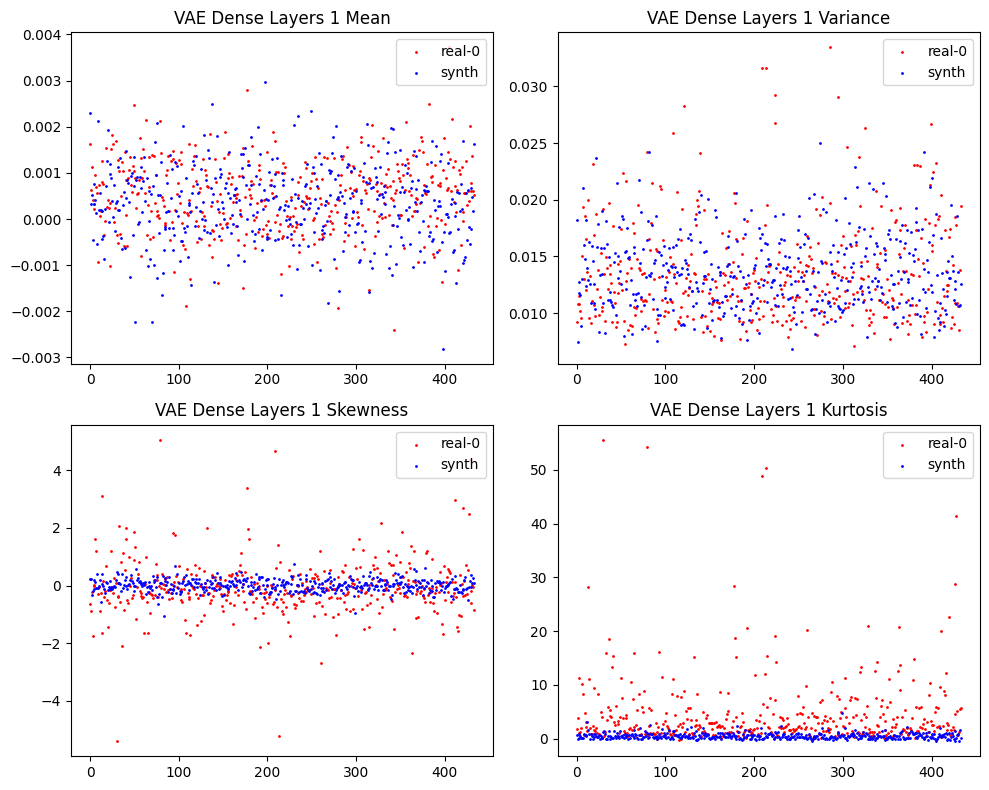

Model:  VAE Dense Layers 2


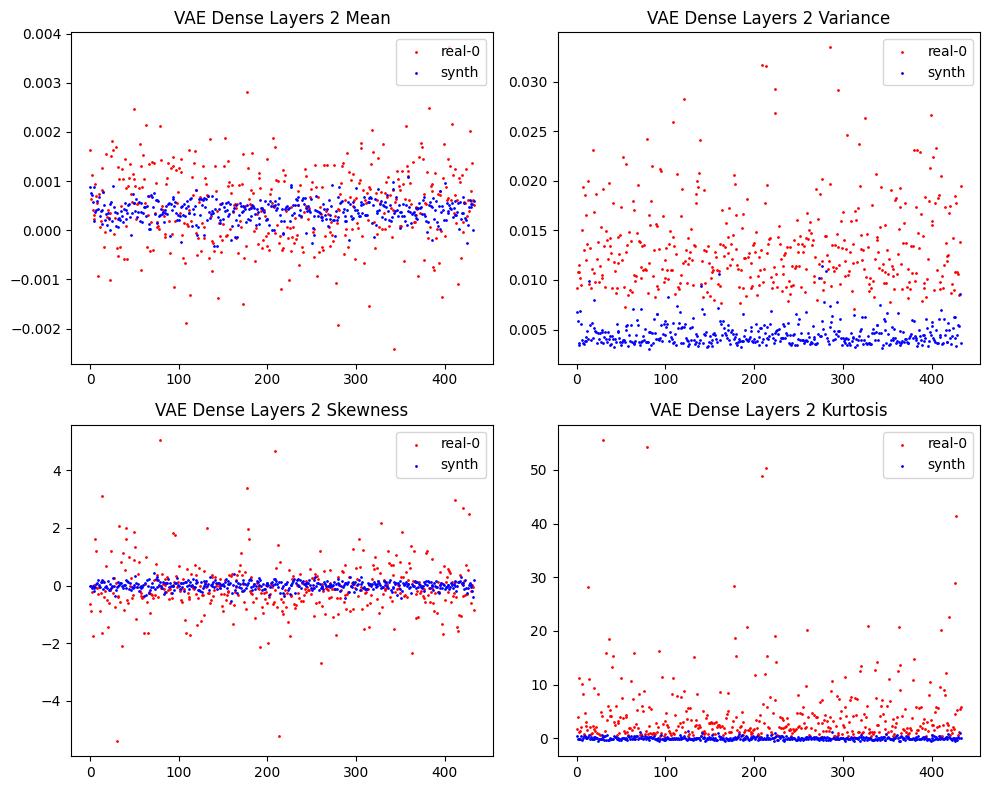

Model:  VQ-VAE Convolutional


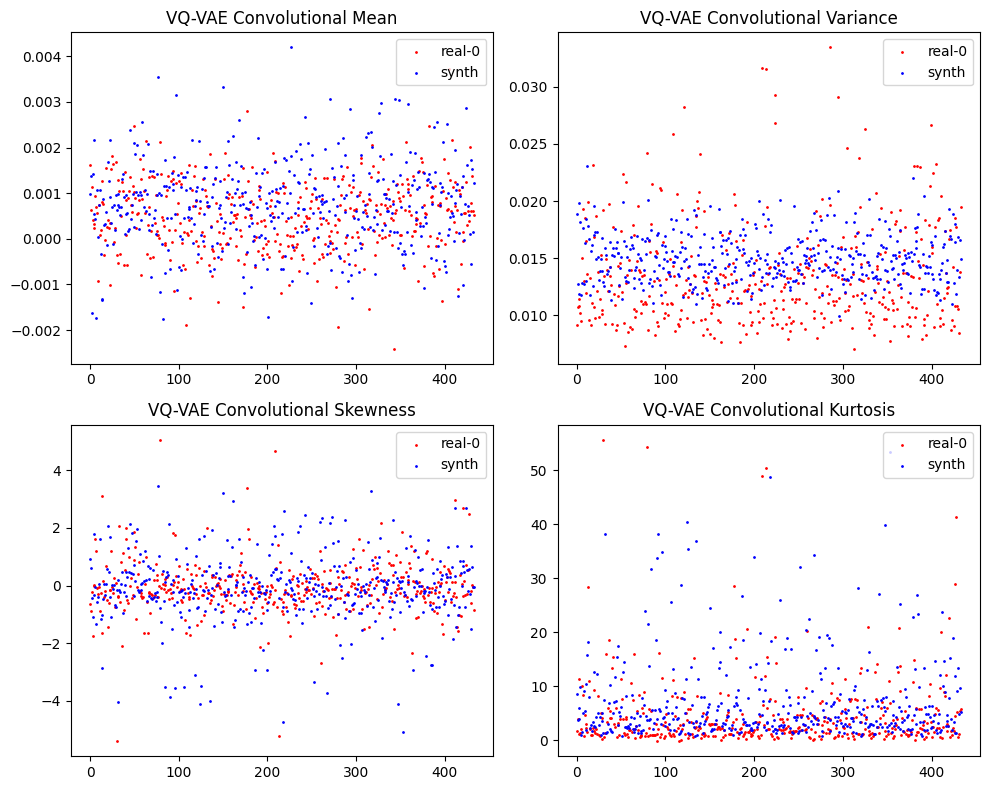

Model:  VQ-VAE Dense Layers


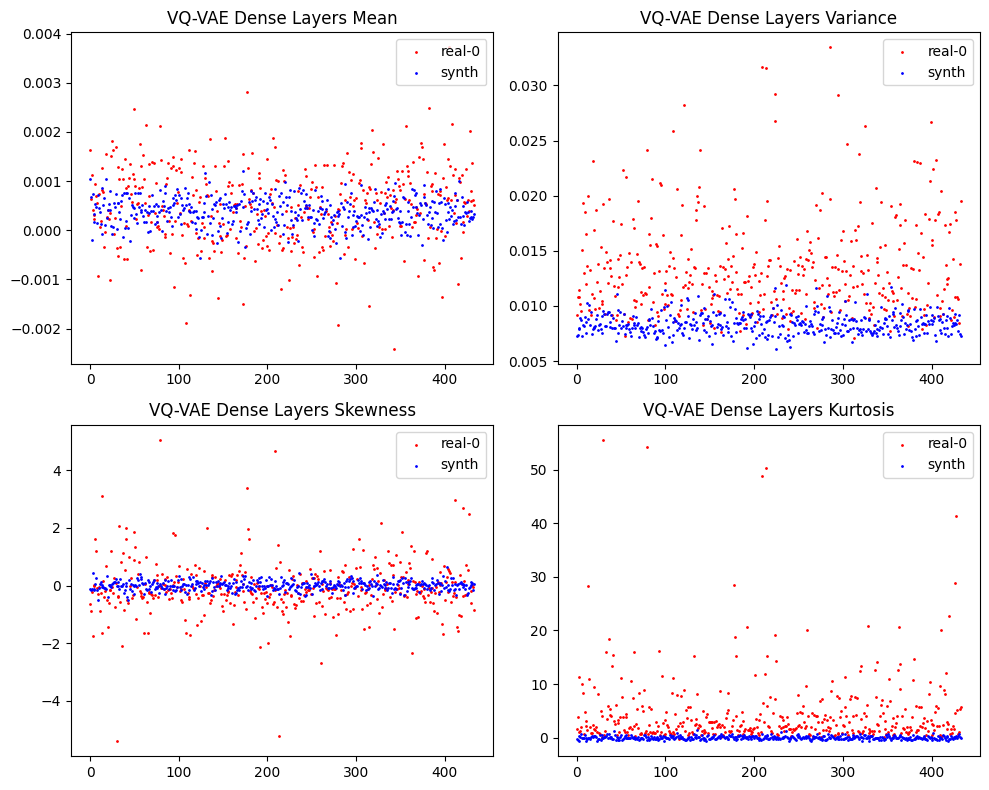

In [32]:
moments = ['Mean', 'Variance', 'Skewness', 'Kurtosis']
x = list(range(stocks))
i=0
for model in generated.keys():
    print('Model: ', model)
    fig, axes = plt.subplots(2,2, figsize=(10, 8)) 
    for i, moment in enumerate(moments):
        
        # for i in range(4):
        keyd = moment + '_' + str(0)
        y = moments_data[keyd]
        axes[i // 2, i % 2].scatter(x, y, c='red', s=1) 

        keyd = moment + '_' + model
        y = moments_generated[keyd]
        axes[i // 2, i % 2].scatter(x, y, c='blue', s=1)
        axes[i // 2, i % 2].legend(('real-' + str(0), 'synth'), loc='upper right')
        axes[i // 2, i % 2].set_title(model + ' ' + moment )
    
    plt.tight_layout()  # To prevent overlapping of subplots
    plt.show()
    file_name = plots + model+ '/'+model + '_' + 'moments' + '.png'
    file_name = file_name.replace(' ', '_')
    file_name = file_name.replace('-', '_')
    file_name = file_name.lower()
    fig.savefig(file_name, dpi=fig.dpi)
    plt.close(fig)

# Autocorrelation plot

In [33]:
real_dir = 'plots/real_data/'

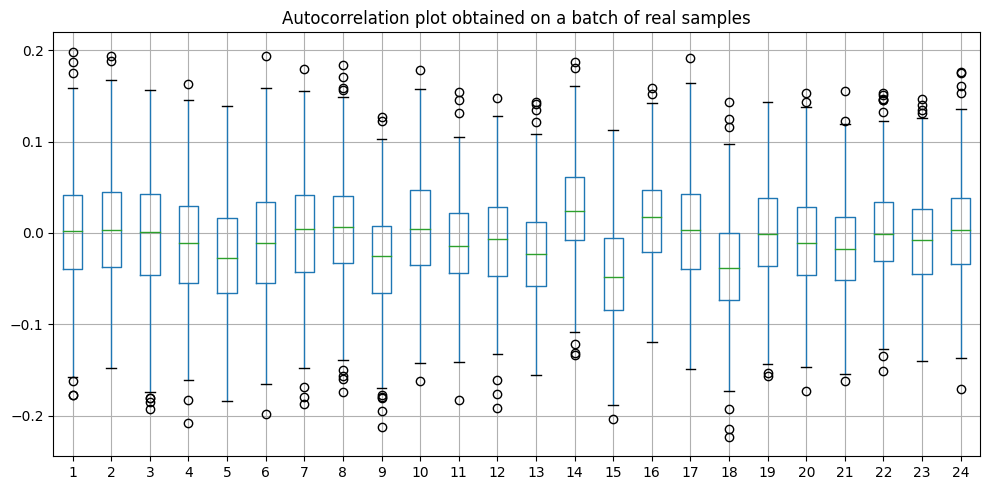

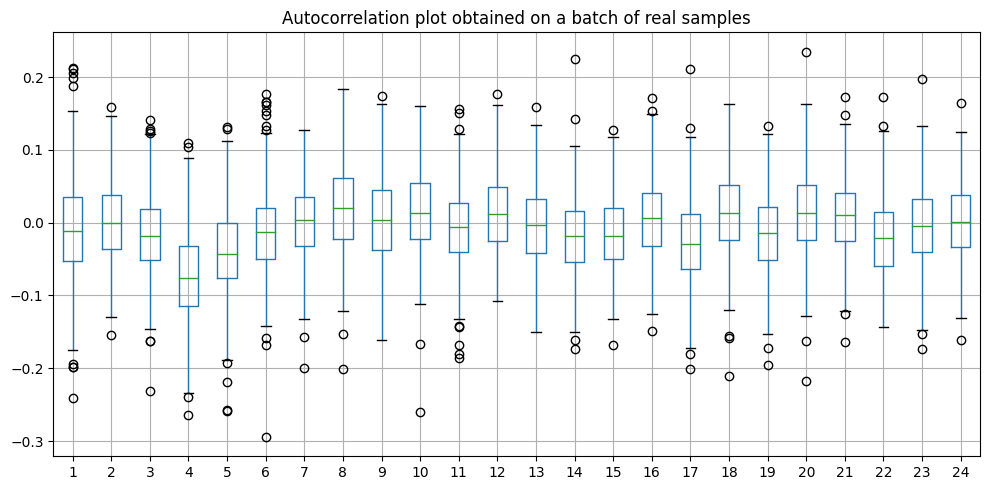

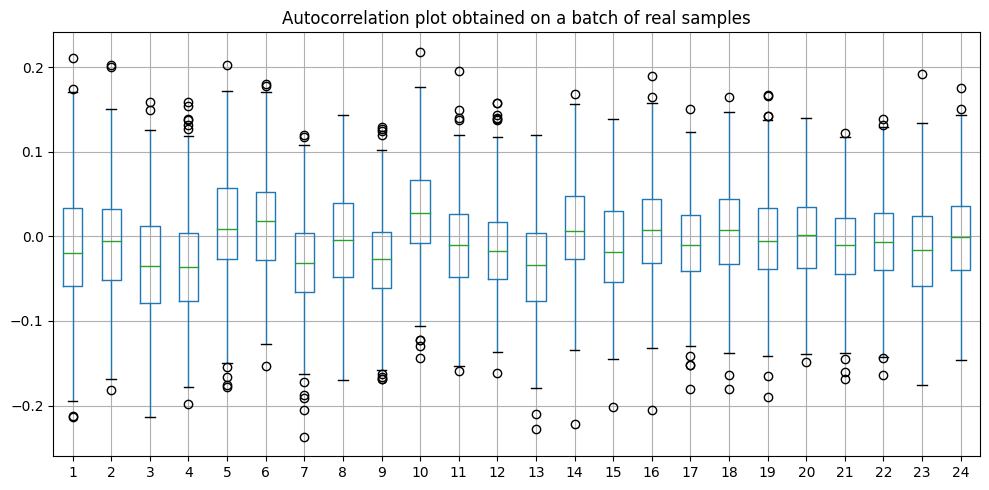

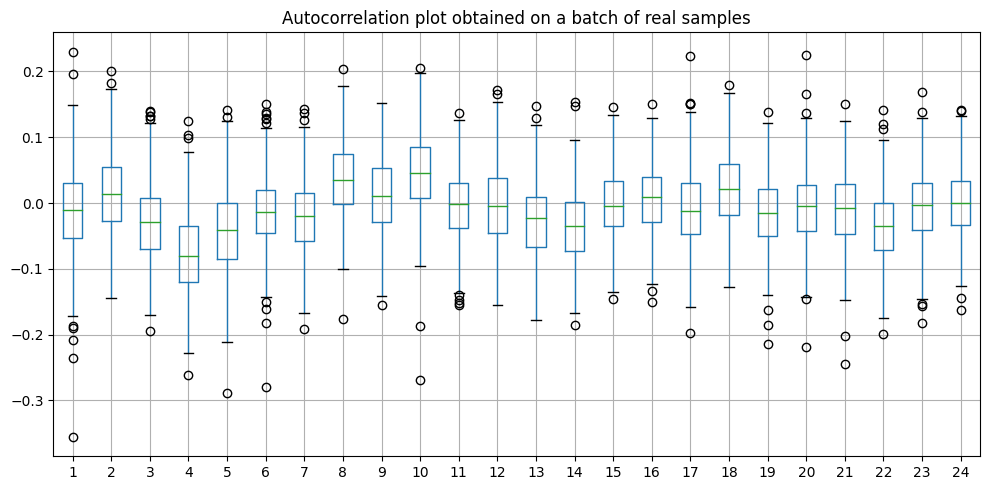

In [43]:
title = 'Autocorrelation plot obtained on a batch of real samples'
for i, batch in enumerate(data_eval): 
    df = acf_batch(batch)
    fig = plt.figure(figsize=(10, 5))
    bp = df.boxplot()
    plt.title(title)
    plt.tight_layout()
    plt.show()
    file_name = real_dir + 'autocorr' + str(i) + '.png'
    fig.savefig(file_name, dpi=fig.dpi)
    plt.close(fig)


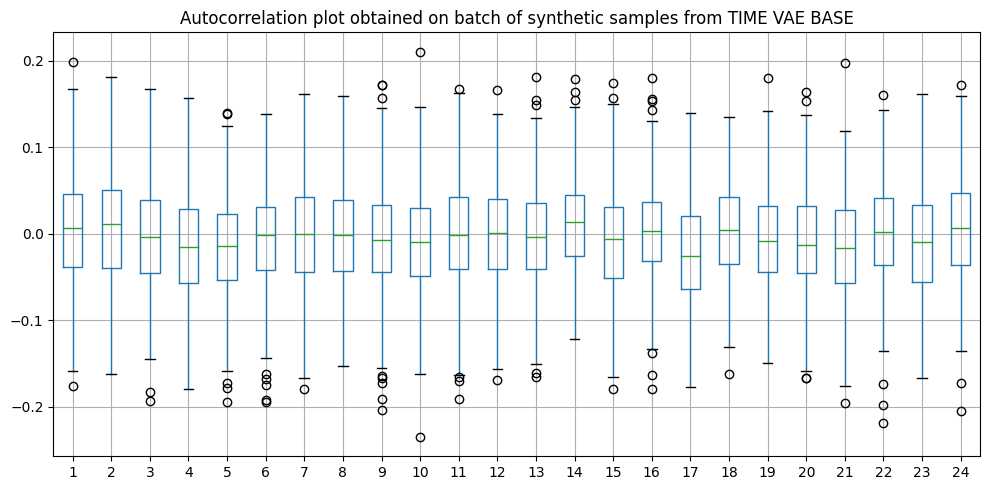

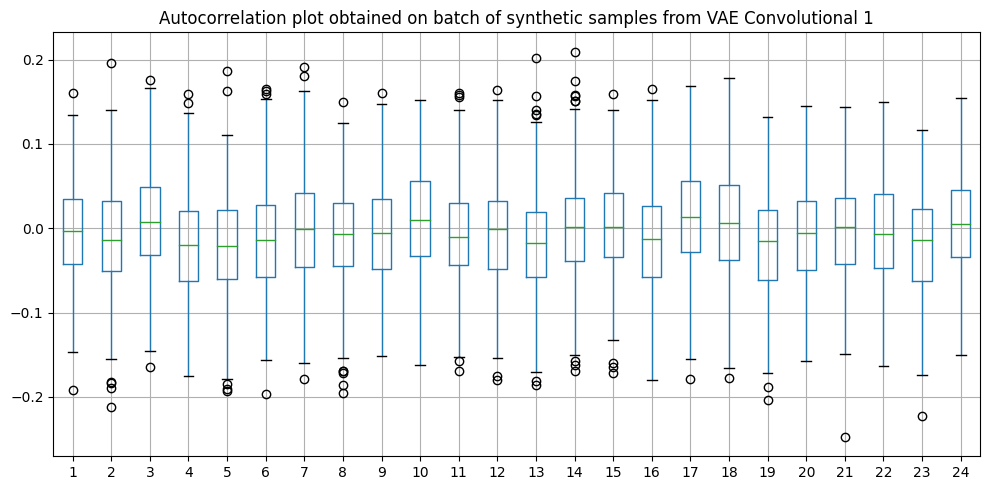

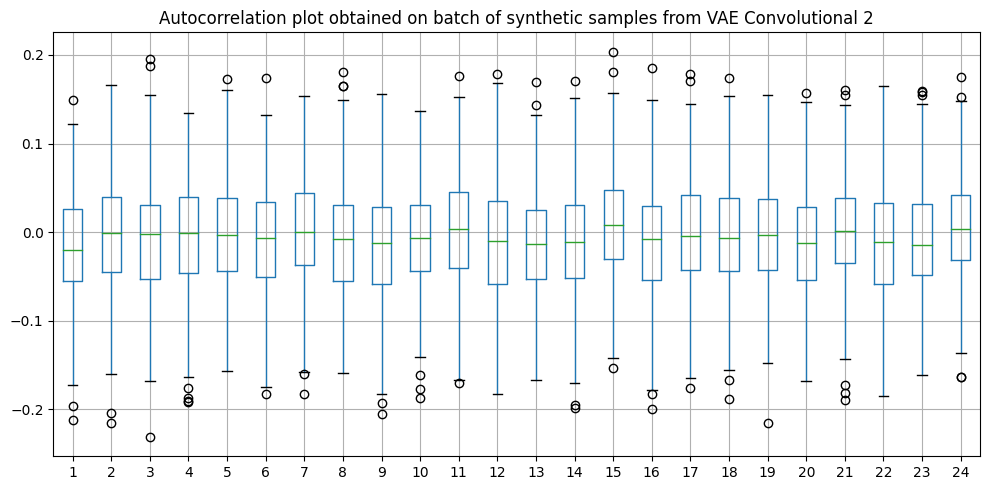

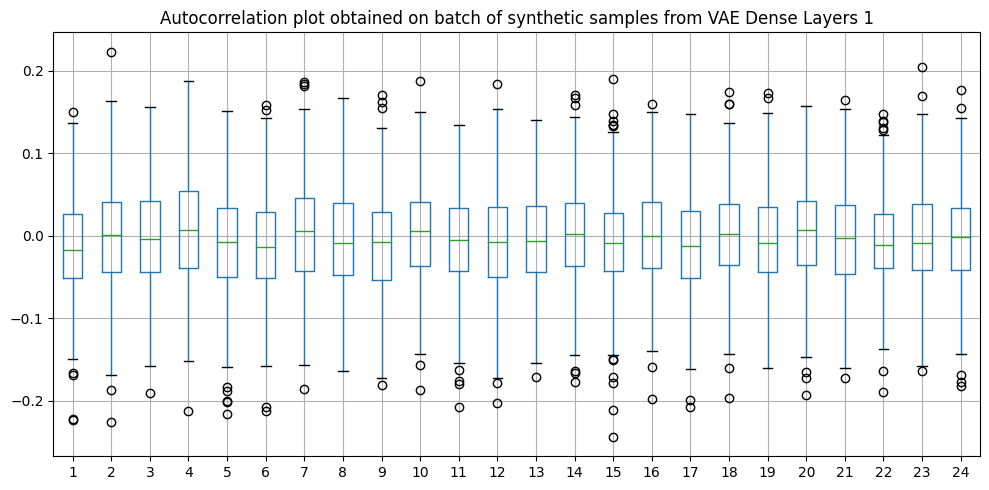

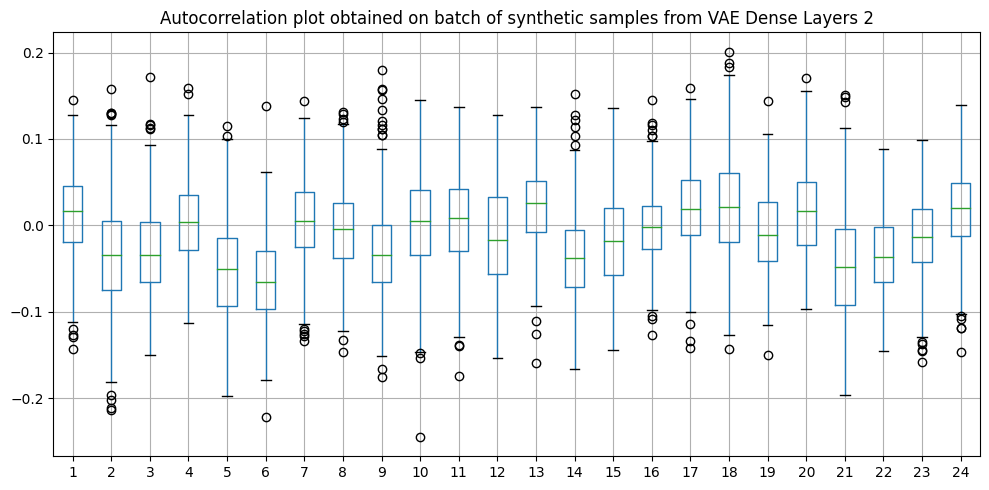

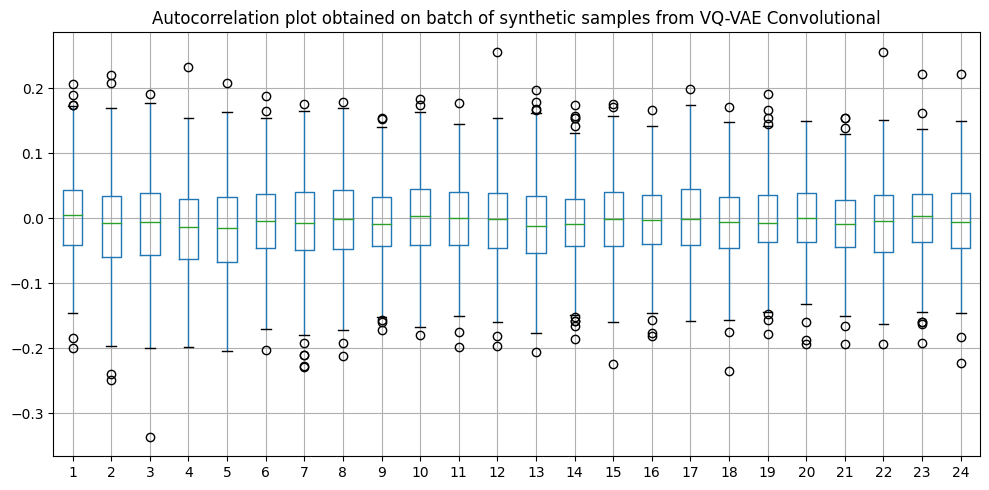

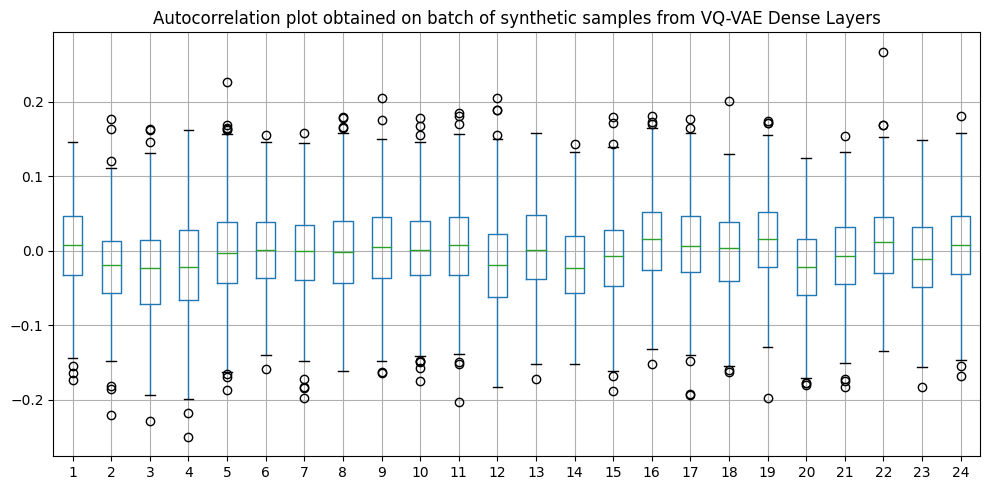

In [44]:
for k, v, in generated.items():
    title =  'Autocorrelation plot obtained on batch of synthetic samples from '+ k
    df = acf_batch(v)
    fig = plt.figure(figsize=(10, 5))
    bp = df.boxplot()
    plt.title(title)
    plt.tight_layout()
    plt.show()
    file_name = plots + k + '/'+k+'_autocorr.png'
    file_name = file_name.replace(' ', '_')
    file_name = file_name.replace('-', '_')
    file_name = file_name.lower()
    fig.savefig(file_name, dpi=fig.dpi)

# Cluster volatility 

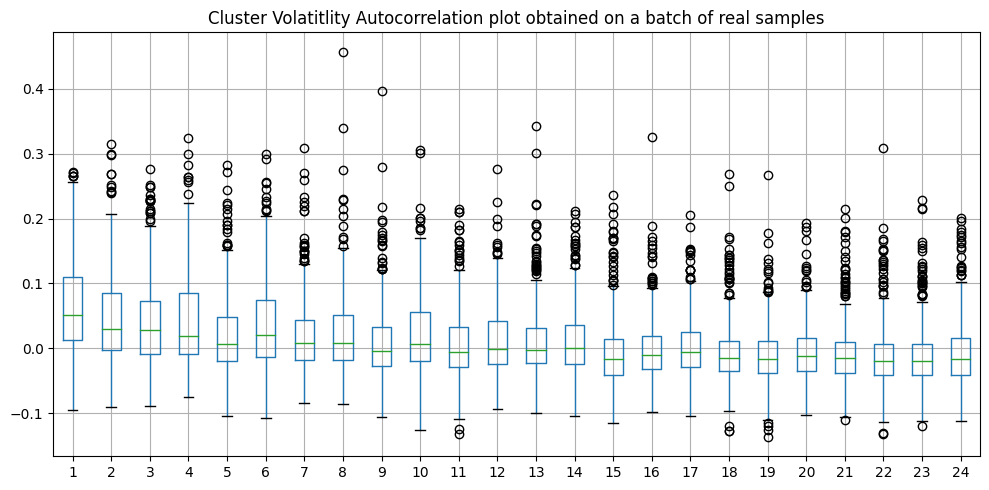

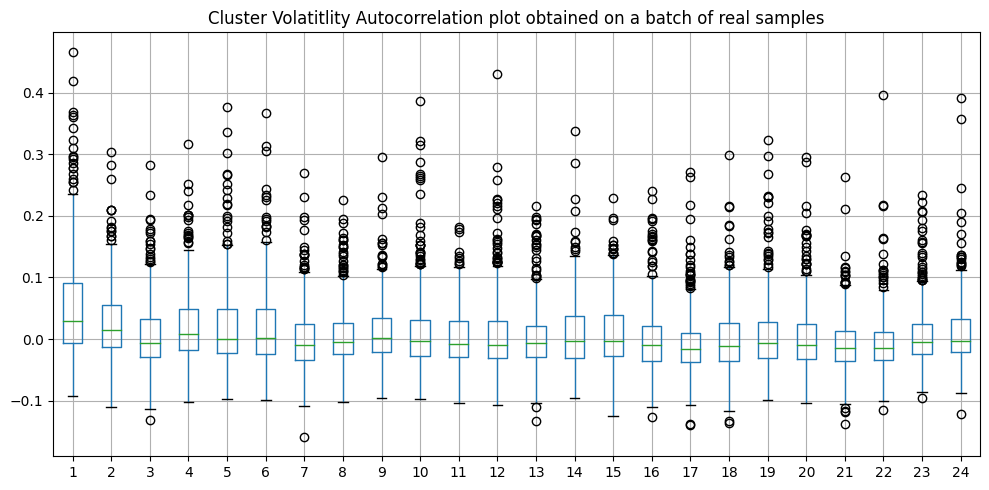

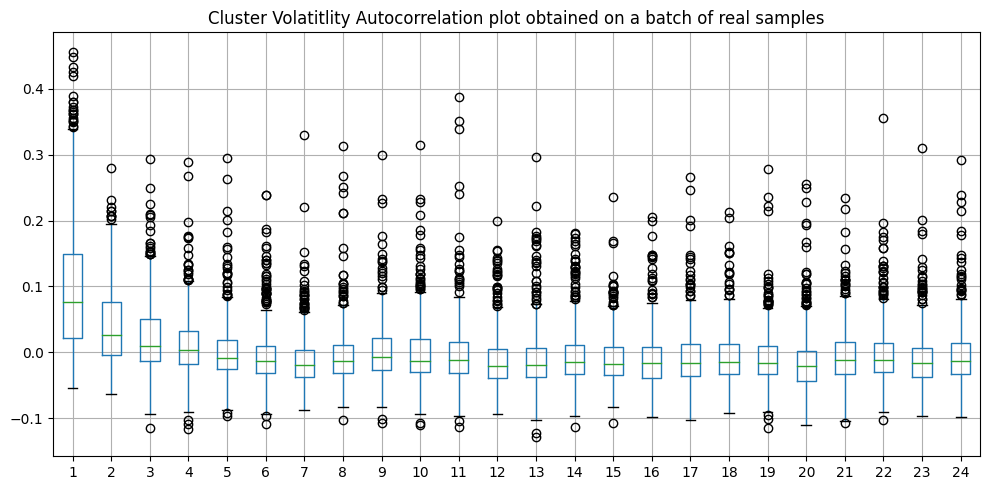

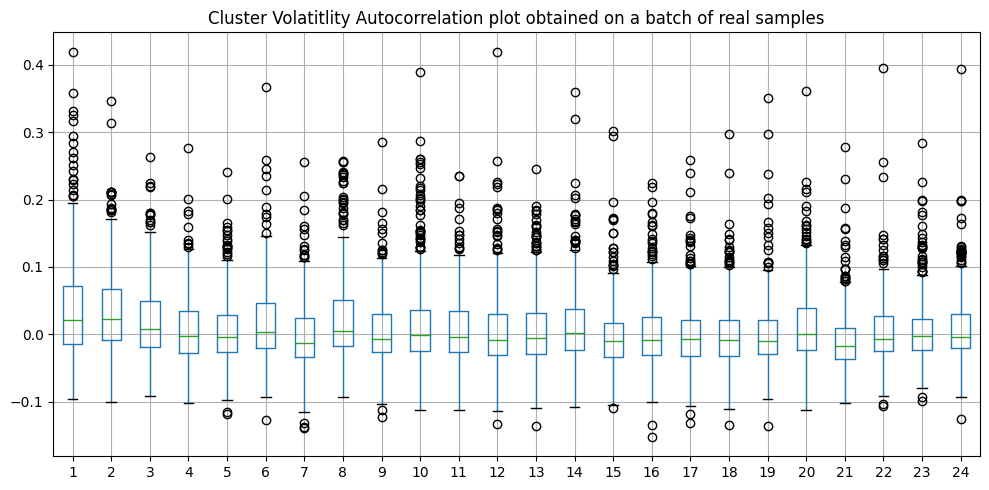

In [45]:
title = 'Cluster Volatitlity Autocorrelation plot obtained on a batch of real samples'
for i, batch in enumerate(data_eval): 
    df = acf_batch(batch, square=True)
    fig = plt.figure(figsize=(10, 5))
    df.boxplot()
    plt.title(title)
    plt.tight_layout()
    plt.show()
    file_name = real_dir + 'autocorr_square' + str(i) + '.png'
    fig.savefig(file_name, dpi=fig.dpi)
    plt.close(fig)

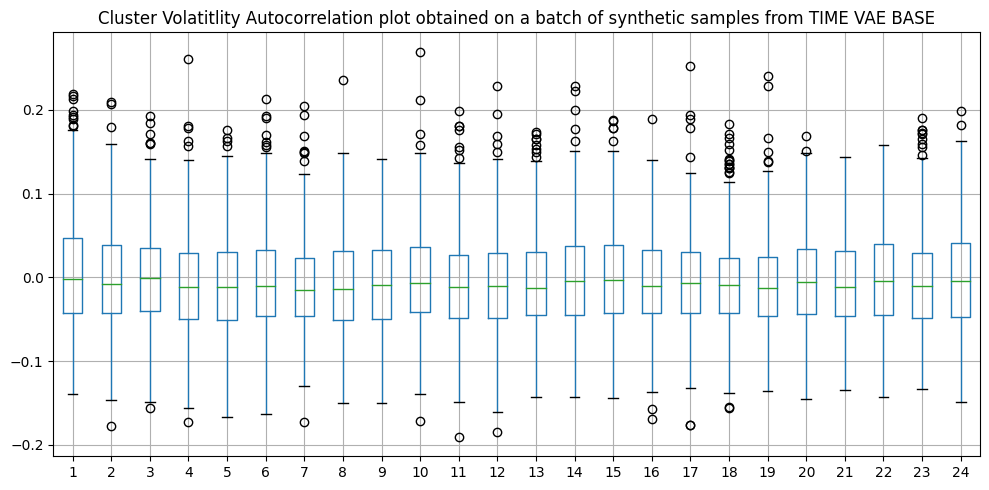

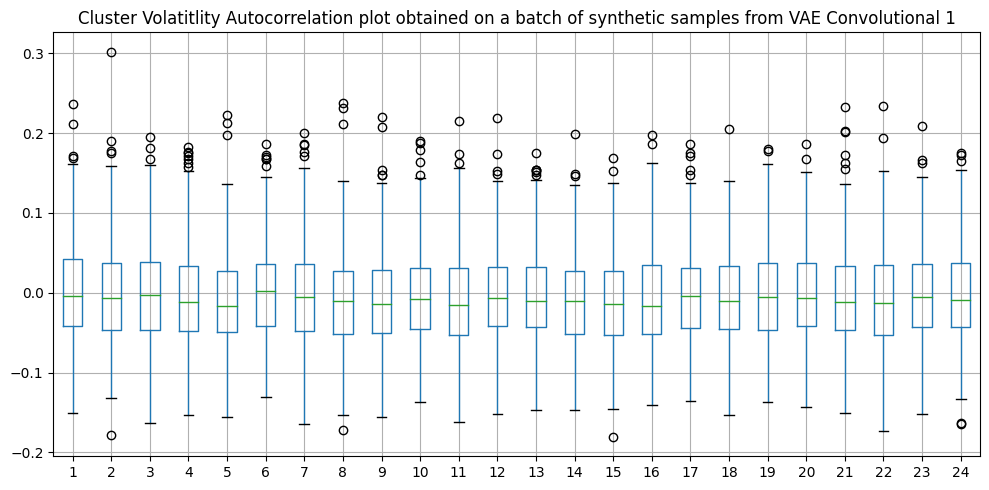

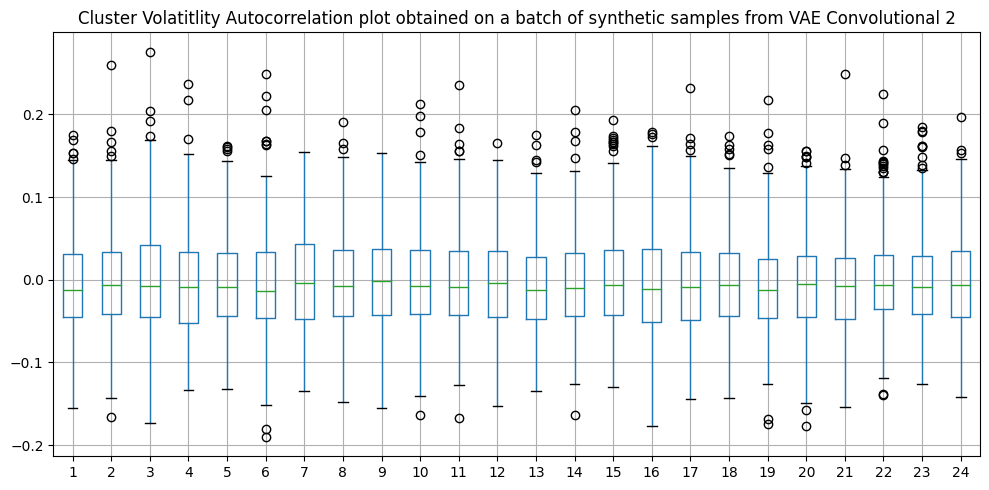

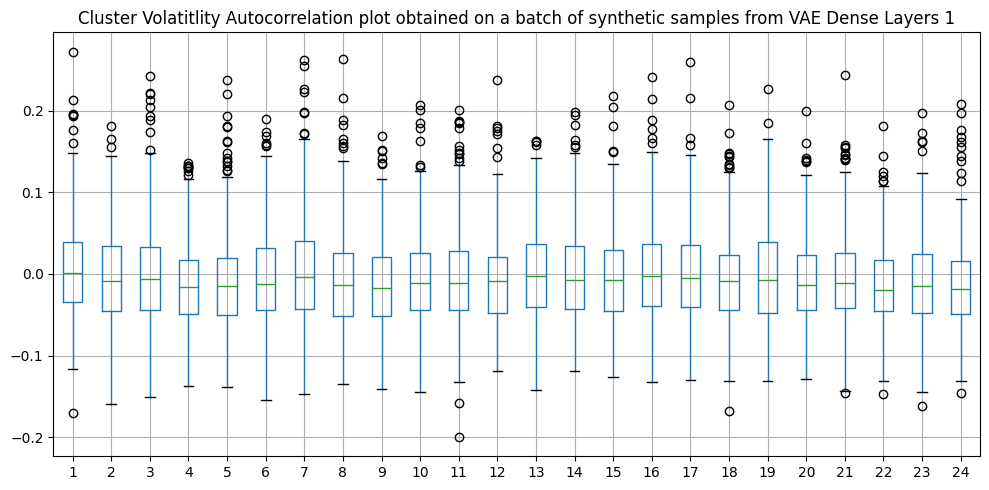

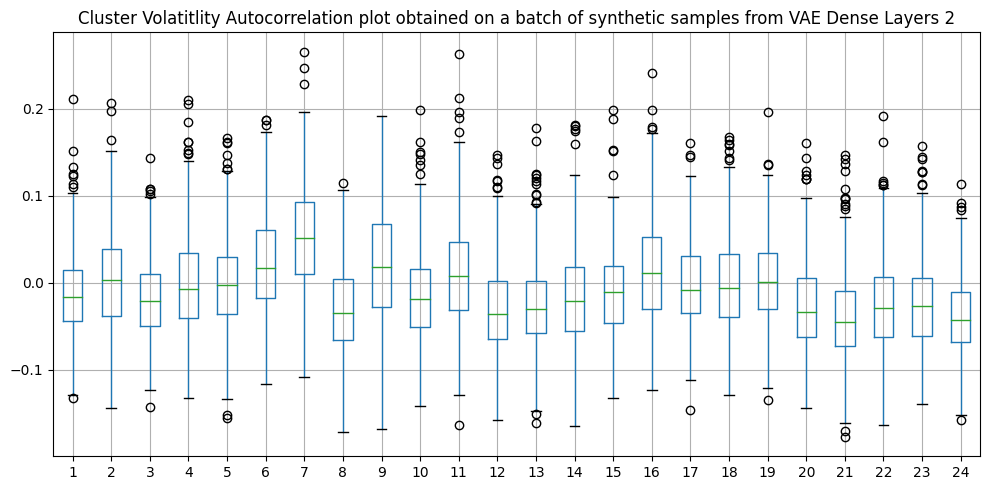

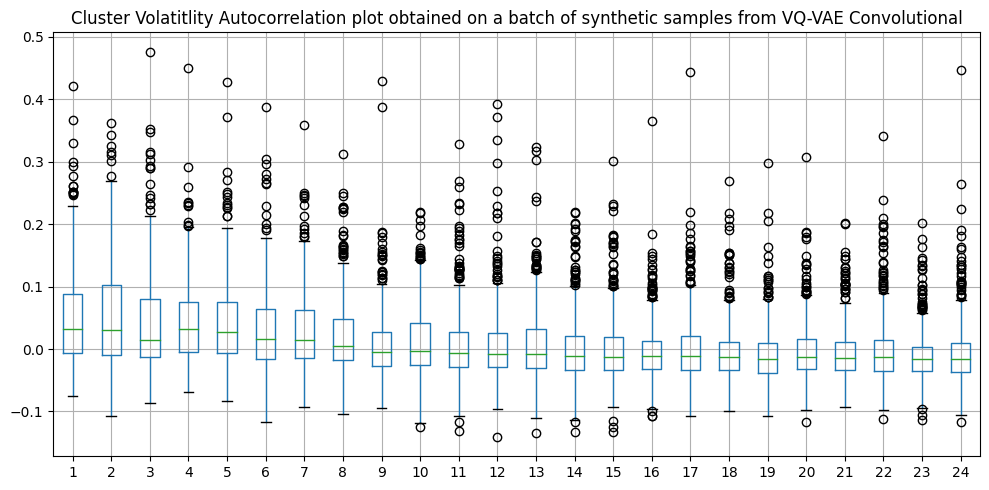

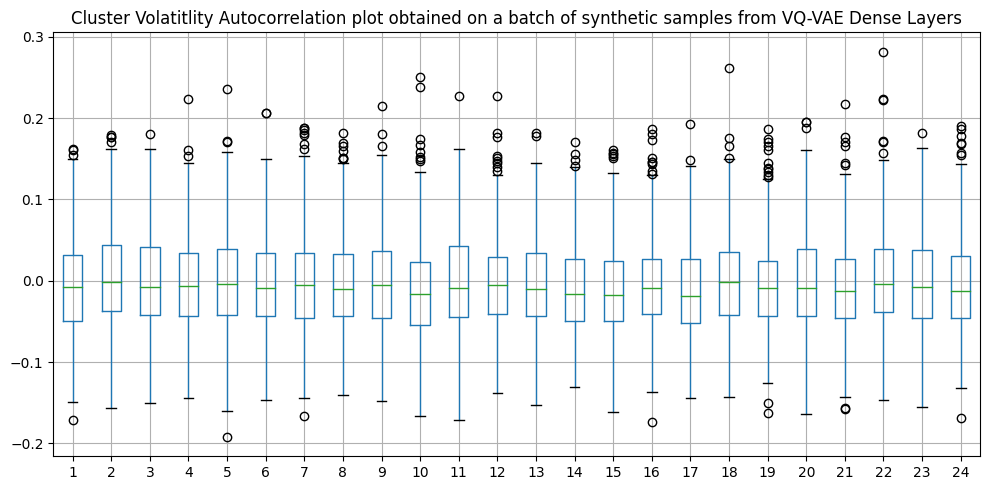

In [46]:
for k, v, in generated.items():
    title = 'Cluster Volatitlity Autocorrelation plot obtained on a batch of synthetic samples from '+ k
    df = acf_batch(v, square=True)
    fig = plt.figure(figsize=(10, 5))
    df.boxplot()
    plt.title(title)
    plt.tight_layout()
    plt.show()
    file_name = plots + k + '/'+k+'_autocorr_square.png'
    file_name = file_name.replace(' ', '_')
    file_name = file_name.replace('-', '_')
    file_name = file_name.lower()
    fig.savefig(file_name, dpi=fig.dpi)

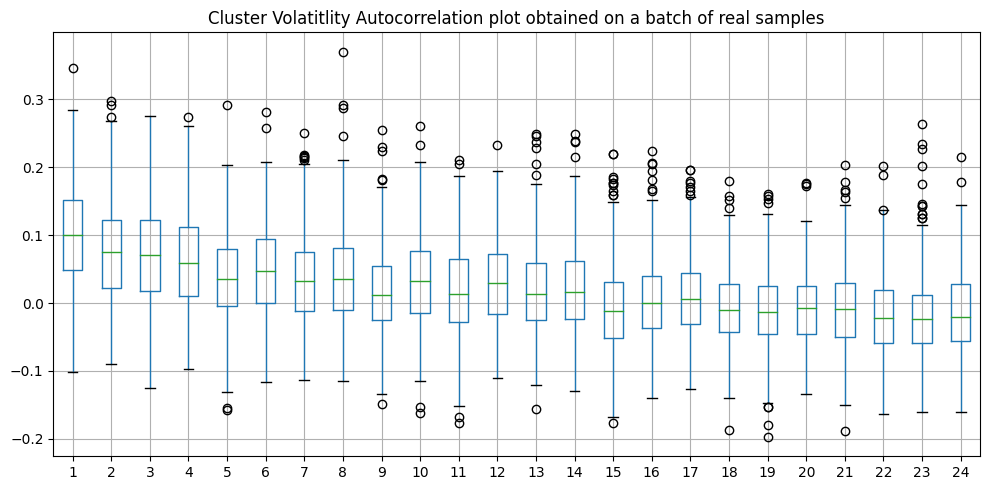

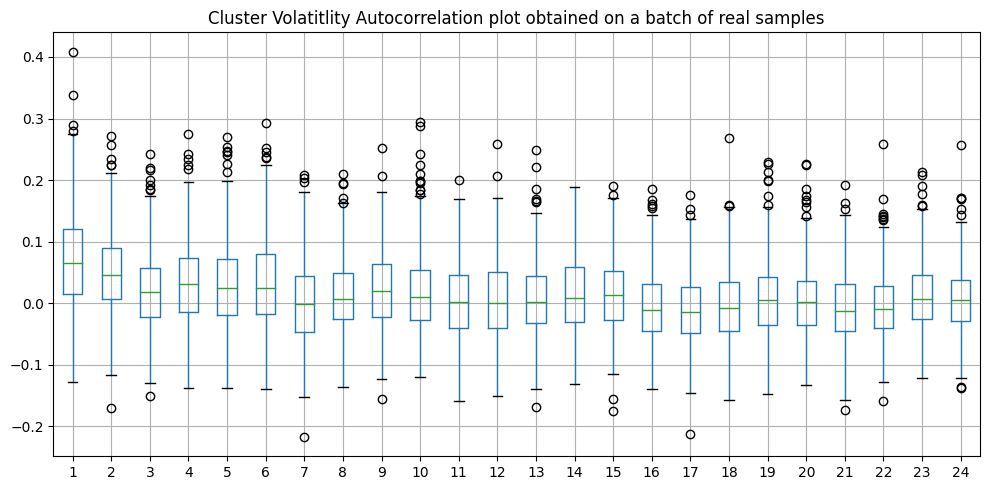

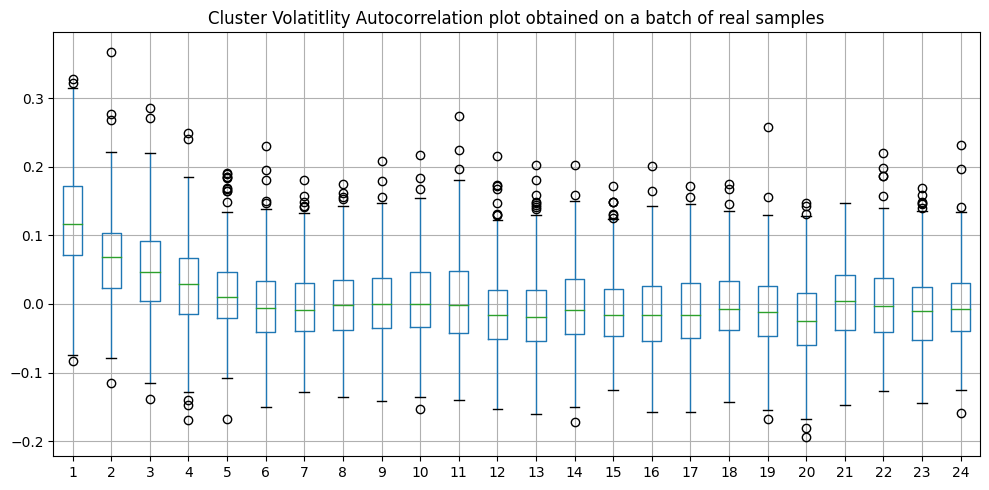

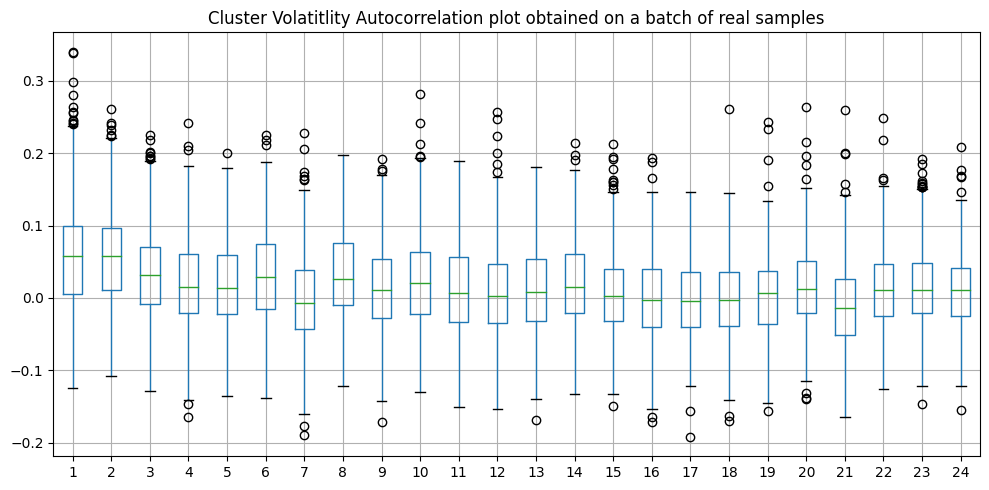

In [47]:
title = 'Cluster Volatitlity Autocorrelation plot obtained on a batch of real samples'
for batch in data_eval: 
    df = acf_batch(batch, abs=True)
    fig = plt.figure(figsize=(10, 5))
    df.boxplot()
    plt.title(title)
    plt.tight_layout()
    plt.show()
    file_name = real_dir + 'autocorr_abs' + str(i) + '.png'
    fig.savefig(file_name, dpi=fig.dpi)
    plt.close(fig)

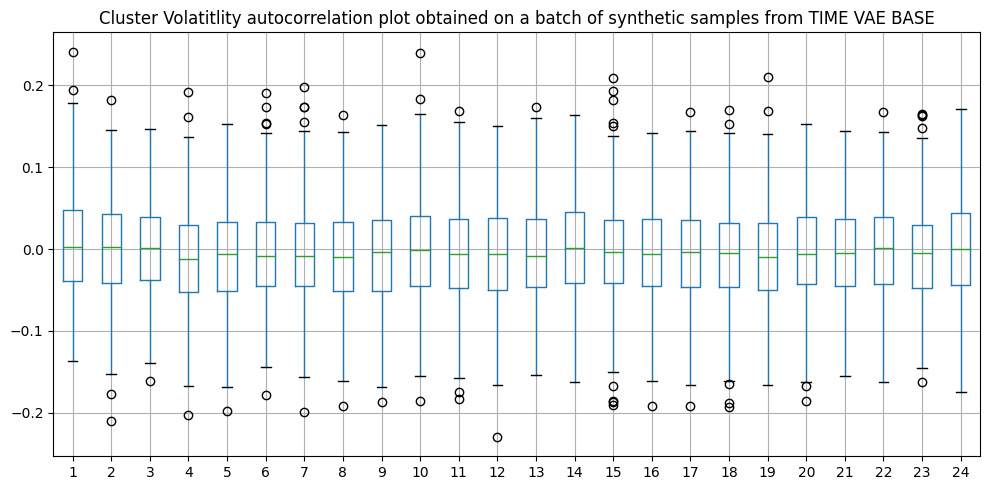

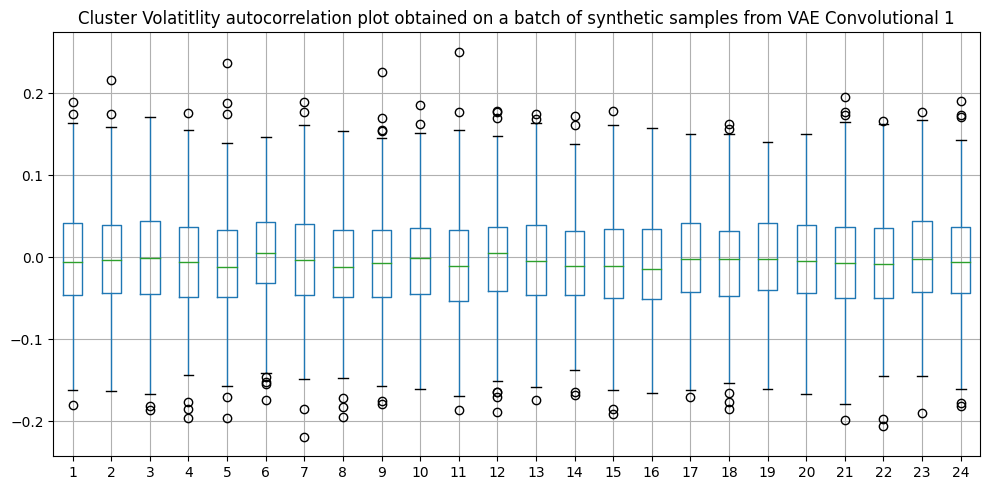

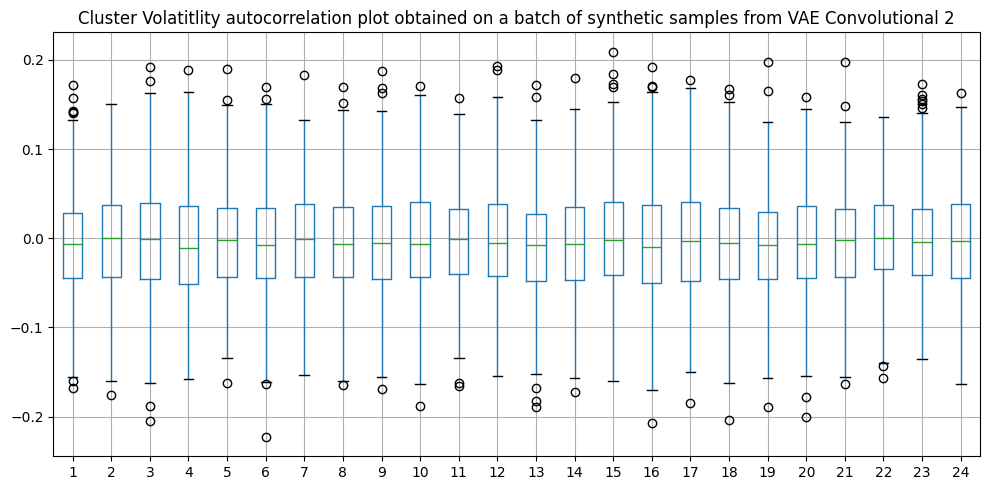

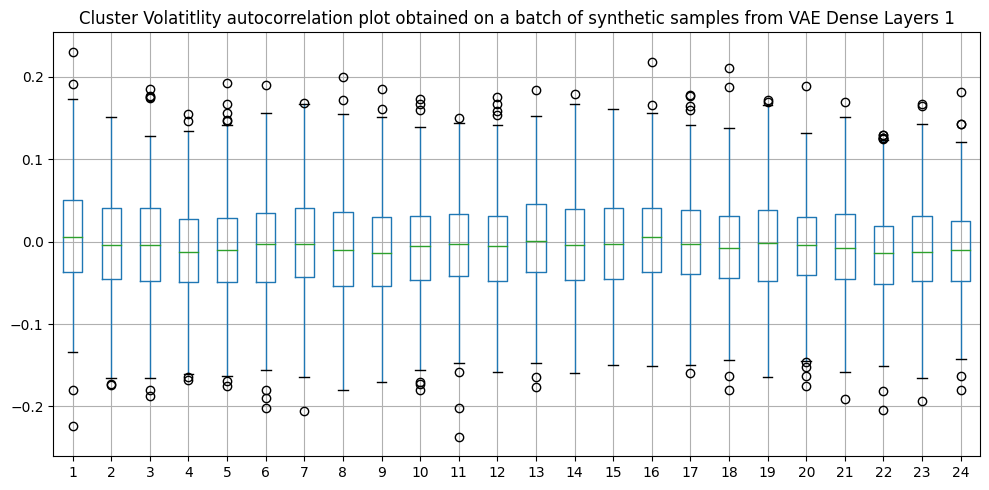

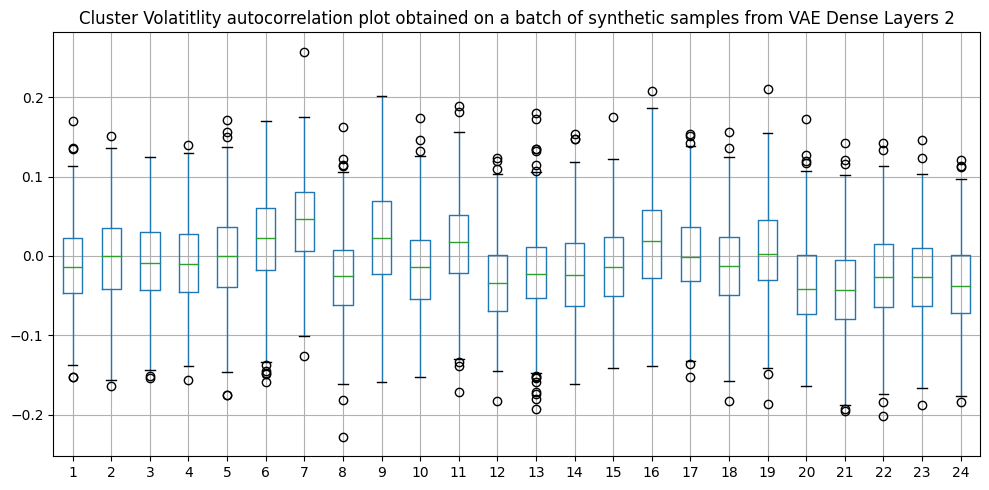

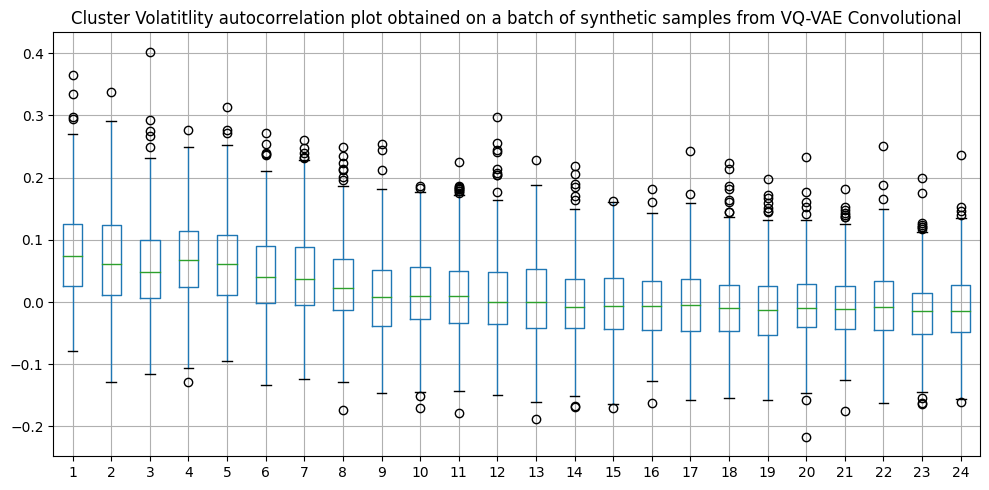

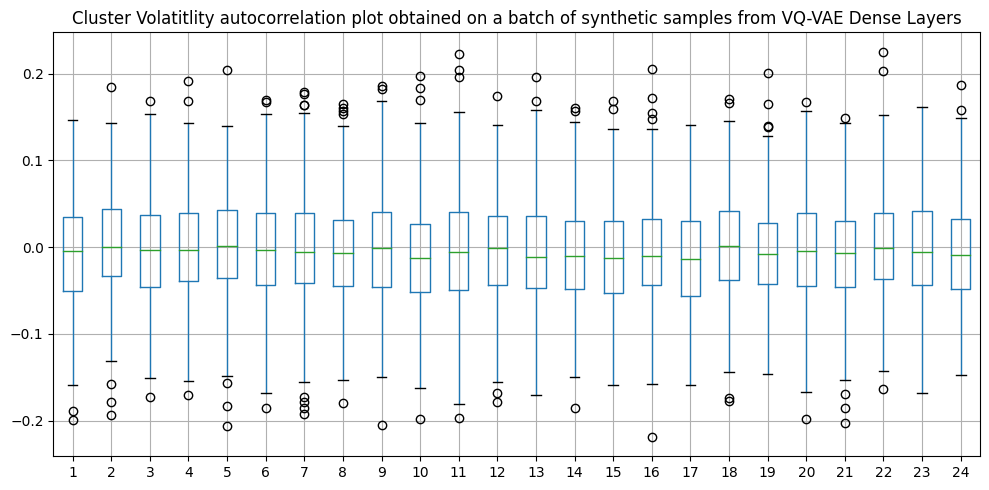

In [48]:
for k, v, in generated.items():
    title = 'Cluster Volatitlity autocorrelation plot obtained on a batch of synthetic samples from '+ k
    df = acf_batch(v, abs=True)
    fig = plt.figure(figsize=(10, 5))
    df.boxplot()
    plt.title(title)
    plt.tight_layout()
    plt.show()
    file_name = plots + k + '/'+k+'_autocorr_abs.png'
    file_name = file_name.replace(' ', '_')
    file_name = file_name.replace('-', '_')
    file_name = file_name.lower()
    fig.savefig(file_name, dpi=fig.dpi)

# Heavy tail distribution

In [12]:
for i in range(4):
    real = pd.DataFrame(data_eval[i].flatten())
    print('Real Data Max: ', real.max())
    print('Real Data Min: ', real.min())

Real Data Max:  0    0.339428
dtype: float64
Real Data Min:  0   -0.336685
dtype: float64
Real Data Max:  0    0.481849
dtype: float64
Real Data Min:  0   -0.312365
dtype: float64
Real Data Max:  0    0.420617
dtype: float64
Real Data Min:  0   -0.285143
dtype: float64
Real Data Max:  0    0.481849
dtype: float64
Real Data Min:  0   -0.371311
dtype: float64


In [13]:
for model, synth_data in generated.items():
    print('Model: ', model)

    print('Synth Data Max: ', synth_data.max())
    print('Synth Data Min: ', synth_data.min())

Model:  TIME VAE BASE
Synth Data Max:  0.042968035
Synth Data Min:  -0.10307336
Model:  VAE CONV1 
Synth Data Max:  0.03808418216355101
Synth Data Min:  -0.0393675830478037
Model:  VAE CONV3
Synth Data Max:  0.14600960302876592
Synth Data Min:  -0.1258341500856946
Model:  VAE FD1
Synth Data Max:  0.10891162112889939
Synth Data Min:  -0.0885284264975152
Model:  VAE FD2
Synth Data Max:  0.03934465364458169
Synth Data Min:  -0.03523304116650405
Model:  VQ VAE CONV2
Synth Data Max:  0.16704141332380268
Synth Data Min:  -0.18485490519796333
Model:  VQ VAE FD1
Synth Data Max:  0.05547019786917105
Synth Data Min:  -0.039619342212138246


Model:  TIME VAE BASE


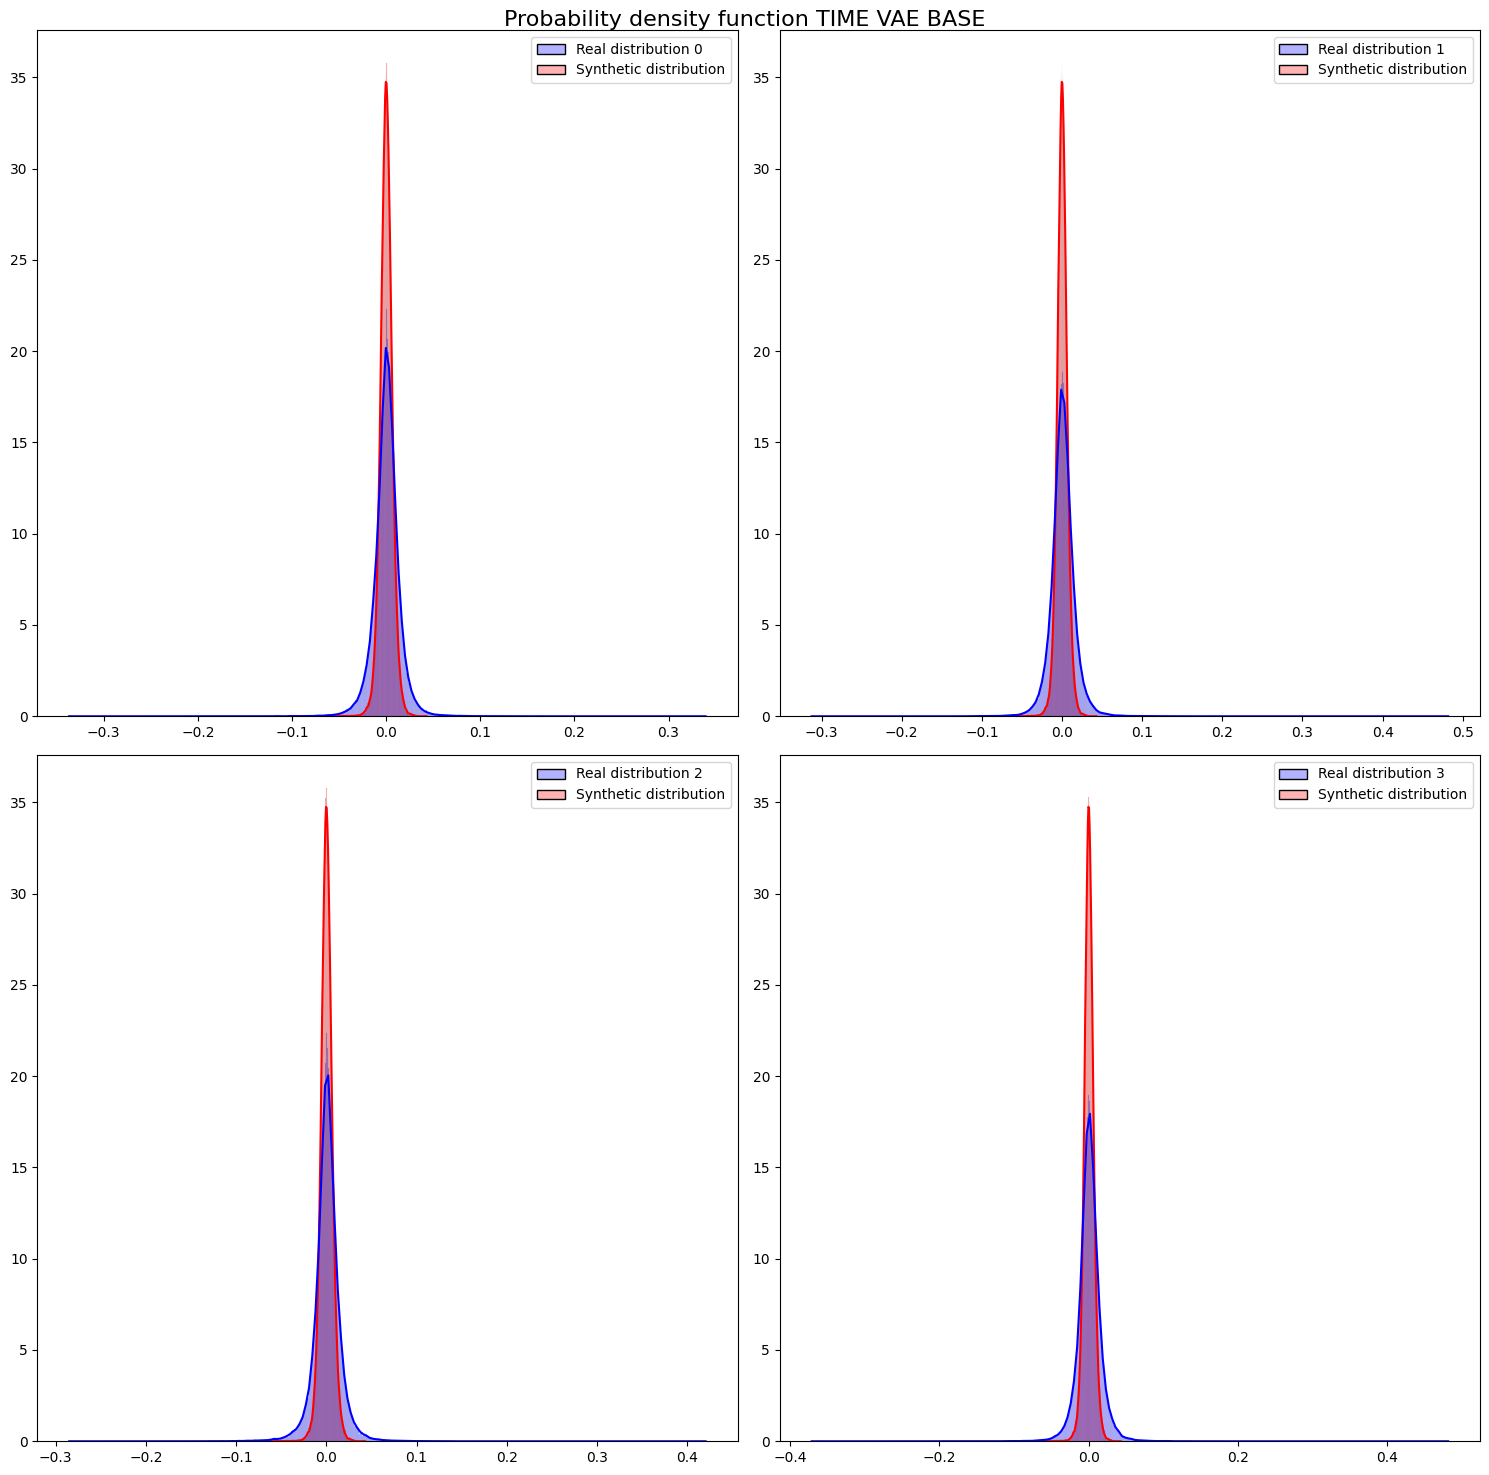

Model:  VAE Convolutional 1


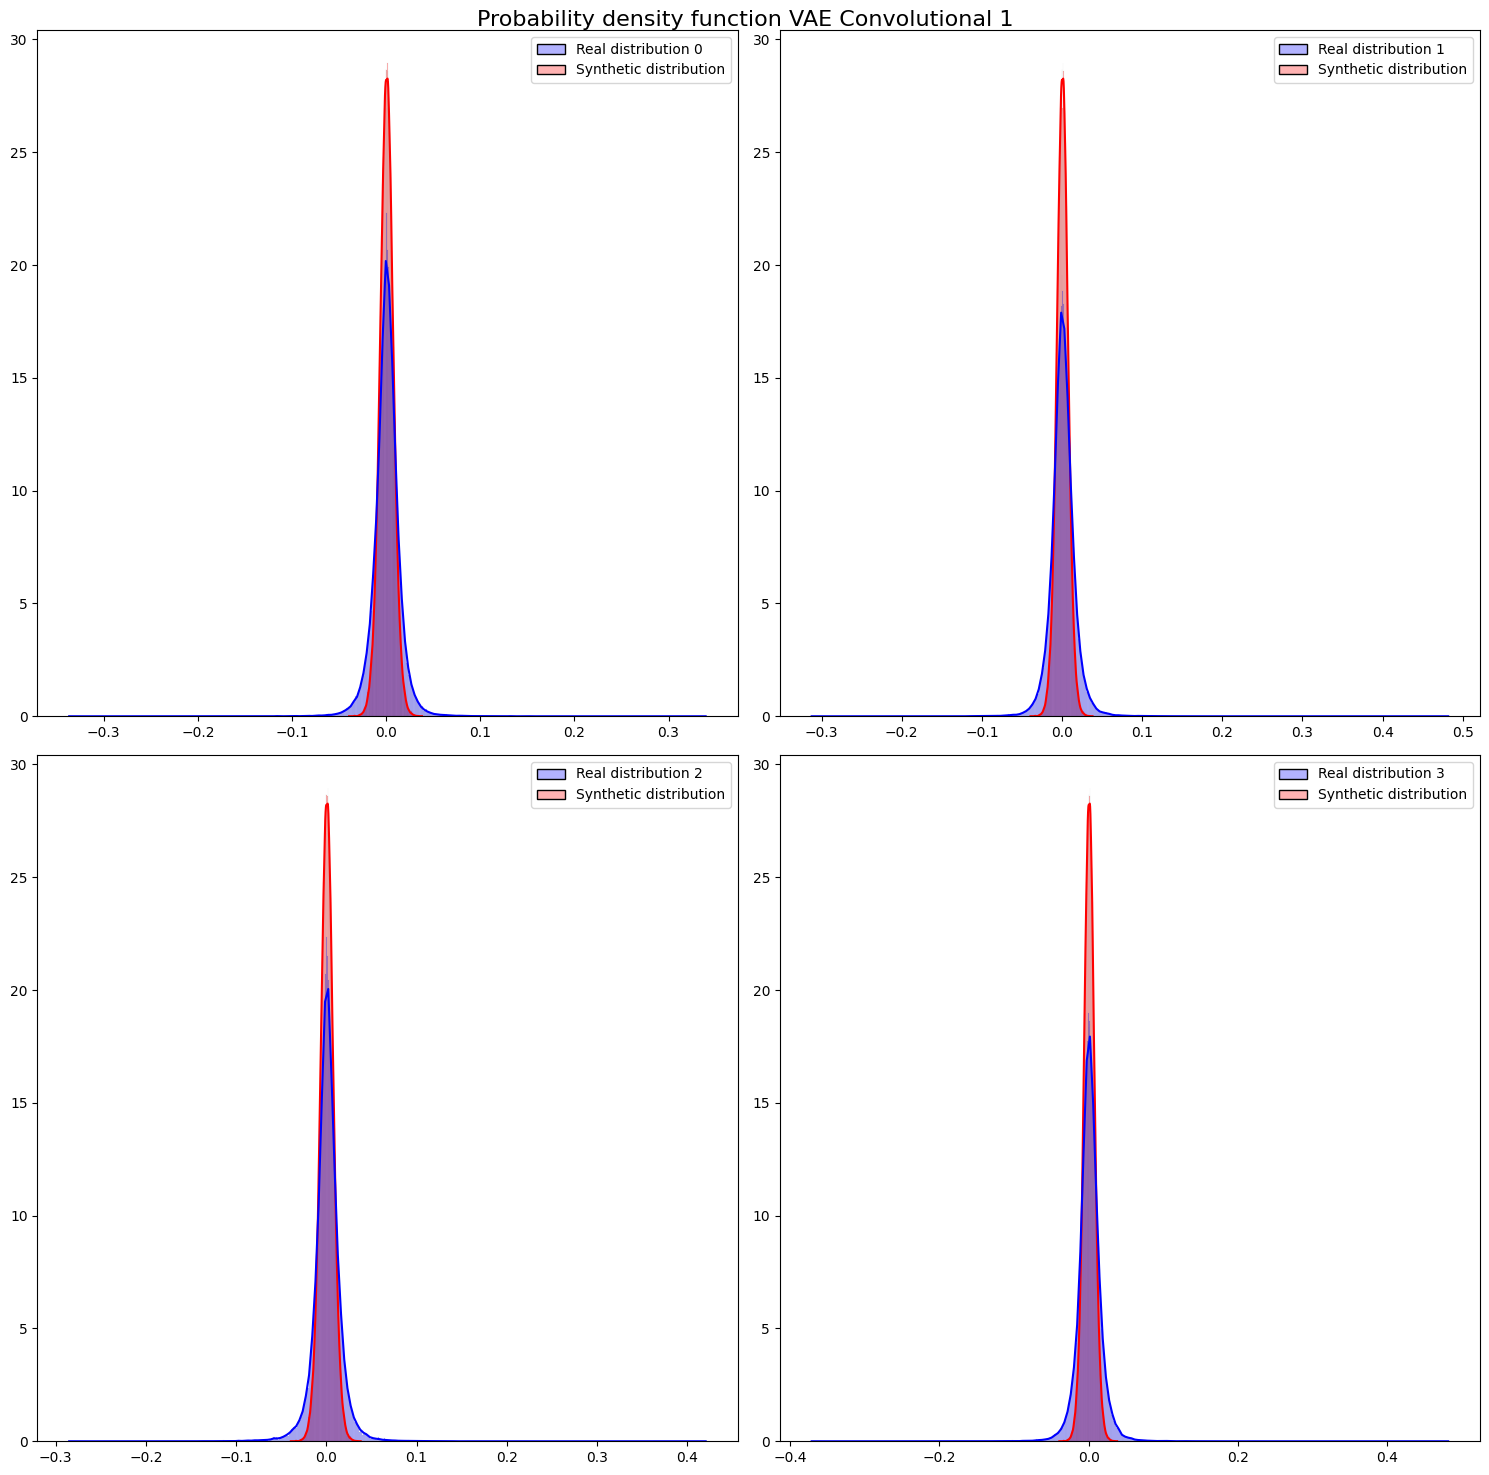

Model:  VAE Convolutional 2


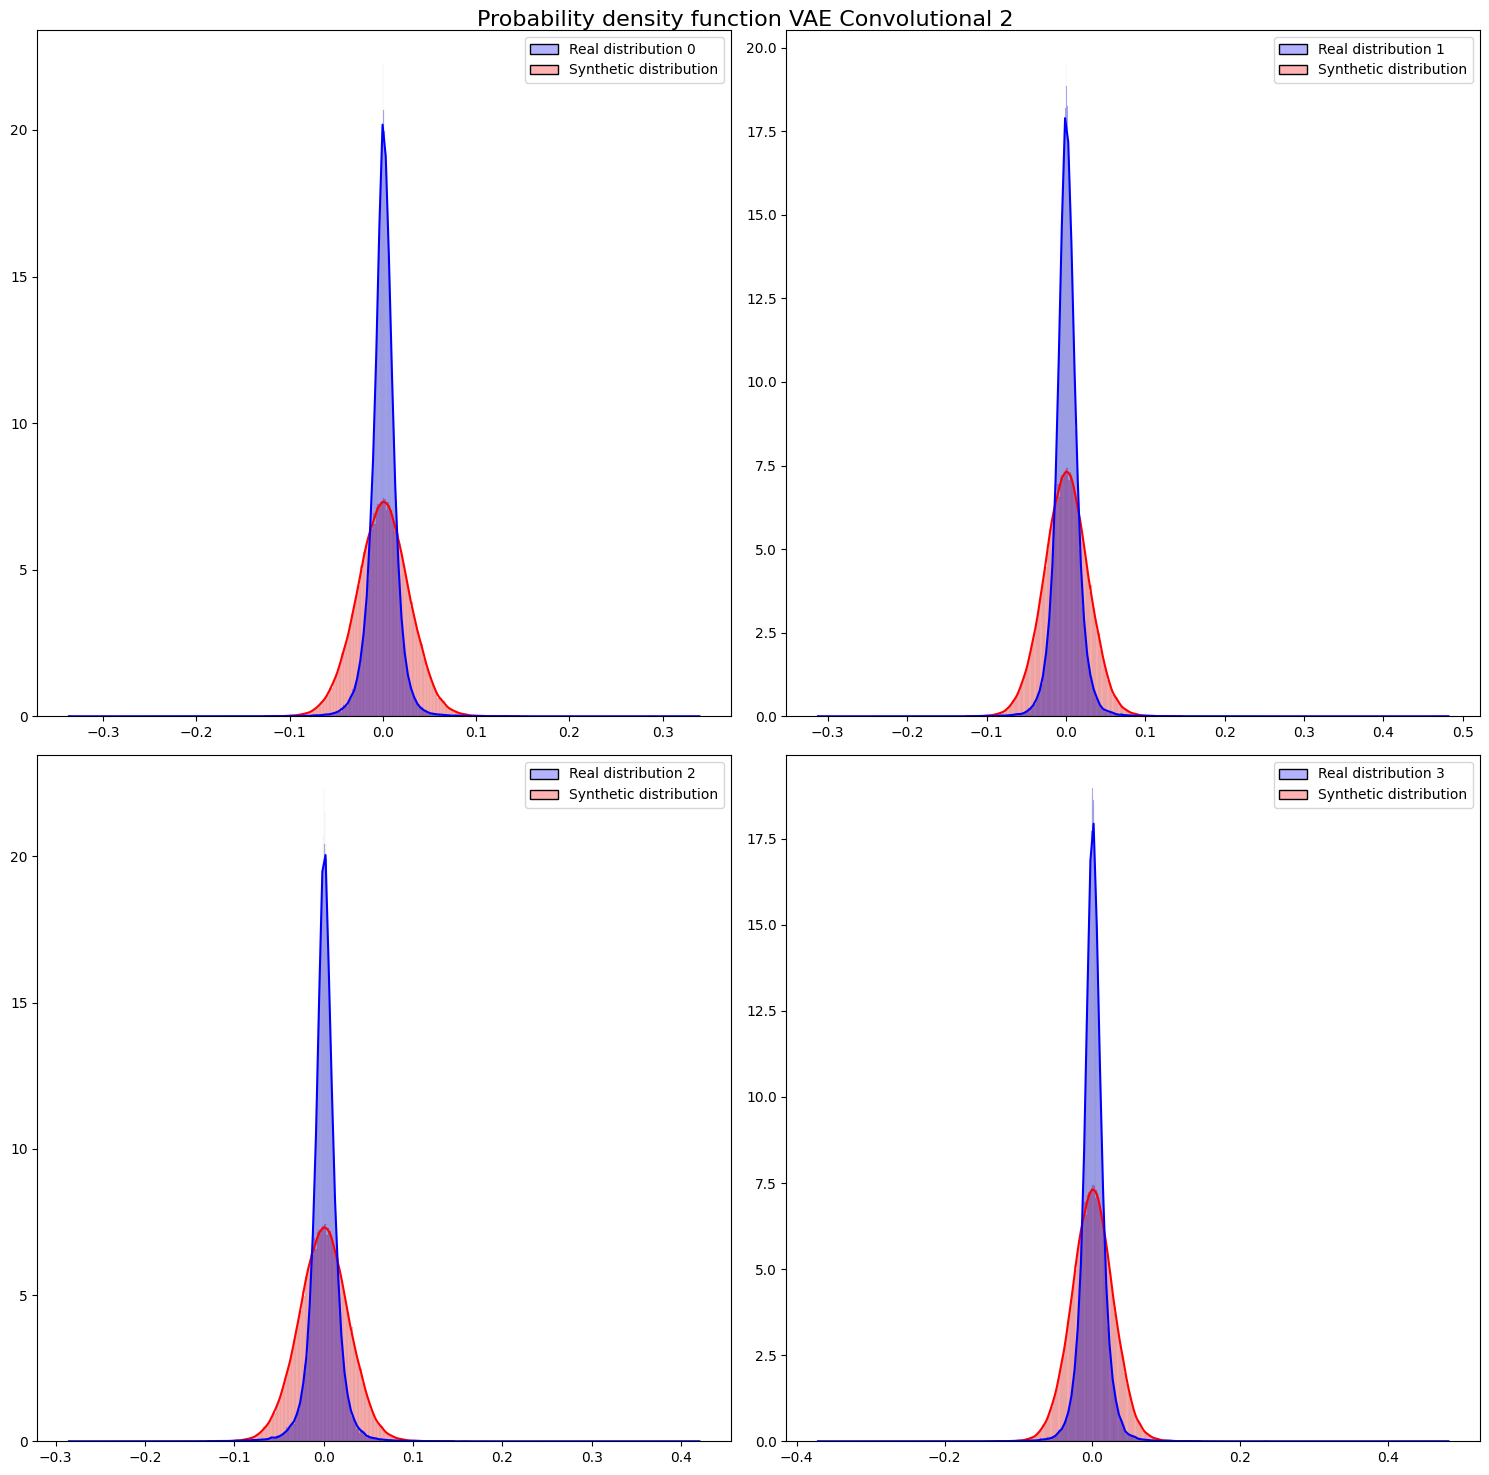

Model:  VAE Dense Layers 1


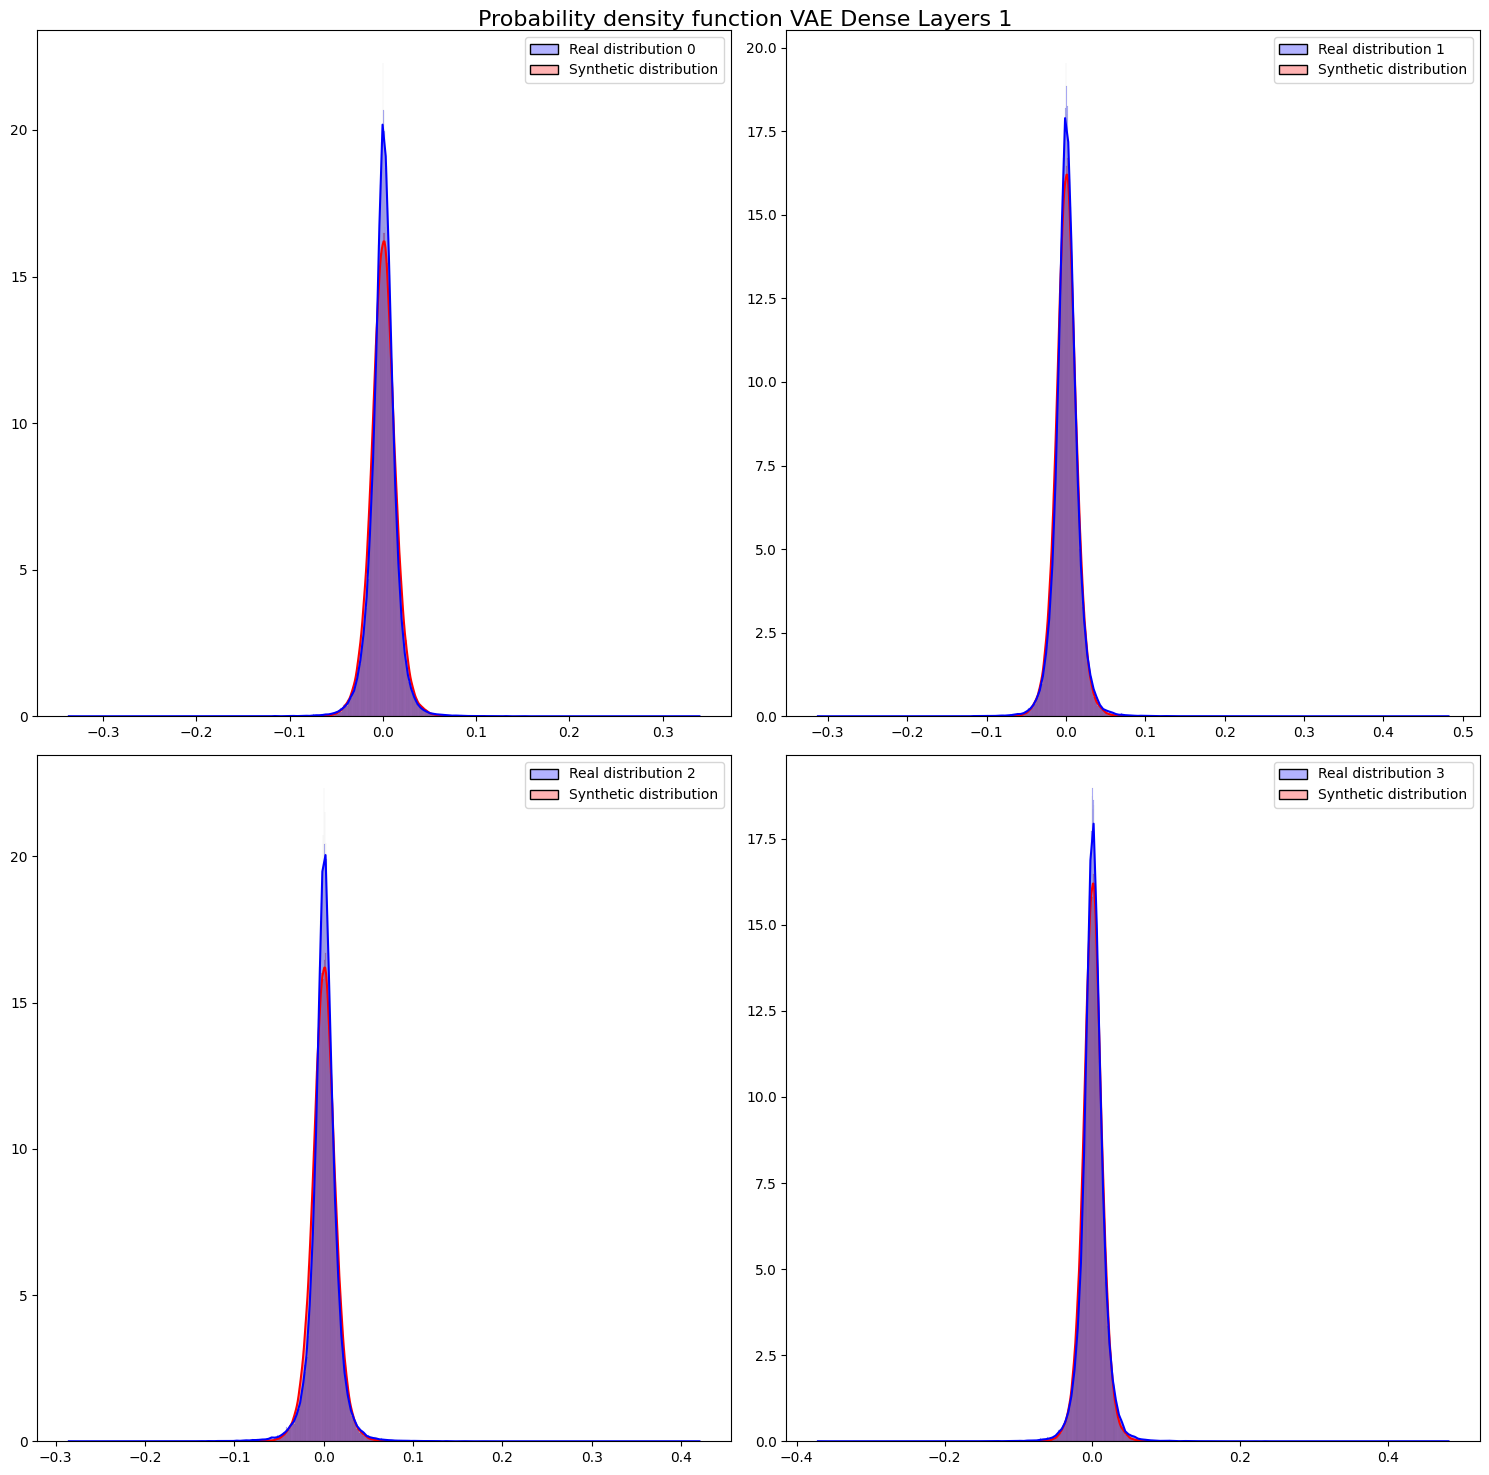

Model:  VAE Dense Layers 2


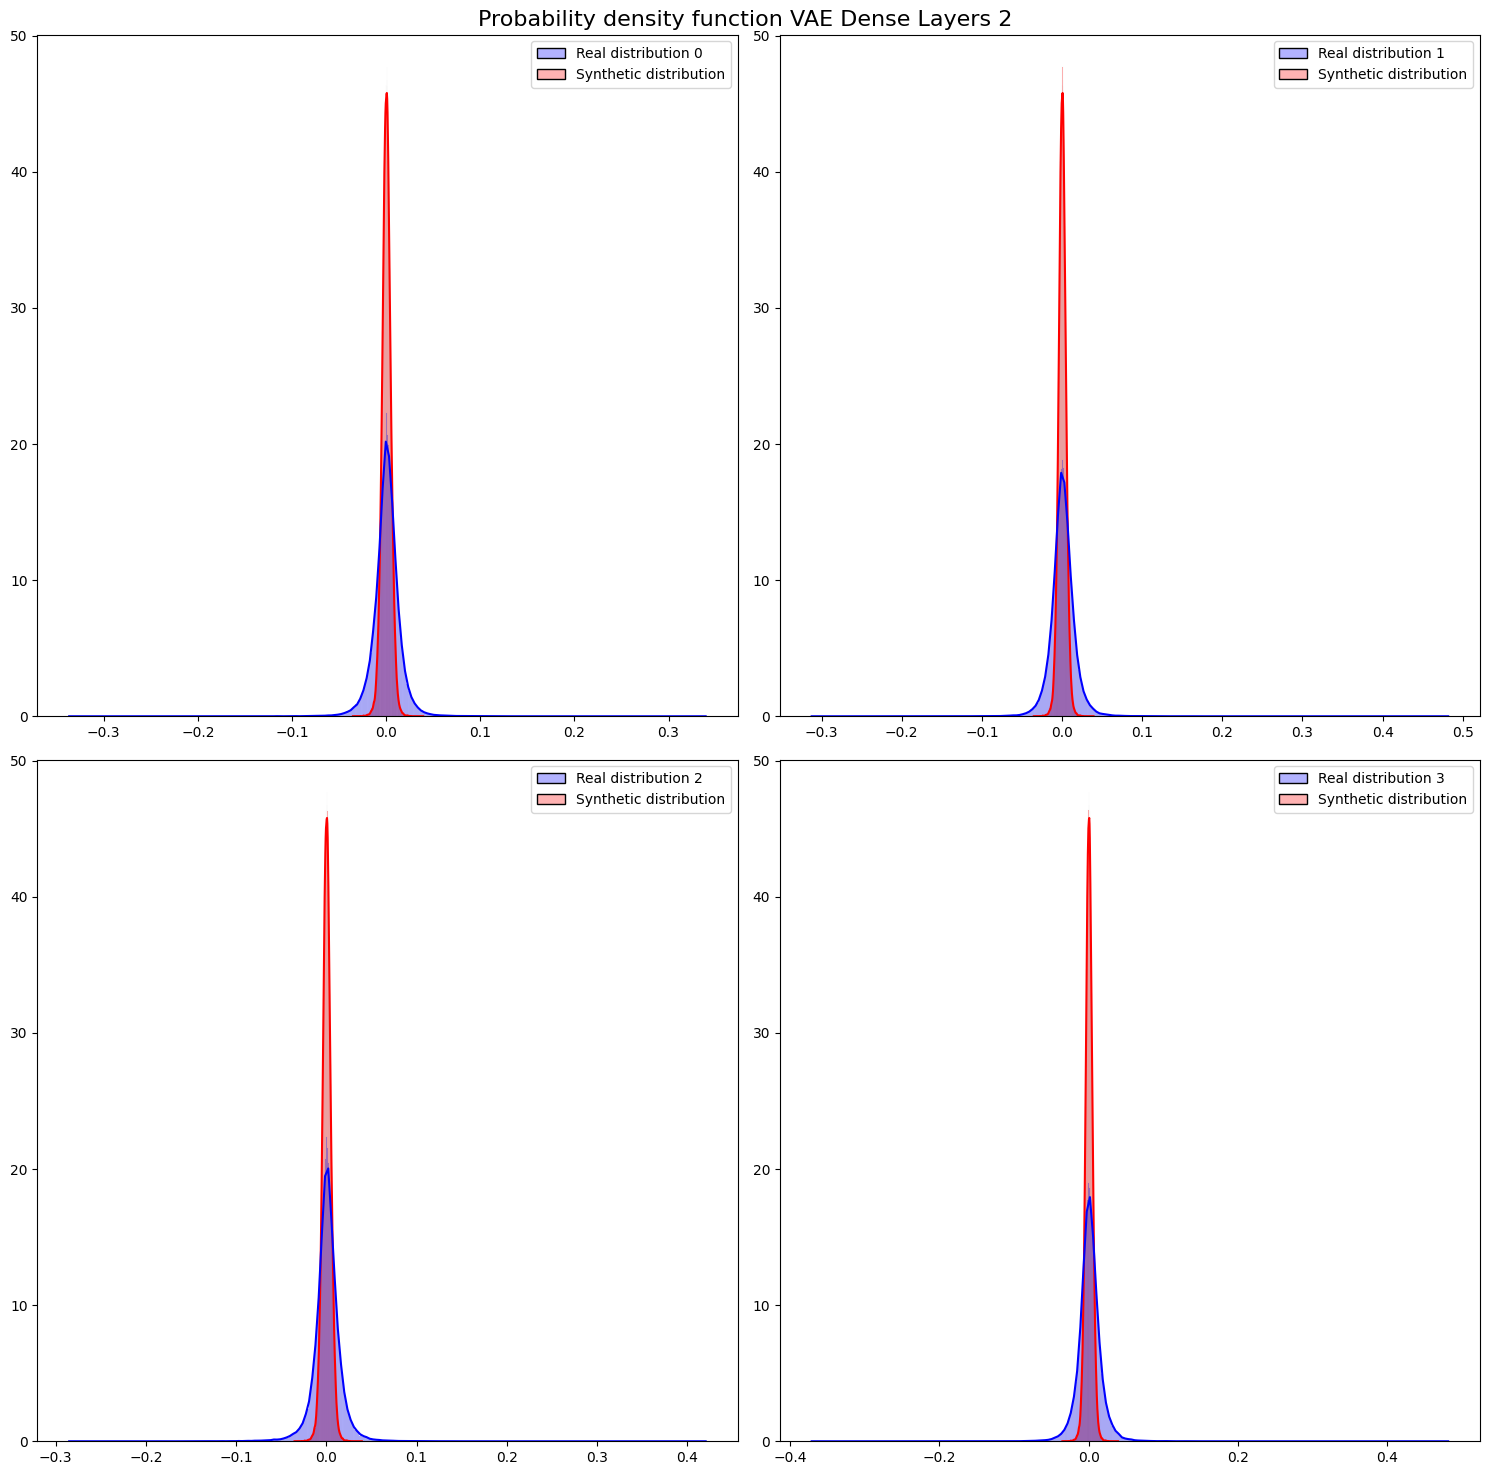

Model:  VQ-VAE Convolutional


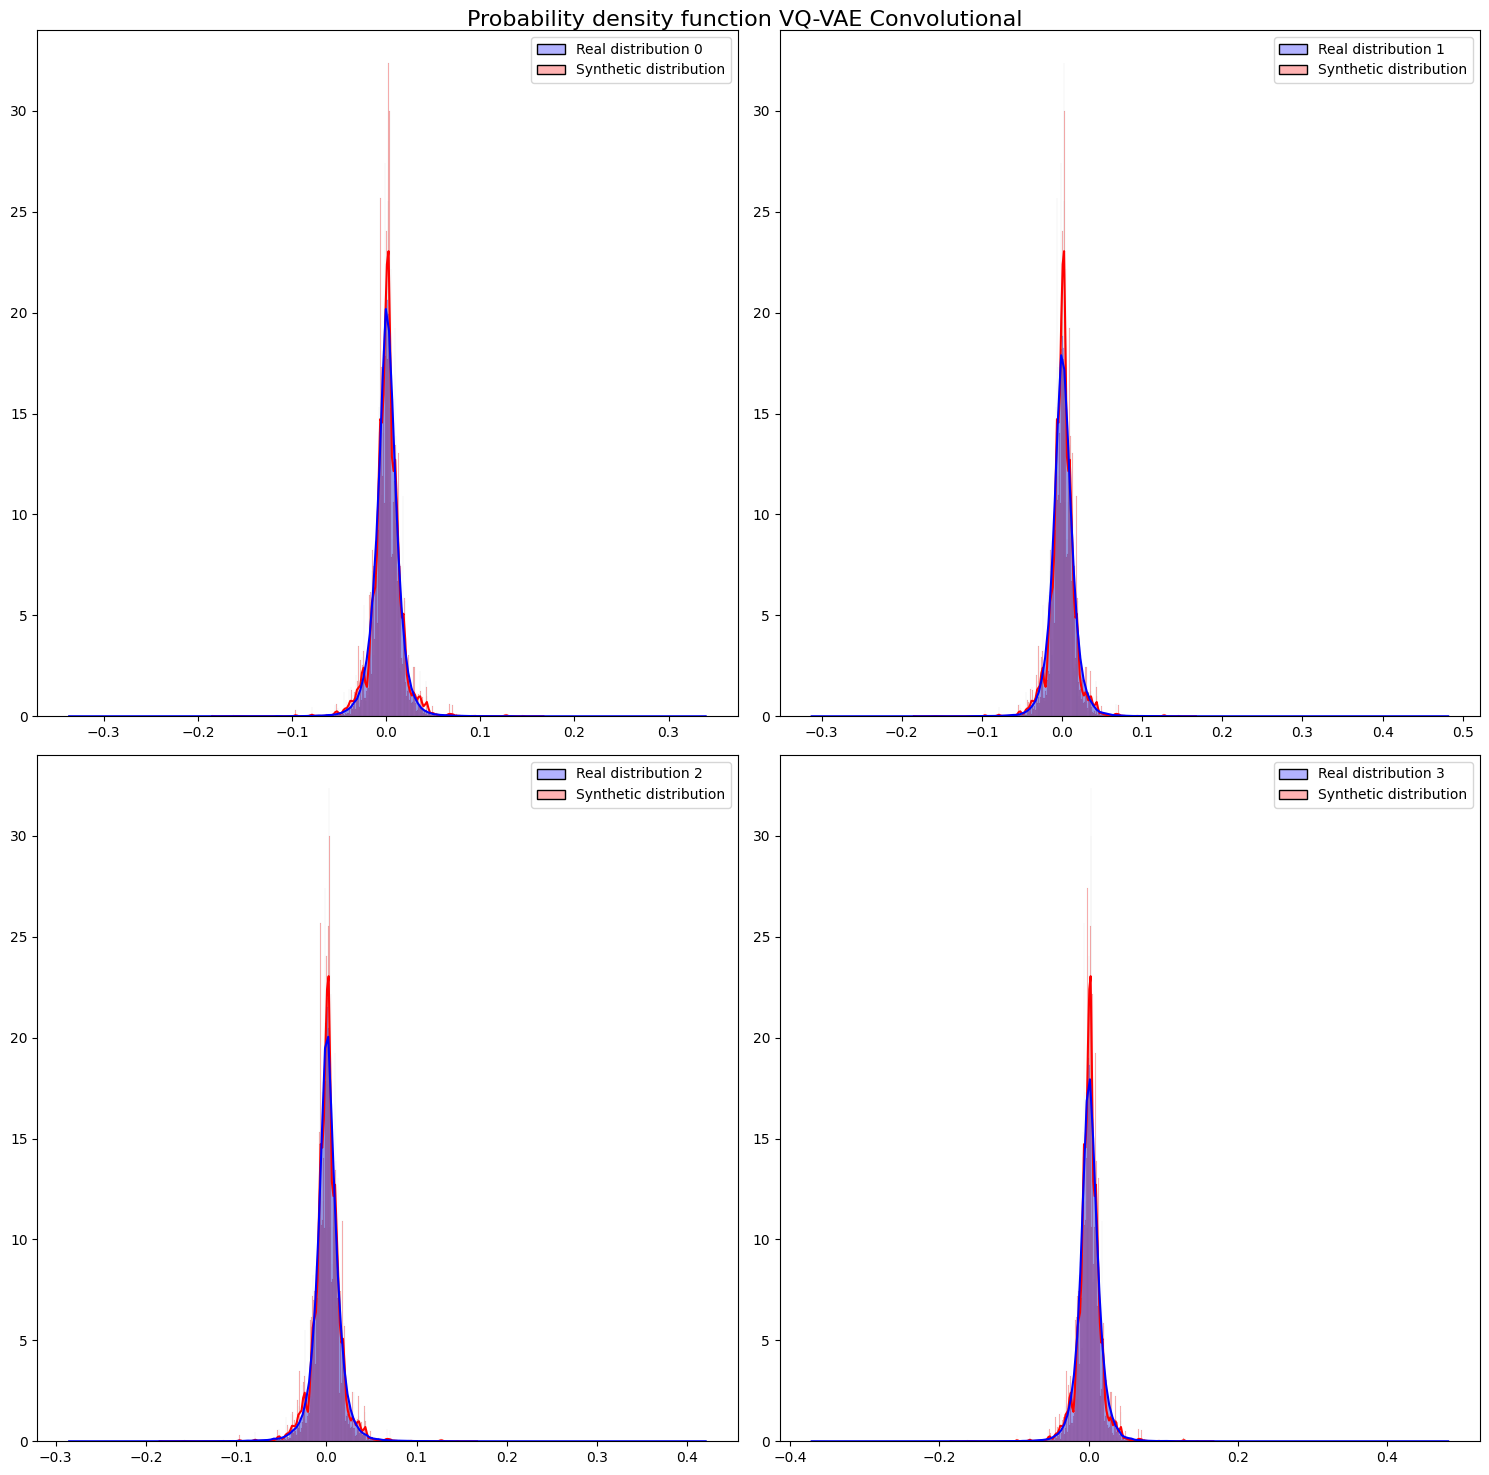

Model:  VQ-VAE Dense Layers


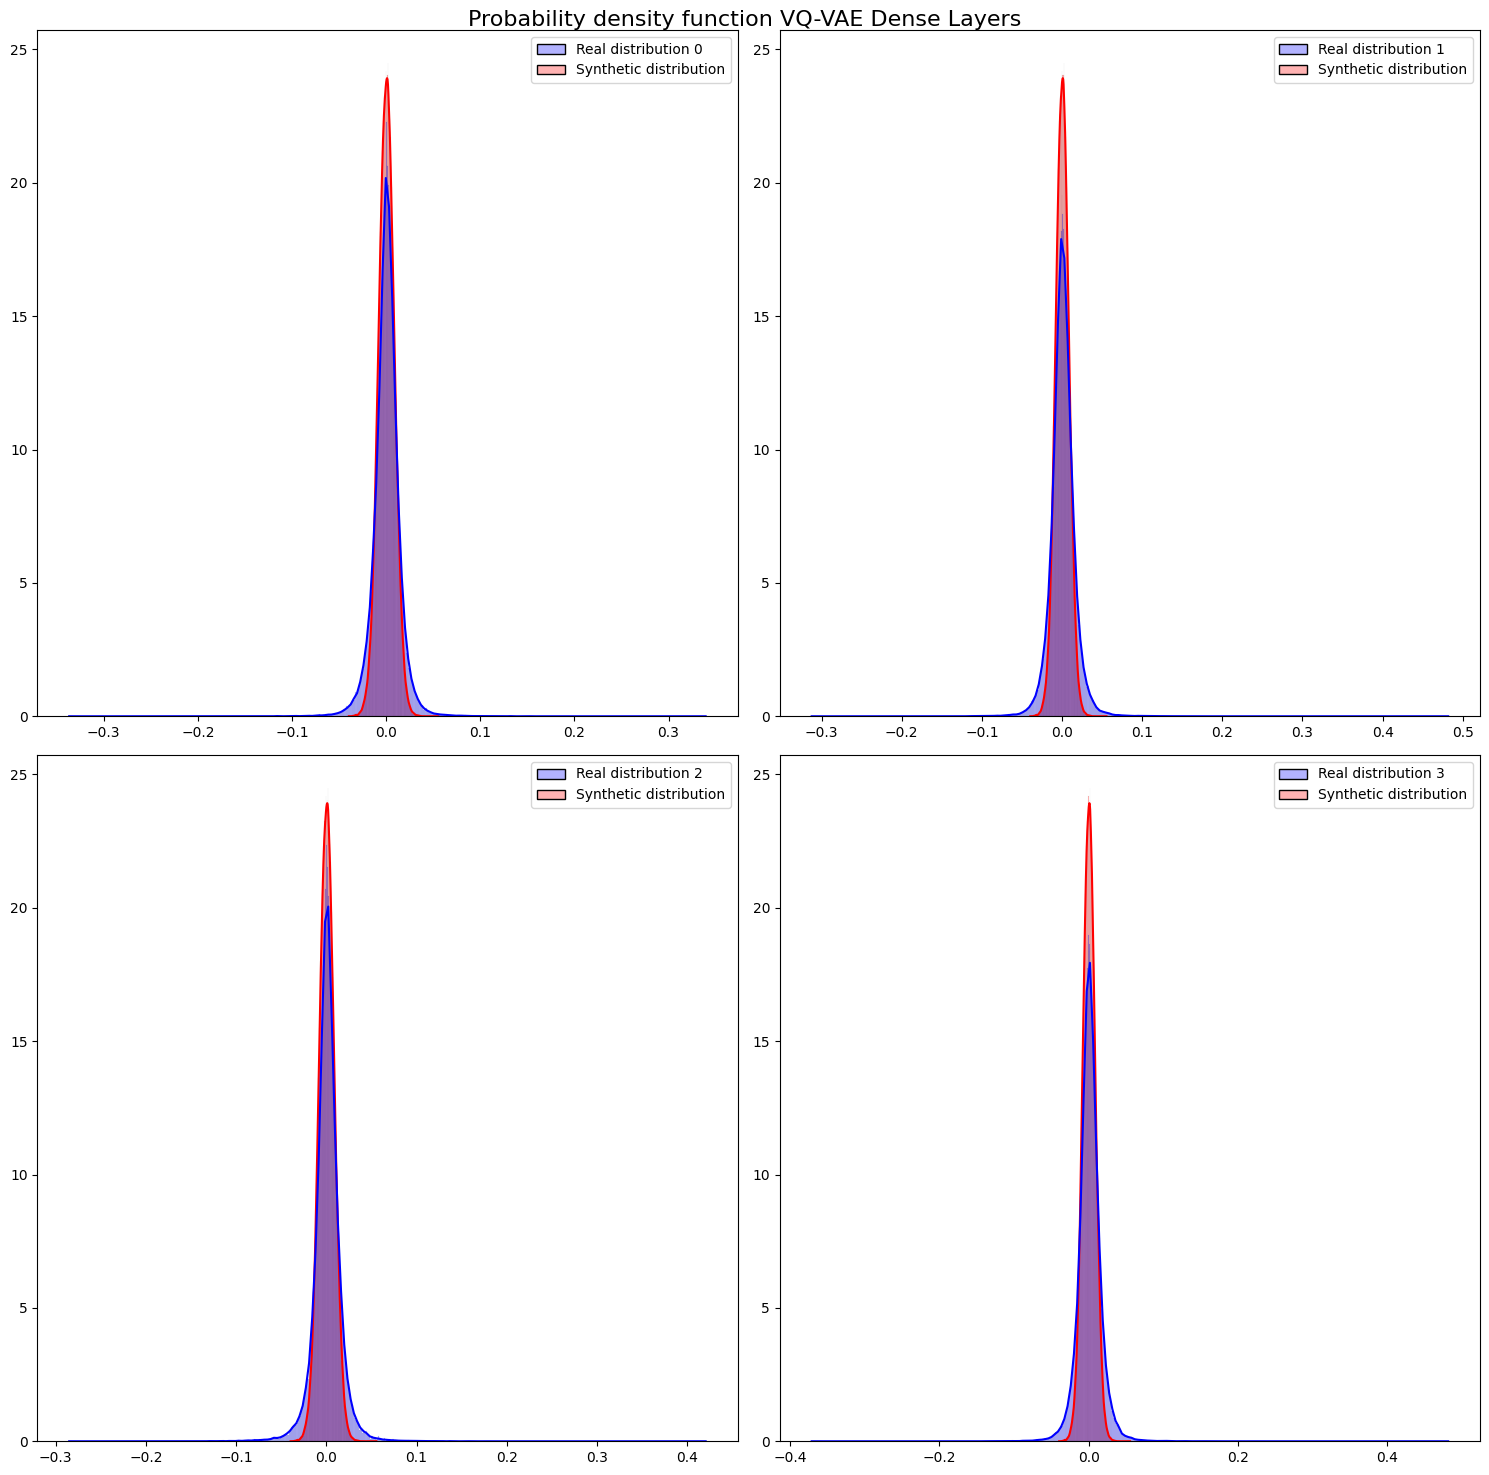

In [51]:
sns.set_palette(['blue', 'red'])
for model, synth_data in generated.items():
    print('Model: ', model)
    fig, axes = plt.subplots(2,2, figsize=(15,15)) 
    title = 'Probability density function ' + model
    fig.suptitle(title, fontsize=16)
    for i in range(4):
        real = pd.DataFrame(data_eval[i].flatten())

        real['label'] = 'Real distribution'+ ' ' + str(i)
        real.columns = ['value', 'label']
        synth = pd.DataFrame(synth_data.flatten())
        synth['label'] = 'Synthetic distribution'
        synth.columns = ['value', 'label']
        df = pd.concat([real, synth])

        g =sns.histplot(df,
            bins='auto',
            kde=True,
            x = 'value',
            hue='label',
            stat="density",
            common_bins=False,
            # facet_kws={'legend_out': False}, 
            alpha=0.3,
            ax=axes[i//2, i%2]
                  )
        g.set(xlabel= None, ylabel= None )
        g.legend_.set_title(None)
        # legend = g._legend
        # legend.set_title(None)
        # handles, labels = axes[i//2, i%2].get_legend_handles_labels()
        # axes[i//2, i%2].legend(handles=handles[1:], labels=labels[1:])
    plt.tight_layout()
    plt.show()
    file_name = plots + model + '/'+model+'_pdf.png'
    file_name = file_name.replace(' ', '_')
    file_name = file_name.replace('-', '_')
    file_name = file_name.lower()
    fig.savefig(file_name, dpi=fig.dpi)
    
        

In [60]:
max_real[0]

0.3394275018068486

Model:  TIME VAE BASE


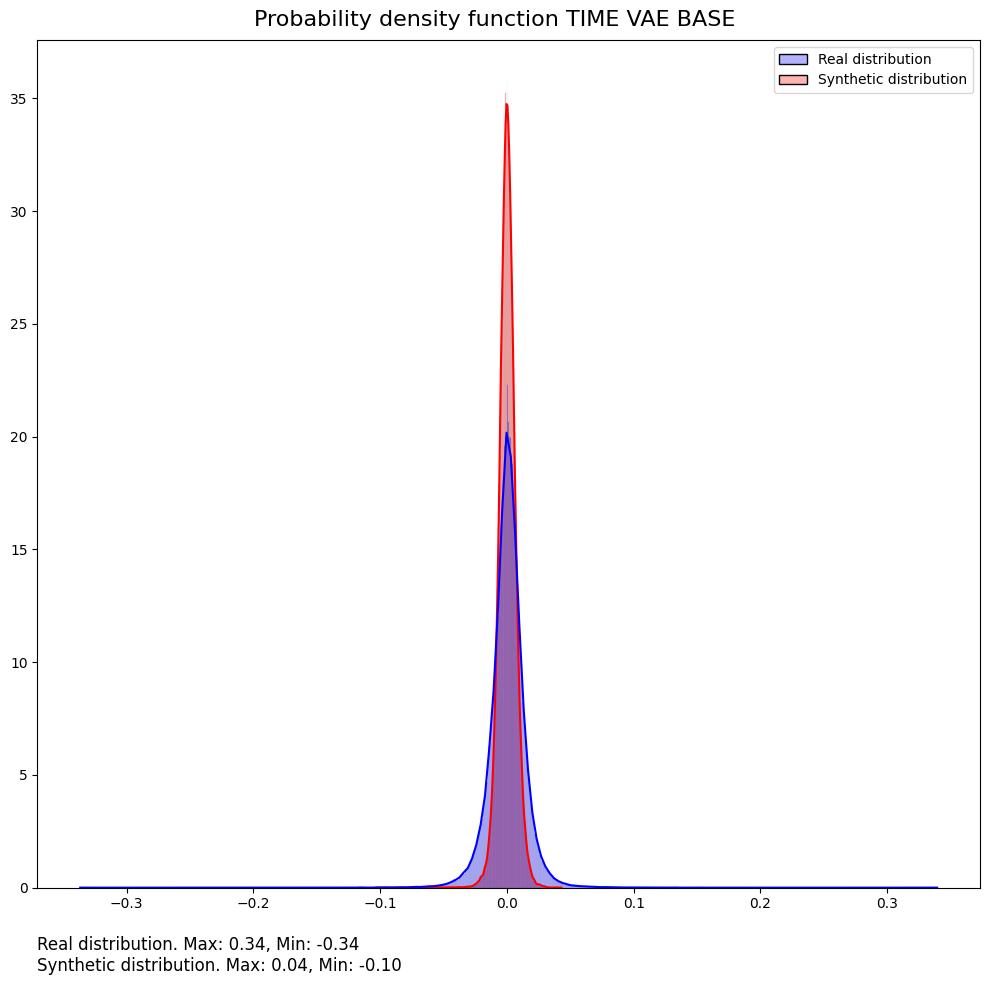

Model:  VAE Convolutional 1


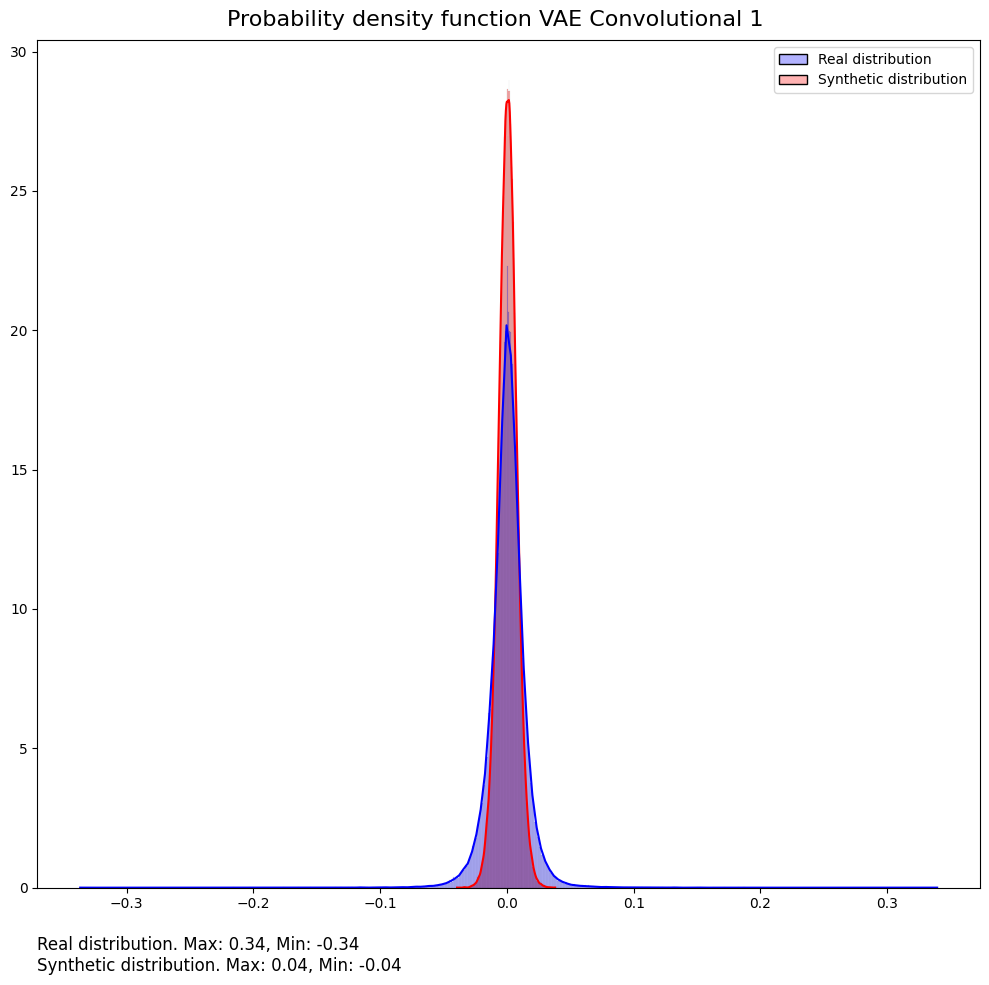

Model:  VAE Convolutional 2


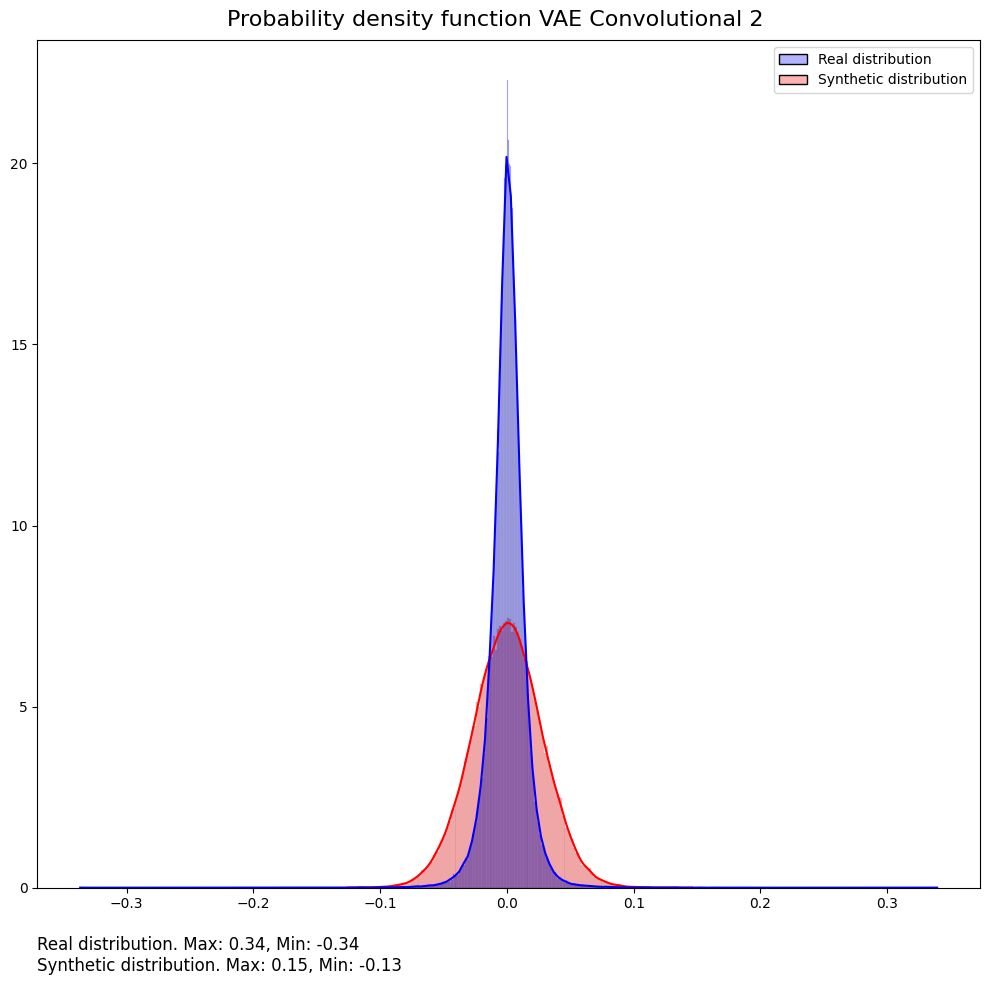

Model:  VAE Dense Layers 1


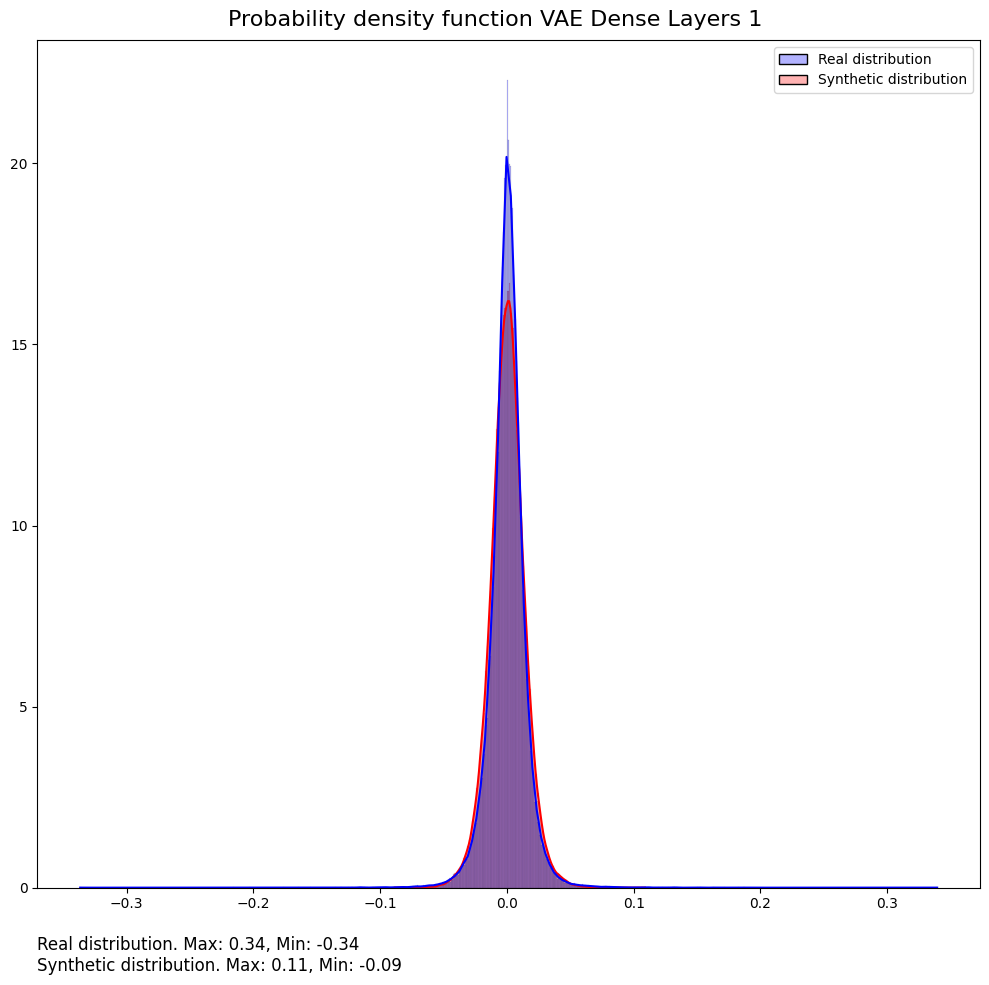

Model:  VAE Dense Layers 2


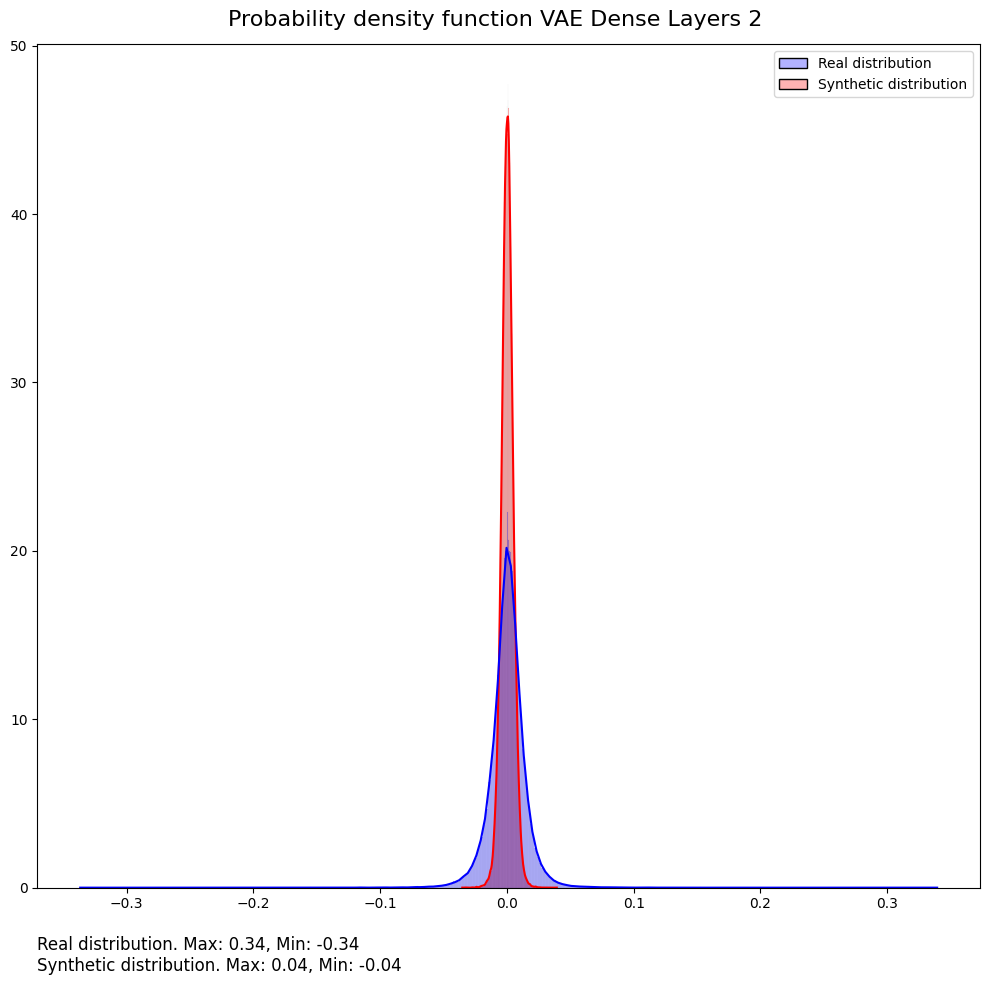

Model:  VQ-VAE Convolutional


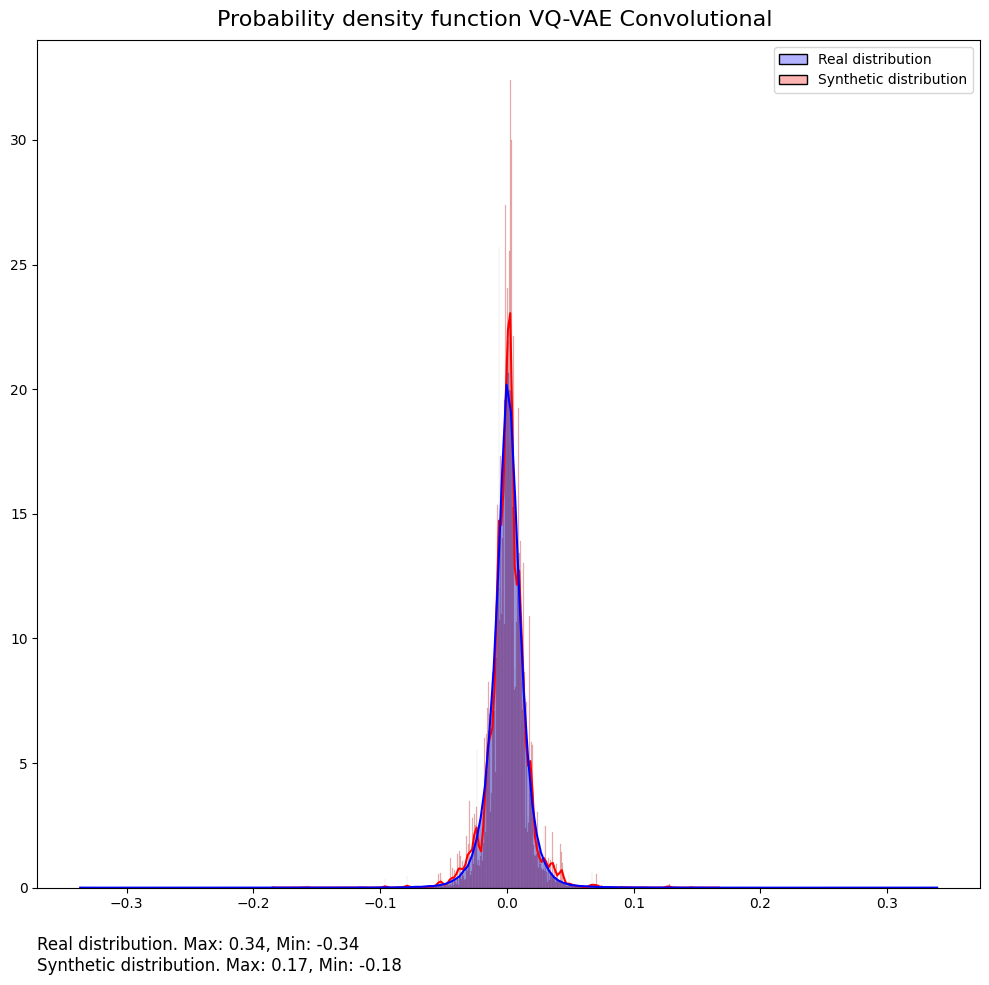

Model:  VQ-VAE Dense Layers


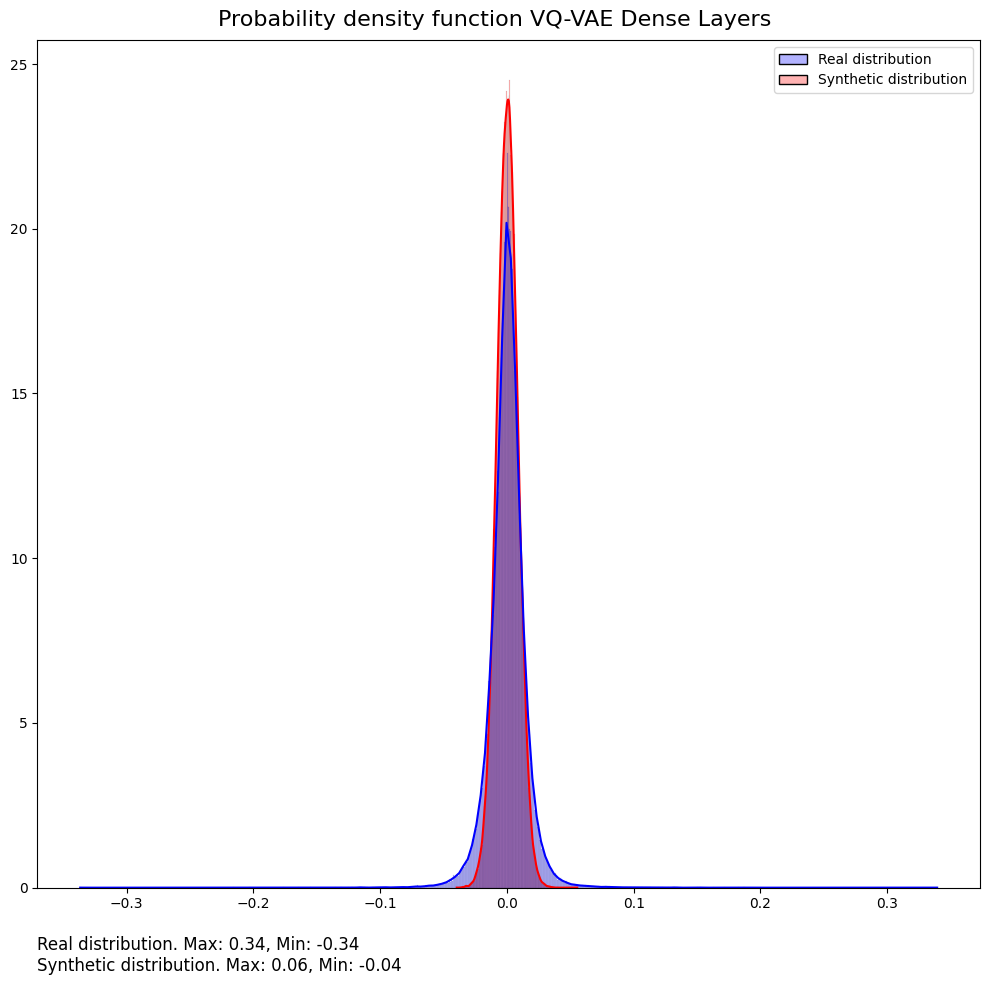

In [97]:
sns.set_palette(['blue', 'red'])
i =0 
for model, synth_data in generated.items():
    print('Model: ', model)
    fig, axes = plt.subplots(figsize=(10,10) ) 
    title = 'Probability density function ' + model
    fig.suptitle(title, fontsize=16 )
    
    # for i in range(4):
    real = pd.DataFrame(data_eval[i].flatten())
    max_real = real.max()[0]
    min_real = real.min()[0]
    real['label'] = f'Real distribution'
    real.columns = ['value', 'label']
    synth = pd.DataFrame(synth_data.flatten())
    max_synth = synth.max()[0]
    min_synth = synth.min()[0]
    synth['label'] = f'Synthetic distribution'
    synth.columns = ['value', 'label']
    df = pd.concat([real, synth])

    g =sns.histplot(df,
        bins='auto',
        kde=True,
        x = 'value',
        hue='label',
        stat="density",
        # facet_kws={'legend_out': False}, 
        alpha=0.3,
        common_bins=False,
        # ax=axes[i//2, i%2]
                )
    g.set(xlabel= None, ylabel= None )
    g.legend_.set_title(None)
    # add footnote
    text = f'Real distribution. Max: {max_real:.2f}, Min: {min_real:.2f}'
    text1 = f'Synthetic distribution. Max: {max_synth:.2f}, Min: {min_synth:.2f}'
    text = text + '\n' + text1
    plt.annotate(text, (0,0), (0, -60), xycoords='axes fraction', textcoords='offset points',fontsize=12)
    # # legend = g._legend
    # legend.set_title(None)
    # handles, labels = axes[i//2, i%2].get_legend_handles_labels()
    # axes[i//2, i%2].legend(handles=handles[1:], labels=labels[1:])
    plt.tight_layout()
    plt.show()
    file_name = plots + model + '/'+model+'_pdf_single.png'
    file_name = file_name.replace(' ', '_')
    file_name = file_name.replace('-', '_')
    file_name = file_name.lower()
    fig.savefig(file_name, dpi=fig.dpi)

    
        

# Cumulative sum

In [87]:
# index = np.random.randint(0, train_batches, 4)
index = [10, 60, 46, 50]
index


[10, 60, 46, 50]

In [99]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')

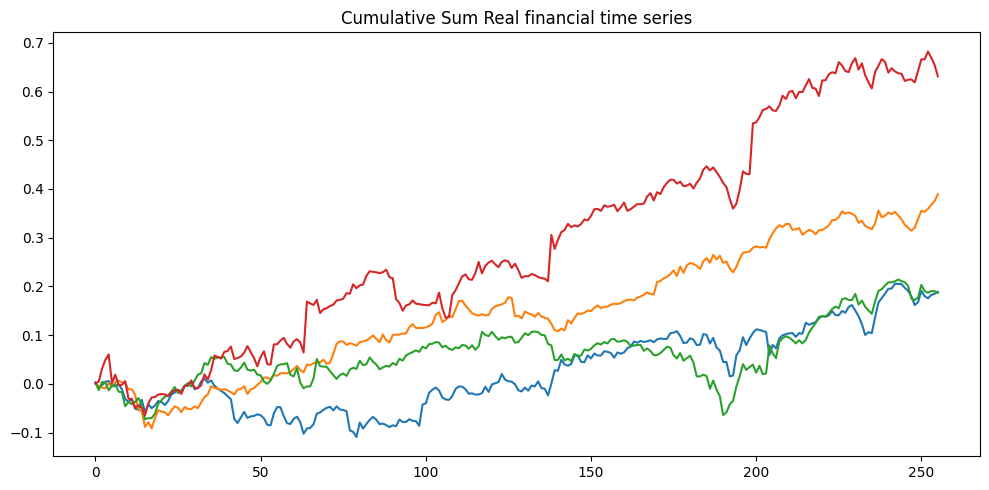

In [100]:
batch = data_eval[0]
title='Cumulative Sum Real financial time series'
fig = plt.figure(figsize=(10, 5))
for i in index: 
    plt.plot(np.cumsum(batch[i]))
plt.title(title)
plt.tight_layout()
plt.show()
file_name = real_dir + 'cumsum'+ '.png'
fig.savefig(file_name, dpi=fig.dpi)


Model:  TIME VAE BASE


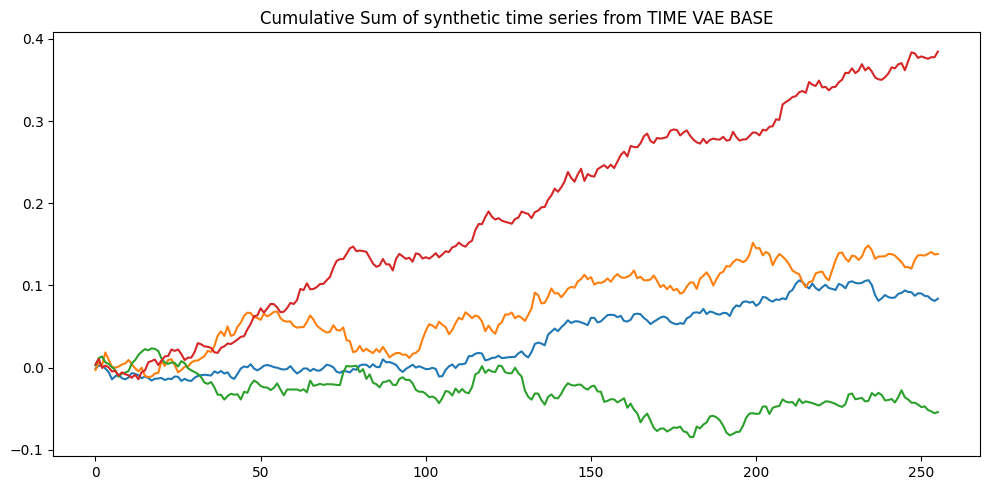

Model:  VAE Convolutional 1


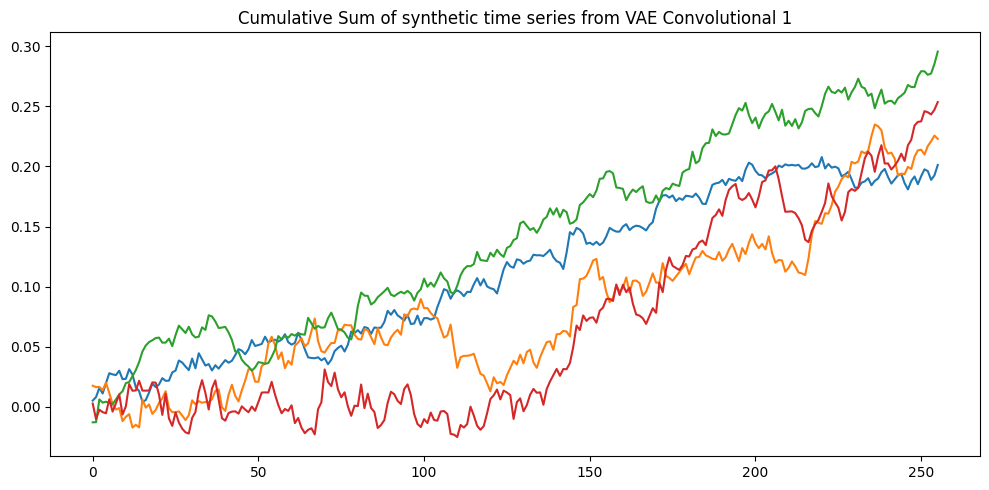

Model:  VAE Convolutional 2


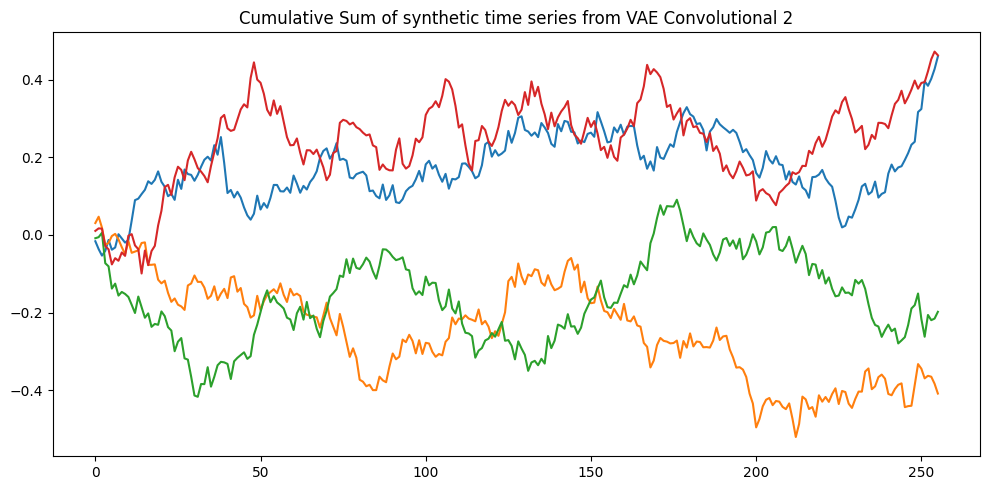

Model:  VAE Dense Layers 1


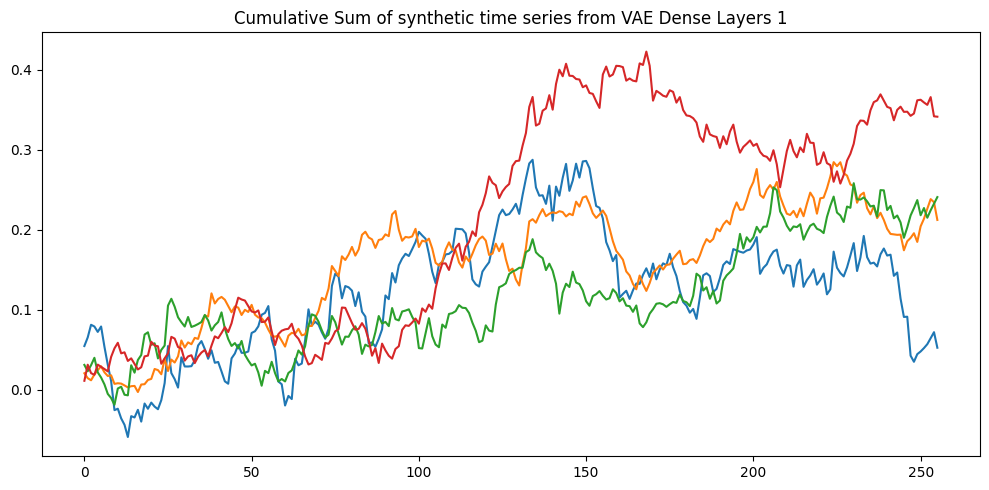

Model:  VAE Dense Layers 2


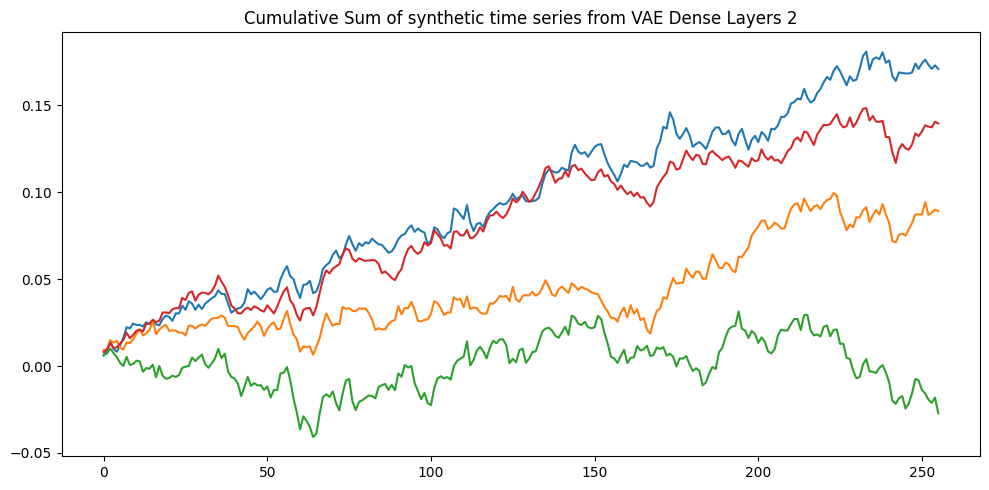

Model:  VQ-VAE Convolutional


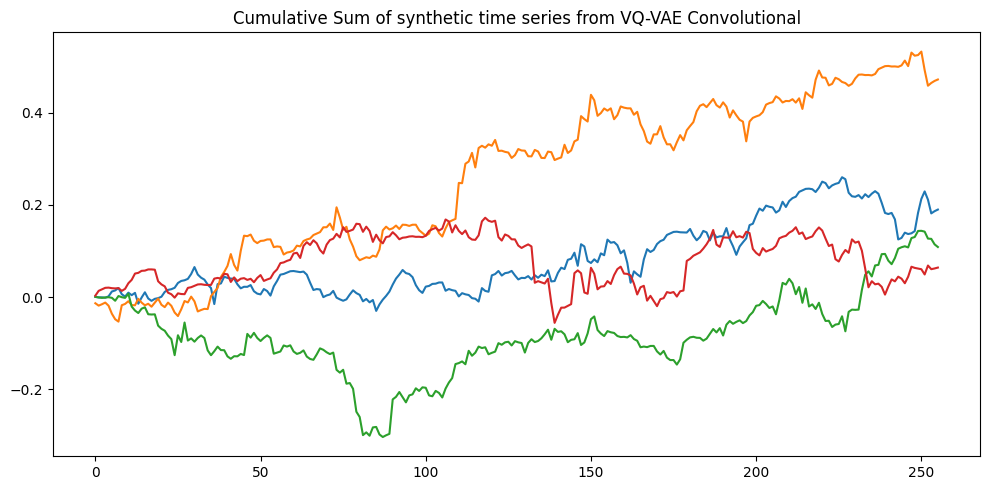

Model:  VQ-VAE Dense Layers


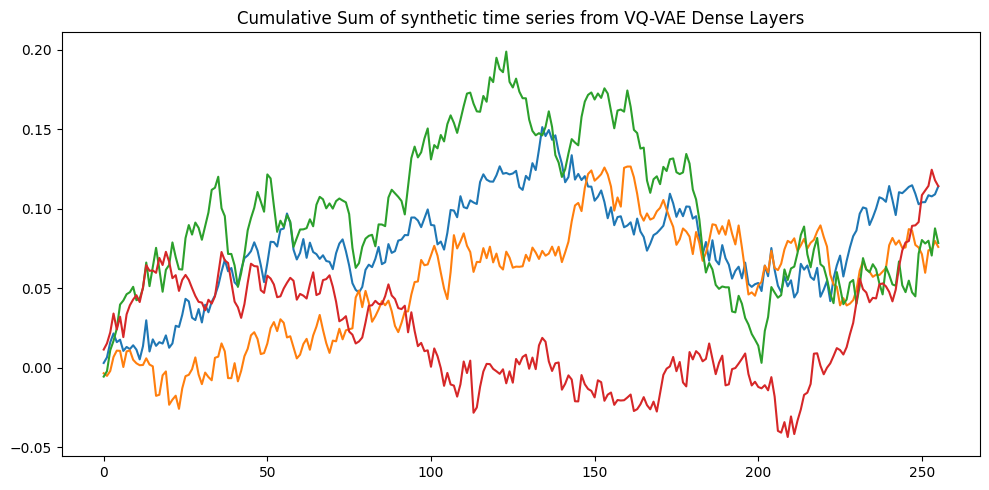

In [101]:
for model, synth in generated.items():
    print('Model: ', model)    
    title =  'Cumulative Sum of synthetic time series from ' + model
    fig = plt.figure(figsize=(10, 5))
    for i in index: 
        plt.plot(np.cumsum(synth[i]))
    plt.title(title)
    plt.tight_layout()
    plt.show()
    file_name = plots + model + '/'+model+'_cumsum.png'
    file_name = file_name.replace(' ', '_')
    file_name = file_name.replace('-', '_')
    file_name = file_name.lower()
    fig.savefig(file_name, dpi=fig.dpi)
        

# Tren Ratios 

In [10]:
def plot_cumulativesum(batch, index, title):
    for i in index: 
        plt.plot(np.cumsum(batch[i]))
    plt.title(title)
    plt.show()

In [44]:
def plot_trendratio(batch, index, title, lw):
    for i in index: 
        s = np.cumsum(batch[i])
        trend = np.array([(s[i]/s[i-lw+1])-1 for i in range(lw-1, length)])
        n = np.array([np.abs((s[i]/s[i-1])-1) for i in range(lw-1, length)])
        n = np.cumsum(n)
        trend_ratio = trend/n
        plt.plot(trend_ratio)
        plt.title(title)
        plt.show()


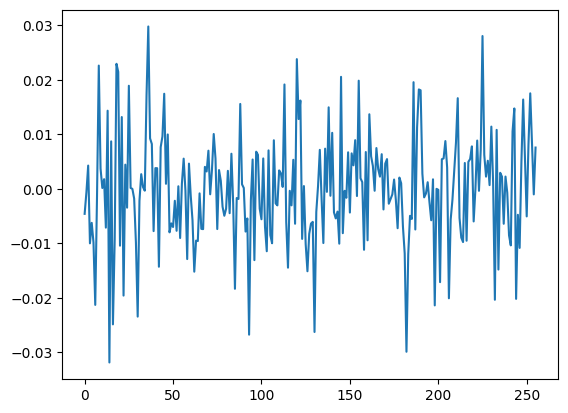

In [25]:
# Trend ratio
i = 0 
series = batch[i]
plt.plot(series)

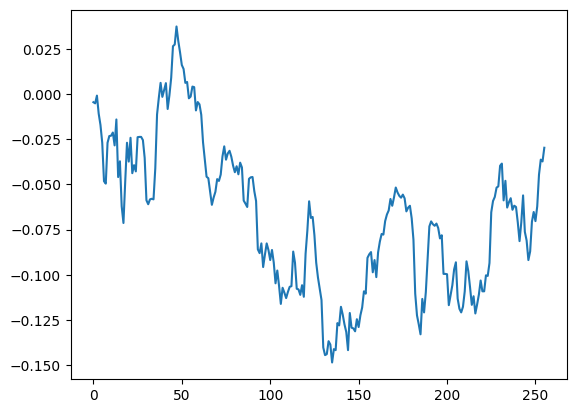

In [26]:
s = np.cumsum(series)
plt.plot(s)

(237,)


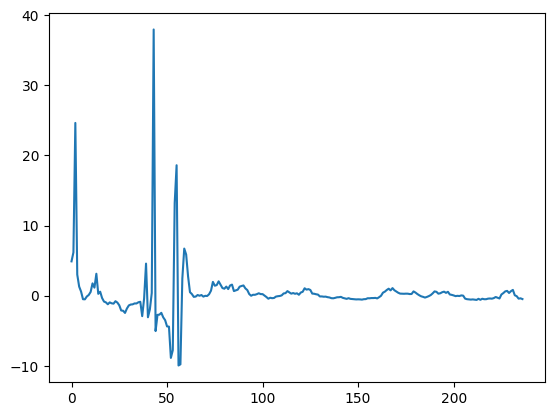

In [39]:
# Trend
lw = 20
trend = []
for i in range(lw-1, length):
    trend.append((s[i]/s[i-lw+1])-1)
trend = np.array(trend)
# trend = np.array([(s[i]/s[i-lw+1])-1 for i in range(lw-1, length)])
print(trend.shape)
plt.plot(trend)

In [45]:
lw-1 - (lw-1)

0

(237,)


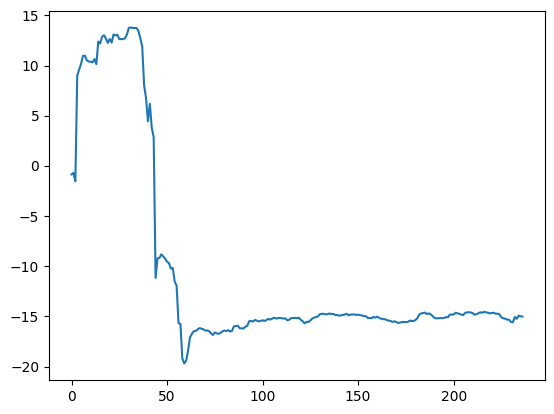

In [49]:
# Noise ???
n = np.array([(s[i]/s[i-1])-1 for i in range(0, length-lw+1)])
# n = np.abs(n)
n = np.cumsum(n)
print(n.shape)
plt.plot(n)

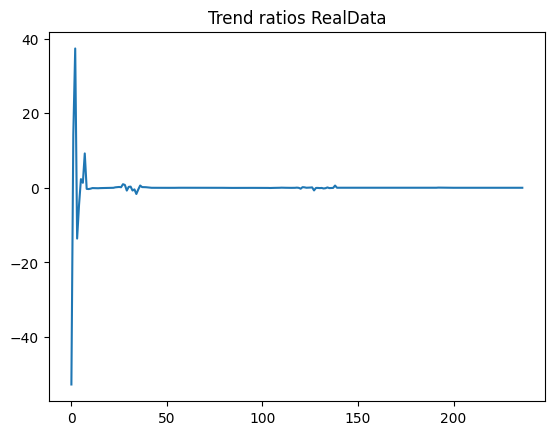

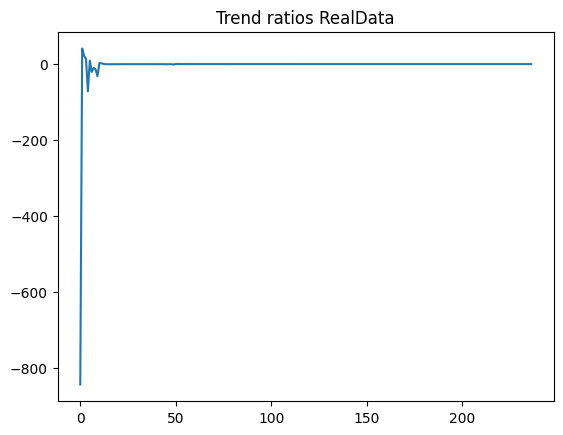

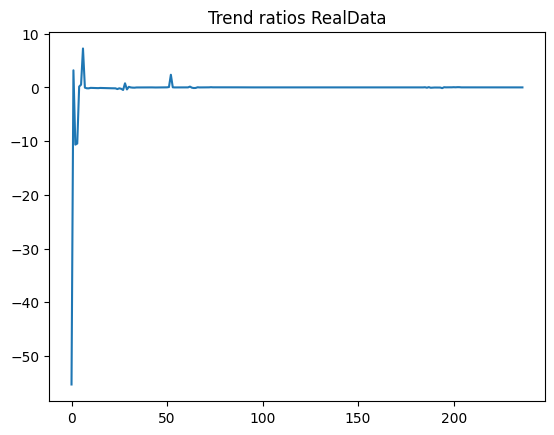

In [51]:
plot_trendratio(data_eval[0], index, title = 'Trend ratios RealData', lw=20)

Model:  VQ VAE CONV2


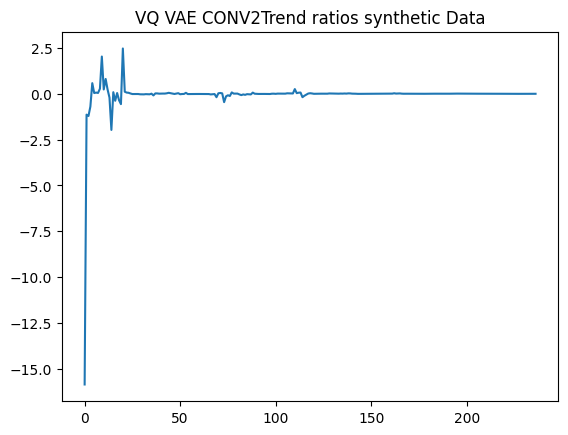

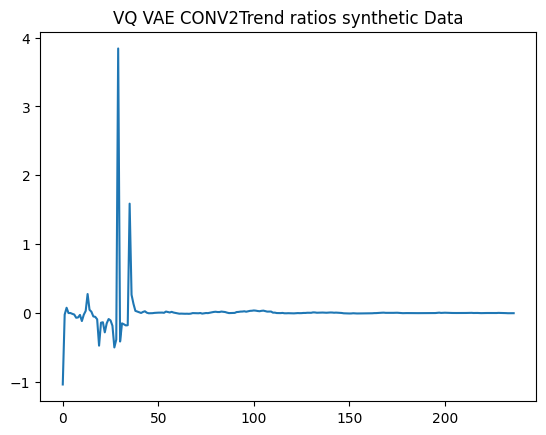

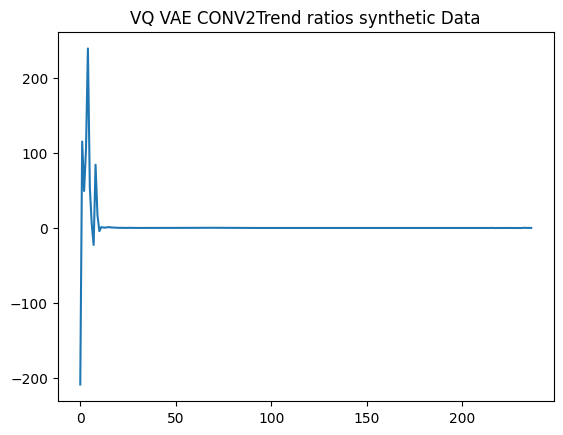

Model:  VAE CONV1 


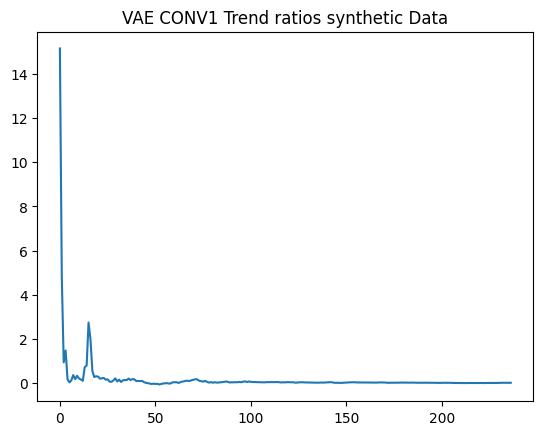

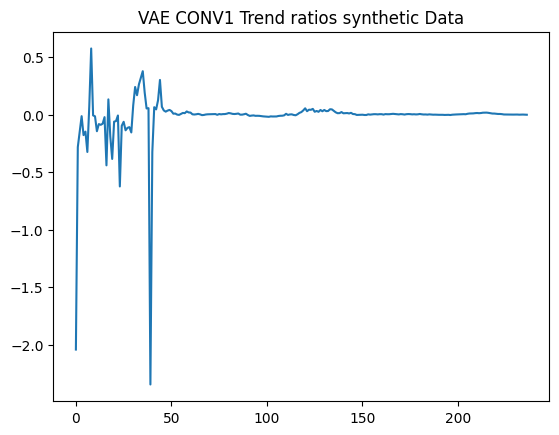

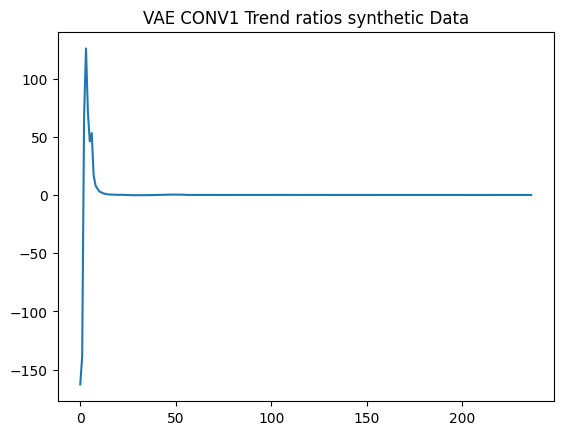

Model:  VAE CONV3


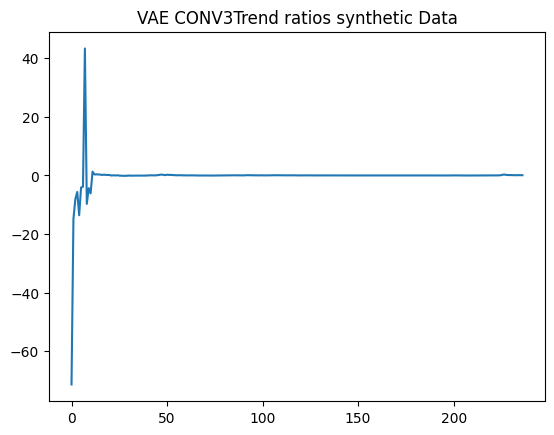

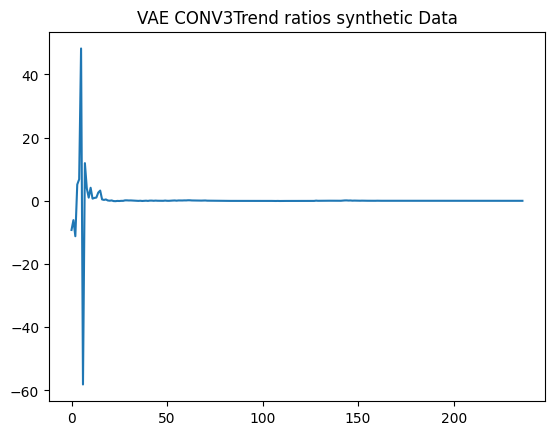

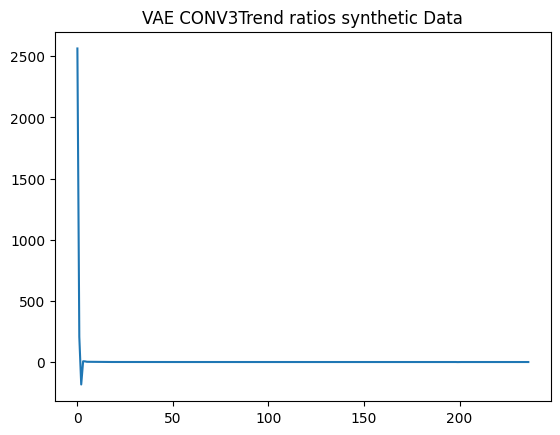

Model:  VAE FD1


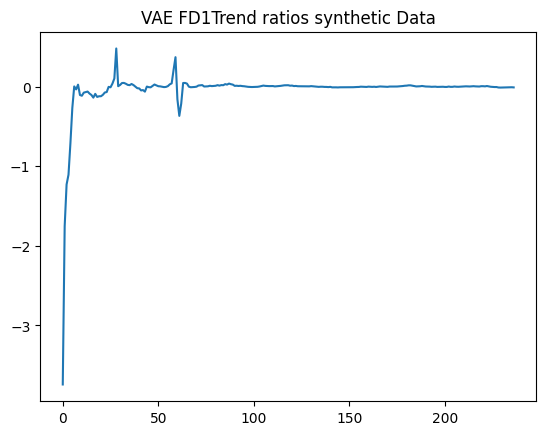

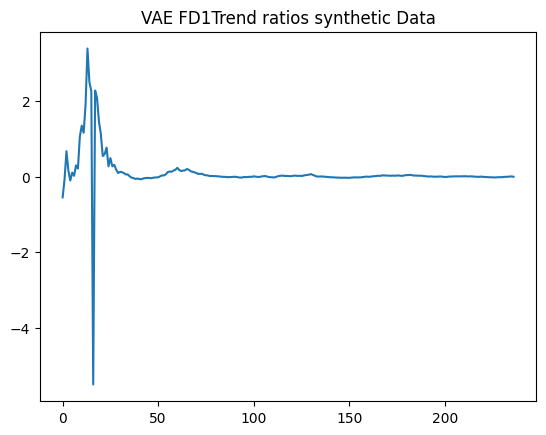

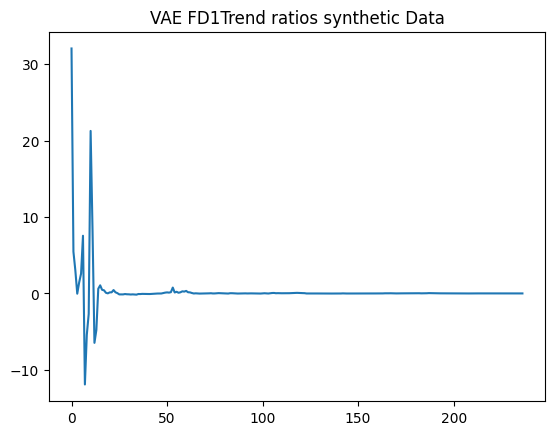

Model:  VAE FD2


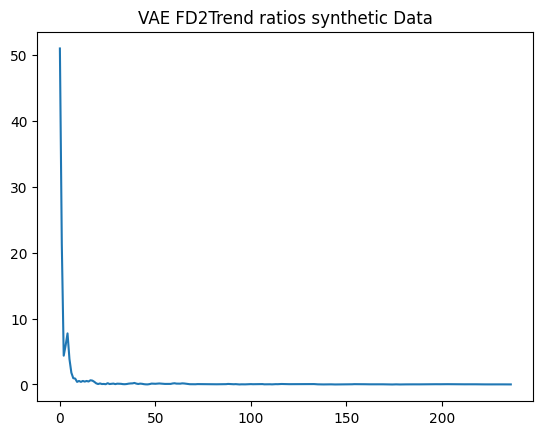

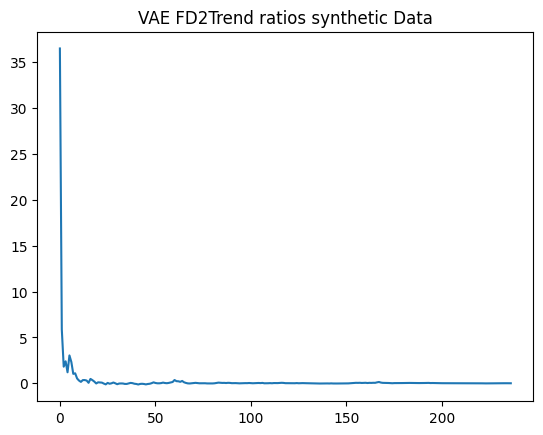

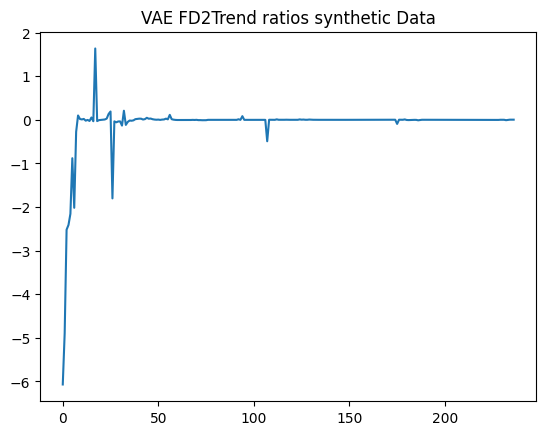

Model:  VQ VAE FD1


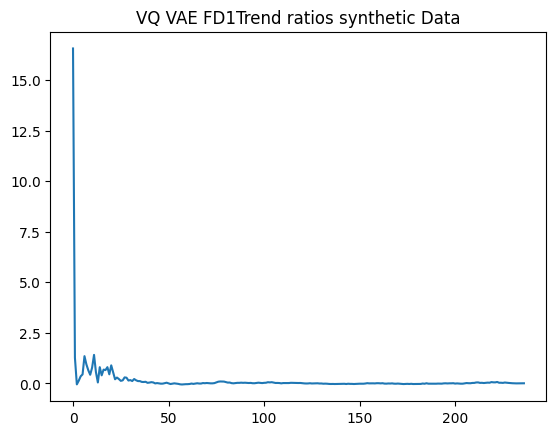

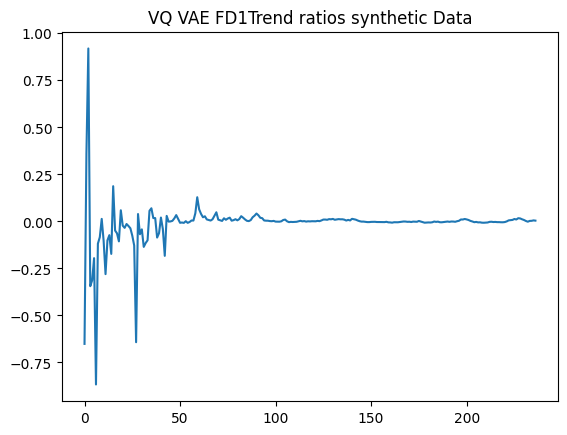

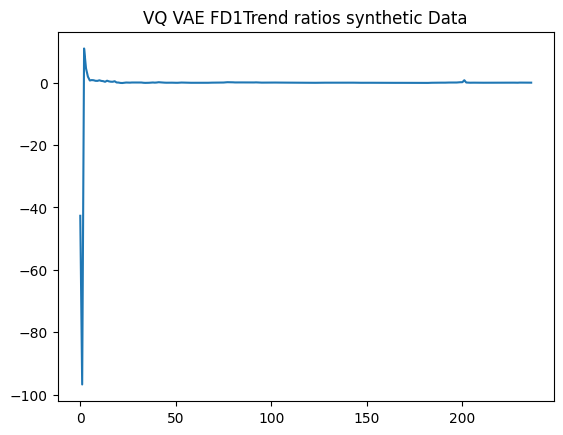

In [54]:
for model, synth in generated.items():
    print('Model: ', model)    
    title =  model + 'Trend ratios synthetic Data'
    plot_trendratio(synth, index, title = title, lw=20)